<a href="https://colab.research.google.com/github/win7/GraphEmbedding_Spectrometry/blob/main/Go_Pro_Graph_Embedding_Spectrometry_(multiple_local%2C_Clustering)_Direct_Indirect_(second_process_data)_(2_graph).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install

In [234]:
!pip install tensorflow==1.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 3.56 s (started: 2022-11-12 17:42:20 +00:00)


In [235]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 3.88 s (started: 2022-11-12 17:42:24 +00:00)


In [236]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 2.96 s (started: 2022-11-12 17:42:28 +00:00)


In [237]:
!pip install python-igraph
!pip install cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 5.71 s (started: 2022-11-12 17:42:31 +00:00)


In [238]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.36 s (started: 2022-11-12 17:42:36 +00:00)


In [239]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 2.86 s (started: 2022-11-12 17:42:40 +00:00)


In [240]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 2.95 s (started: 2022-11-12 17:42:43 +00:00)


In [241]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 3.25 s (started: 2022-11-12 17:42:45 +00:00)


In [242]:
# install StellarGraph if running on Google Colab
""" import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1 """

" import sys\nif 'google.colab' in sys.modules:\n  %pip install -q stellargraph[demos]==1.2.1 "

time: 4.41 ms (started: 2022-11-12 17:42:49 +00:00)


## Import library

In [231]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.63 s (started: 2022-11-12 17:41:29 +00:00)


In [232]:
from gensim.models import Word2Vec
from hdbscan import HDBSCAN
from matplotlib.colors import ListedColormap
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, OPTICS
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, rand_score, silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_kernels, pairwise_distances, cosine_similarity
# from stellargraph import StellarGraph
# from stellargraph.data import UniformRandomWalk, BiasedRandomWalk
from scipy.spatial import distance
from umap import UMAP

import igraph as ig
import math 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import networkx as nx
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import random
import seaborn as sns
import sys

# import plotly.tools as tls
# from plotly.graph_objs import *

%matplotlib inline
# pd.options.display.float_format = "{:.8f}".format
np.random.seed(42)

time: 7.01 ms (started: 2022-11-12 17:41:35 +00:00)


In [233]:
py_file_location = "/content/drive/MyDrive/PUCP/Phd/S2/T2/GraphEmbedding/GraphEmbedding-master"
sys.path.append(os.path.abspath(py_file_location))

from ge.classify import read_node_label,Classifier
from ge import Struc2Vec, Node2Vec, SDNE, LINE, DeepWalk

time: 1.23 ms (started: 2022-11-12 17:41:39 +00:00)


## Functions

In [ ]:
def get_random_walk(graph, node, n_steps=4):
  random.seed(1)
  # Given a graph and a node, return a random walk starting from the node   
  local_path = [str(node),]
  target_node = node  
  for _ in range(n_steps):
    neighbors = list(nx.all_neighbors(graph, target_node))
    target_node = random.choice(neighbors)
    local_path.append(str(target_node))
  return local_path

time: 2.34 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def info_graph(graph):
  """ print(f"Radius: {nx.radius(graph)}")
  print(f"Diameter: {nx.diameter(graph)}")
  print(f"Eccentricity: {nx.eccentricity(graph)}")
  print(f"Center: {nx.center(graph)}")
  print(f"Periphery: {nx.periphery(graph)}") """
  print(f"Density: {nx.density(graph)}")
  print(f"Length: {len(graph)}")
  print(f"Nodes: {sorted(graph.nodes())}")
  print(f"N° nodes: {graph.number_of_nodes()}")
  print(f"Edges: {graph.edges()}")
  print(f"N° edges: {graph.number_of_edges()}")

time: 1.22 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def join_sub(df, blocks):
  # blocks= [(start1, end1), (start2, end2), ...]

  sdf = df.iloc[:, blocks[0][0]:blocks[0][1]]

  for block in blocks[1:]:
    sdf = sdf.join(df.iloc[:, block[0]:block[1]])
  return sdf

time: 935 µs (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def transpose(df):
  df = df.T
  df.reset_index(drop=True, inplace=True)
  return df

time: 1.43 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def build_graph(matrix, threshold=0.5):
  edges = []
  for i in matrix.index:
    for j in matrix.columns:
      if i != j:
        if not math.isnan(matrix[i][j]) and abs(matrix[i][j]) >= threshold:
          edges.append([i, j])
  return edges

time: 1.68 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def build_graph_weight(matrix, threshold=0.5):
  edges = []
  for i in matrix.index:
    for j in matrix.columns:
      if i != j:
        if not math.isnan(matrix[i][j]) and abs(matrix[i][j]) >= threshold:
          edges.append([i, j, matrix[i][j]])
          """ if matrix[i][j] < 0:
            edges.append([i, j, 0.1])
          else:
            edges.append([i, j, matrix[i][j]]) """
  return edges

time: 1.97 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def deepwalk(G, num_walk, num_step):
  walk_paths = []
  for node in G.nodes():
    for _ in range(num_walk):
      walk_paths.append(get_random_walk(G, node, n_steps=num_step))
  return walk_paths

time: 1.65 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2entity)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(10, 10))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

time: 2.86 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def detail(model):
  words = list(model.wv.vocab)
  print("Words\t", words)
  words_id = list(model.wv.index2word)
  print("Words id", words_id)
  words_id = list(model.wv.index2entity)
  print("Words id", words_id)
  print("Nodes\t", G.nodes())
  # print("Vector", model.wv["22"])
  print("Vector", model.wv.get_vector("1"))

time: 1.91 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def silhouette(X, k):
  # Generating the sample data from make_blobs
  # This particular setting has one distinct cluster and 3 clusters placed close
  # together.

  range_n_clusters = range(2, k)

  for n_clusters in range_n_clusters:
      # Create a subplot with 1 row and 2 columns
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
      # fig.set_size_inches(18, 7)

      # The 1st subplot is the silhouette plot
      # The silhouette coefficient can range from -1, 1 but in this example all
      # lie within [-0.1, 1]
      ax1.set_xlim([-0.1, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
      ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

      # Initialize the clusterer with n_clusters value and a random generator
      # seed of 10 for reproducibility.
      clusterer = KMeans(n_clusters=n_clusters, random_state=10)
      cluster_labels = clusterer.fit_predict(X)

      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed
      # clusters
      silhouette_avg = silhouette_score(X, cluster_labels)
      print(
          "For n_clusters =",
          n_clusters,
          "The average silhouette_score is :",
          silhouette_avg,
      )

      # Compute the silhouette scores for each sample
      sample_silhouette_values = silhouette_samples(X, cluster_labels)

      y_lower = 10
      for i in range(n_clusters):
          # Aggregate the silhouette scores for samples belonging to
          # cluster i, and sort them
          ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

          ith_cluster_silhouette_values.sort()

          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          color = cm.nipy_spectral(float(i) / n_clusters)
          ax1.fill_betweenx(
              np.arange(y_lower, y_upper),
              0,
              ith_cluster_silhouette_values,
              facecolor=color,
              edgecolor=color,
              alpha=0.7,
          )

          # Label the silhouette plots with their cluster numbers at the middle
          ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

          # Compute the new y_lower for next plot
          y_lower = y_upper + 10  # 10 for the 0 samples

      ax1.set_title("The silhouette plot for the various clusters.")
      ax1.set_xlabel("The silhouette coefficient values")
      ax1.set_ylabel("Cluster label")

      # The vertical line for average silhouette score of all the values
      ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

      ax1.set_yticks([])  # Clear the yaxis labels / ticks
      ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      # 2nd Plot showing the actual clusters formed
      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
      ax2.scatter(
          X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
      )

      # Labeling the clusters
      centers = clusterer.cluster_centers_
      # Draw white circles at cluster centers
      ax2.scatter(
          centers[:, 0],
          centers[:, 1],
          marker="o",
          c="white",
          alpha=1,
          s=200,
          edgecolor="k",
      )

      for i, c in enumerate(centers):
          ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

      ax2.set_title("The visualization of the clustered data.")
      ax2.set_xlabel("Feature space for the 1st feature")
      ax2.set_ylabel("Feature space for the 2nd feature")

      plt.suptitle(
          "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
          % n_clusters,
          fontsize=14,
          fontweight="bold",
      )

  plt.show()

time: 4.13 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def complete_nodes(df, length):
  indexes = df.index
  for index in range(length):
    if index not in indexes:
      df.loc[index] = [-1]
    
  df = df.sort_index()  # sorting by index
  return df

time: 1.36 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def matching():
  fig = make_subplots(rows=3, cols=2,
                      subplot_titles=("Raw data: 111-125", "Raw data: 411-425", 
                                      "Process data: 111-125", "Process data: 411-425"),
                      horizontal_spacing=0.05, vertical_spacing=0.05)

  fig.add_trace(
      go.Scatter(
          x=node_embeddings_2d1[:,0],
          y=node_embeddings_2d1[:,1],
          mode="markers",
          text=labels1,
          textposition="bottom center",
          marker=dict(
            size=8,
            color=labels1,
            opacity=0.9,
            colorscale="Rainbow",
            line_width=0.5
          ),
      ),
      row=1, col=1
  )

  fig.add_trace(
      go.Scatter(
          x=node_embeddings_2d2[:,0],
          y=node_embeddings_2d2[:,1],
          mode="markers",
          text=labels2,
          textposition="bottom center",
          marker=dict(
            size=8,
            color=labels2,
            opacity=0.9,
            colorscale="Rainbow",
            line_width=0.5
          ),
      ),
      row=1, col=2
  )

  fig.add_trace(
      go.Scatter(
          x=node_embeddings_2d3[:,0],
          y=node_embeddings_2d3[:,1],
          mode="markers+text",
          text=node_ids3,
          textposition="bottom center",
          marker=dict(
            size=8,
            color=labels3,
            opacity=0.9,
            colorscale="Rainbow", # ["red", "blue"],
            line_width=0.5
          ),
      ),
      row=2, col=1
  )

  fig.add_trace(
      go.Scatter(
          x=node_embeddings_2d4[:,0],
          y=node_embeddings_2d4[:,1],
          mode="markers+text",
          text=node_ids4,
          textposition="bottom center",
          marker=dict(
            size=8,
            color=labels4,
            opacity=0.9,
            colorscale="Rainbow", # ["red", "blue"],
            line_width=0.5
          ),
      ),
      row=2, col=2
  )

  labels1_ = [2] * len(node_ids1)
  size1_ = [8] * len(node_ids1)
  opacity1_ = [0.1] * len(node_ids1)
  for k, node_id in enumerate(node_ids3):
    if node_id in node_ids1:
      index = node_ids1.index(node_id)
      labels1_[index] = labels3[k]
      # size1_[index] = 10
      opacity1_[index] = 0.9

  fig.add_trace(
      go.Scatter(
          x=node_embeddings_2d1[:,0],
          y=node_embeddings_2d1[:,1],
          mode="markers",
          text=node_ids1,
          textposition="bottom center",
          marker=dict(
            size=8, # size1_,
            color=labels1_,
            opacity=opacity1_,
            colorscale="Rainbow", # ["red", "blue", "gray"],
            line_width=0.5
          ),
      ),
      row=3, col=1
  )

  labels2_ = [2] * len(node_ids2)
  size2_ = [8] * len(node_ids2)
  opacity2_ = [0.1] * len(node_ids2)
  for k, node_id in enumerate(node_ids4):
    if node_id in node_ids2:
      index = node_ids2.index(node_id)
      labels2_[index] = labels4[k]
      # size2_[index] = 10
      opacity2_[index] = 0.9

  fig.add_trace(
      go.Scatter(
          x=node_embeddings_2d2[:,0],
          y=node_embeddings_2d2[:,1],
          mode="markers",
          text=node_ids2,
          textposition="bottom center",
          marker=dict(
            size=8, # size2_,
            color=labels2_,
            opacity=opacity2_,
            colorscale="Rainbow", # ["red", "blue", "gray"],
            line_width=0.5
          ),
      ),
      row=3, col=2
  )

  fig.update_layout(height=1000, width=1000, title_text="Clustering Embeddings",
                    showlegend=False)
  fig.show()

  """ fig = px.scatter(df_plot1, x="component1", y="component2", hover_data=["node_id"], 
                  color="color", text="node_id")
  fig.update_layout(
      height=800,
      title_text='GDP and Life Expectancy (Americas, 2007)'
  )
  HTML(fig.to_html()) """

time: 7.96 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def similarity(df_embedding, w1, w2):
  u = df_embedding.loc[w1].to_numpy()
  v = df_embedding.loc[w2].to_numpy()

  similarity = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
  return similarity

# similarity(node_embeddings1, '1', '173')

time: 1.3 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
# model1.wv["798"]
def most_similar(df_embedding, w, topn=10):
  # u = embedding.loc[w].to_numpy() # model1.wv["1"]
  similarities = []
  for index in df_embedding.index:
    similar = similarity(df_embedding, w, index)
    similarities.append((index, similar))
  similarities = np.array(similarities)

  sorted_array = similarities[np.argsort(similarities[:, 1])]
  sorted_array = sorted_array[::-1][1:topn + 1]
  return sorted_array

# most_similar(node_embeddings1, "1", 10)

time: 1.63 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
# Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist

def similarity_cos(u, v):
  similarity = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
  return similarity

def euclidean_distance(u, v):
  dist = np.linalg.norm(u - v)
  return dist

def most_similar2(embedding1, embedding2, topn=10, metric="euclidean"):
  # u = embedding.loc[w].to_numpy() # model1.wv["1"]
  data = []
  for w1 in embedding1.index:
    u = embedding1.loc[w1].to_numpy()
    similarities = []
    for w2 in embedding2.index:
      v = embedding2.loc[w2].to_numpy()
      # similar = euclidean_distance(u, v)
      # similar = similarity_cos(u, v)
      similar = distance.cdist([u], [v], metric=metric)
      similarities.append((int(w1), int(w2), similar[0][0]))

    similarities = np.array(similarities)

    sorted_array = similarities[np.argsort(similarities[:, 2])]
    if metric == "cosine":
      sorted_array = sorted_array[:][:topn]
    else:
      sorted_array = sorted_array[:topn]
    
    for item in sorted_array:
      data.append(item)
  df = pd.DataFrame(data, columns=["u", "u'", "{}".format(metric)])
  df["u"] = df["u"].astype("int")
  df["u'"] = df["u'"].astype("int")

  return df

time: 3.1 ms (started: 2022-11-12 13:32:25 +00:00)


In [ ]:
def get_epsilon(X_train):
  neigh = NearestNeighbors(n_neighbors=2 * X_train.shape[1])
  nbrs = neigh.fit(X_train)
  distances, indices = nbrs.kneighbors(X_train)

  # Plotting K-distance Graph
  distances = np.sort(distances, axis=0)
  distances_ = distances[:,1]

  i = np.arange(len(distances))
  knee = KneeLocator(i, distances_, S=1, curve='convex', direction='increasing', interp_method='polynomial')

  plt.figure(figsize=(12, 6))
  knee.plot_knee()
  plt.xlabel("Points")
  plt.ylabel("Distance")
  plt.grid()

  print(distances[knee.knee])

time: 2.36 ms (started: 2022-11-12 13:32:25 +00:00)


## Load dataset

In [249]:
dir = "/content/drive/MyDrive/PUCP/Phd/S2/T2/GraphEmbedding"
colors = ["#FF00FF", "#3FFF00", "#00FFFF", "#FFF700", "#FF0000", "#0000FF", "#006600",
          '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', 'black',"gray"]
# colors = px.colors.sequential.Rainbow

time: 1.11 ms (started: 2022-11-12 17:46:30 +00:00)


In [250]:
# Metadata
df_meta = pd.read_csv("{}/Inputs/SecondDataset/process_metadata.csv".format(dir), delimiter="|")
df_meta

,Corrected (m/z),Metabolites - Approved by Nicola,Metabolites - Used by Florian,Theoretical - m/z (based on BioCyc),Chemical Formula (based on BioCyc),Adduct (negative mode),Error in mDa (oTOF),Error in PPM (Theoretical vs Corrected)
0,59.0137,Acetic acid,*,59.01357,C2H4O2,H,0.00013,2.24338
1,NaN,Acrylamide,*,70.02955,C3H5NO,H,0.98435,14056.1798
2,71.0139,Acrylic acid,*,71.01357,C3H4O2,H,3.01133,42405.02894
3,NaN,Tetrahydrophurane,*,71.04995,C4H8O,H,13.97965,196758.00293
4,NaN,Propionic acid,*,73.02922,C3H6O2,H,13.97938,191421.77297
...,...,...,...,...,...,...,...,...
184,NaN,C20H27N10O16P3,*,755.07466,C20H27N10O16P3,H,755.07466,1000000
185,766.1076,Coenzyme A,*,766.10765,C21H36N7O16P3S,H,766.10765,1000000
186,784.1495,FAD,*,784.14957,C27H33N9O15P2,H,784.14957,1000000
187,808.1180,Acetyl coenzyme A,*,808.11821,C23H38N7O17P3S,H,808.11821,1000000


time: 30.3 ms (started: 2022-11-12 17:46:31 +00:00)


In [251]:
df_meta = df_meta.dropna(axis=0)
df_meta = df_meta.astype({"Corrected (m/z)": str})
df_meta.set_index("Corrected (m/z)", inplace=True)
df_meta

,Metabolites - Approved by Nicola,Metabolites - Used by Florian,Theoretical - m/z (based on BioCyc),Chemical Formula (based on BioCyc),Adduct (negative mode),Error in mDa (oTOF),Error in PPM (Theoretical vs Corrected)
Corrected (m/z),,,,,,,
59.0137,Acetic acid,*,59.01357,C2H4O2,H,0.00013,2.24338
71.0139,Acrylic acid,*,71.01357,C3H4O2,H,3.01133,42405.02894
74.0249,Glycine,*,74.02447,C2H5NO2,H,14.01603,189343.25348
85.0296,Methyl Acrylate,*,85.02922,C4H6O2,H,3.99528,46987.17023
87.0086,Pyruvic acid,*,87.00848,C3H4O3,H,14.01582,161085.6483
...,...,...,...,...,...,...,...
664.117,Nicotinamide adenine dinucleotide,*,664.11721,C21H29N7O14P2,H,664.11721,1000000
665.2139,C33H36N6O7 + K,*,665.21430,C24H42O21,H,665.2143,1000000
766.1076,Coenzyme A,*,766.10765,C21H36N7O16P3S,H,766.10765,1000000


time: 21.1 ms (started: 2022-11-12 17:46:31 +00:00)


In [252]:
# Load dataset Group 1
df1 = pd.read_csv("{}/Inputs/SecondDataset/process_wt.csv".format(dir), delimiter="|")

print(df1.shape)
df1.head()

(230, 91)


,Set,Cluster,ID,ionMz,Label,59.0137,71.0139,74.0249,85.0296,87.0086,...,521.984,545.3994,604.0696,606.0744,611.144,664.117,665.2139,766.1076,784.1495,808.118
0,A,WT,71,0071 / WT 2.2,WT,56523,1438,3904,1167,1646,...,17082,7826,21390,95664,9169,6184,3014,4161,2455,4679
1,A,WT,72,0072 / WT 2.2,WT,24625,570,1531,518,1068,...,10087,5536,11066,44221,3993,3181,2565,1987,1553,2701
2,A,WT,73,0073 / WT 2.2,WT,78586,577,2486,1260,1095,...,21099,9408,24709,105252,9896,8580,5077,5141,2404,5618
3,A,WT,74,0074 / WT 2.2,WT,76559,1272,2501,1565,1673,...,21910,8717,22982,103328,10482,6189,3498,5228,3433,5782
4,A,WT,75,0075 / WT 2.2,WT,67449,1060,2557,1345,1596,...,22226,9082,23236,105020,9024,6370,3947,4743,1996,5418


time: 32.1 ms (started: 2022-11-12 17:46:31 +00:00)


In [253]:
# df1.set_index("Alignment ID", inplace=True)
# df1.head()

time: 633 µs (started: 2022-11-12 17:46:31 +00:00)


In [254]:
# Load dataset Group 2

df2 = pd.read_csv("{}/Inputs/SecondDataset/process_zw.csv".format(dir), delimiter="|")

print(df2.shape)
df2.head()

(150, 91)


,Set,Cluster,ID,ionMz,Label,59.0137,71.0139,74.0249,85.0296,87.0086,...,521.984,545.3994,604.0696,606.0744,611.144,664.117,665.2139,766.1076,784.1495,808.118
0,A,WT,1,0001 / zwf1^ 3.4,zwf1^,53182,641,5734,1042,1294,...,23348,6988,64597,114975,7538,4107,3095,3877,2040,3349
1,A,WT,2,0002 / zwf1^ 3.4,zwf1^,57902,1767,2889,1228,1531,...,26203,5613,75636,131864,8365,4607,4145,5541,2816,6021
2,A,WT,3,0003 / zwf1^ 3.4,zwf1^,51861,491,3540,1054,2448,...,22678,6304,64496,114834,7459,4293,3090,3279,1465,5946
3,A,WT,4,0004 / zwf1^ 3.4,zwf1^,62812,1648,6611,914,2578,...,25871,7033,76118,137734,6667,6285,4698,4961,2726,7357
4,A,WT,5,0005 / zwf1^ 3.4,zwf1^,54291,1525,3965,872,1812,...,22464,6646,67845,121045,8957,5474,4182,5072,2647,5559


time: 30.4 ms (started: 2022-11-12 17:46:31 +00:00)


In [255]:
# df2.set_index("Alignment ID", inplace=True)
# df2.head()

time: 298 µs (started: 2022-11-12 17:46:31 +00:00)


## Preprocessing

### Join sub row data

In [261]:
df_process1 = df1.iloc[:,5:]
df_process1

,59.0137,71.0139,74.0249,85.0296,87.0086,88.0405,89.0245,101.0243,102.0562,109.0407,...,521.984,545.3994,604.0696,606.0744,611.144,664.117,665.2139,766.1076,784.1495,808.118
0,56523,1438,3904,1167,1646,1008,2265,1068,757,2504,...,17082,7826,21390,95664,9169,6184,3014,4161,2455,4679
1,24625,570,1531,518,1068,598,1401,866,507,1730,...,10087,5536,11066,44221,3993,3181,2565,1987,1553,2701
2,78586,577,2486,1260,1095,585,3965,1445,615,1900,...,21099,9408,24709,105252,9896,8580,5077,5141,2404,5618
3,76559,1272,2501,1565,1673,1085,2718,1243,483,2591,...,21910,8717,22982,103328,10482,6189,3498,5228,3433,5782
4,67449,1060,2557,1345,1596,1293,2496,1226,267,2298,...,22226,9082,23236,105020,9024,6370,3947,4743,1996,5418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,552888,42277,48251,66352,17530,20017,86977,20918,17626,49736,...,72636,24601,178424,293977,28675,113958,8240,2001,6038,7192
226,548340,36847,47041,64482,16471,17924,71080,16969,15791,48134,...,60481,20943,167246,265600,25479,101004,8055,2981,4781,6491
227,493758,40229,43139,68411,14856,18407,78105,23903,17651,51417,...,70685,26444,184251,285629,30594,109009,8336,3690,4748,8770
228,589787,42434,53010,73022,17663,22007,88048,19267,18657,50946,...,71218,25050,184113,293588,29535,110981,8154,5122,5513,7518


time: 39.6 ms (started: 2022-11-12 17:51:36 +00:00)


In [262]:
df_process2 = df2.iloc[:,5:]
df_process2

,59.0137,71.0139,74.0249,85.0296,87.0086,88.0405,89.0245,101.0243,102.0562,109.0407,...,521.984,545.3994,604.0696,606.0744,611.144,664.117,665.2139,766.1076,784.1495,808.118
0,53182,641,5734,1042,1294,1940,2755,902,1260,4804,...,23348,6988,64597,114975,7538,4107,3095,3877,2040,3349
1,57902,1767,2889,1228,1531,990,2511,606,1105,2865,...,26203,5613,75636,131864,8365,4607,4145,5541,2816,6021
2,51861,491,3540,1054,2448,1928,1608,677,1154,2347,...,22678,6304,64496,114834,7459,4293,3090,3279,1465,5946
3,62812,1648,6611,914,2578,1633,2480,581,1096,4227,...,25871,7033,76118,137734,6667,6285,4698,4961,2726,7357
4,54291,1525,3965,872,1812,1348,2306,1630,803,2882,...,22464,6646,67845,121045,8957,5474,4182,5072,2647,5559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,181058,34300,94410,53978,17378,26847,58738,21390,40141,130069,...,265074,142165,611985,1253220,41901,312792,13867,23979,23604,52350
146,133247,35946,91914,66589,20837,35502,81753,22785,48479,131885,...,235053,129635,575883,1157148,41314,302833,12741,21145,22037,54274
147,156753,34937,90135,58742,19972,35555,73766,25427,41248,128587,...,272005,143109,626983,1295456,44074,327254,14620,24958,22242,57179
148,192830,31011,88636,48706,16375,23797,52303,24101,28432,99651,...,234966,136943,595416,1208533,34467,317512,12937,22864,20562,54420


time: 80.6 ms (started: 2022-11-12 17:51:54 +00:00)


### Calculate the logarithm

In [121]:
df_process1_log = df_process1.copy()
for column in df_process1.columns:
  df_process1_log[column] = np.log10(df_process1_log[column])
df_process1_log

,59.0137,71.0139,74.0249,85.0296,87.0086,88.0405,89.0245,101.0243,102.0562,109.0407,...,521.984,545.3994,604.0696,606.0744,611.144,664.117,665.2139,766.1076,784.1495,808.118
0,4.752225,3.157759,3.591510,3.067071,3.216430,3.003461,3.355068,3.028571,2.879096,3.398634,...,4.232539,3.893540,4.330211,4.980749,3.962322,3.791269,3.479143,3.619198,3.390051,3.670153
1,4.391376,2.755875,3.184975,2.714330,3.028571,2.776701,3.146438,2.937518,2.705008,3.238046,...,4.003762,3.743196,4.043991,4.645629,3.601299,3.502564,3.409087,3.298198,3.191171,3.431525
2,4.895345,2.761176,3.395501,3.100371,3.039414,2.767156,3.598243,3.159868,2.788875,3.278754,...,4.324262,3.973497,4.392855,5.022230,3.995460,3.933487,3.705607,3.711048,3.380934,3.749582
3,4.883996,3.104487,3.398114,3.194514,3.223496,3.035430,3.434249,3.094471,2.683947,3.413467,...,4.340642,3.940367,4.361388,5.014218,4.020444,3.791620,3.543820,3.718336,3.535674,3.762078
4,4.828976,3.025306,3.407731,3.128722,3.203033,3.111599,3.397245,3.088490,2.426511,3.361350,...,4.346861,3.958181,4.366161,5.021272,3.955399,3.804139,3.596267,3.676053,3.300161,3.733839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,5.742637,4.626104,4.683506,4.821854,4.243782,4.301399,4.939404,4.320520,4.246154,4.696671,...,4.861152,4.390953,5.251453,5.468313,4.457503,5.056745,3.915927,3.301247,3.780893,3.856850
226,5.739050,4.566402,4.672477,4.809438,4.216720,4.253435,4.851747,4.229656,4.198410,4.682452,...,4.781619,4.321039,5.223356,5.424228,4.406182,5.004339,3.906066,3.474362,3.679519,3.812312
227,5.693514,4.604539,4.634870,4.835126,4.171902,4.264983,4.892679,4.378452,4.246769,4.711107,...,4.849327,4.422327,5.265410,5.455802,4.485636,5.037462,3.920958,3.567026,3.676511,3.943000
228,5.770695,4.627714,4.724358,4.863454,4.247064,4.342561,4.944719,4.284814,4.270842,4.707110,...,4.852590,4.398808,5.265084,5.467738,4.470337,5.045249,3.911371,3.709440,3.741388,3.876102


time: 57.9 ms (started: 2022-11-12 15:27:23 +00:00)


In [122]:
df_process2_log = df_process2.copy()
for column in df_process2.columns:
  df_process2_log[column] = np.log10(df_process2_log[column])
df_process2_log

,59.0137,71.0139,74.0249,85.0296,87.0086,88.0405,89.0245,101.0243,102.0562,109.0407,...,521.984,545.3994,604.0696,606.0744,611.144,664.117,665.2139,766.1076,784.1495,808.118
0,4.725765,2.806858,3.758458,3.017868,3.111934,3.287802,3.440122,2.955207,3.100371,3.681603,...,4.368250,3.844353,4.810212,5.060603,3.877256,3.613525,3.490661,3.588496,3.309630,3.524915
1,4.762694,3.247237,3.460748,3.089198,3.184975,2.995635,3.399847,2.782473,3.043362,3.457125,...,4.418351,3.749195,4.878729,5.120126,3.922466,3.663418,3.617525,3.743588,3.449633,3.779669
2,4.714841,2.691081,3.549003,3.022841,3.388811,3.285107,3.206286,2.830589,3.062206,3.370513,...,4.355605,3.799616,4.809533,5.060070,3.872681,3.632761,3.489958,3.515741,3.165838,3.774225
3,4.798043,3.216957,3.820267,2.960946,3.411283,3.212986,3.394452,2.764176,3.039811,3.626032,...,4.412813,3.847141,4.881487,5.139041,3.823930,3.798305,3.671913,3.695569,3.435526,3.866701
4,4.734728,3.183270,3.598243,2.940516,3.258158,3.129690,3.362859,3.212188,2.904716,3.459694,...,4.351487,3.822560,4.831518,5.082947,3.952163,3.738305,3.621384,3.705179,3.422754,3.744997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,5.257818,4.535294,4.975018,4.732217,4.240000,4.428896,4.768919,4.330211,4.603588,5.114174,...,5.423367,5.152793,5.786741,6.098027,4.622224,5.495256,4.141983,4.379831,4.372986,4.718917
146,5.124657,4.555651,4.963382,4.823402,4.318835,4.550253,4.912504,4.357649,4.685554,5.120195,...,5.371166,5.112722,5.760334,6.063389,4.616097,5.481203,4.105204,4.325208,4.343152,4.734592
147,5.195216,4.543286,4.954893,4.768949,4.300422,4.550901,4.867856,4.405295,4.615403,5.109197,...,5.434577,5.155667,5.797256,6.112423,4.644182,5.514885,4.164947,4.397210,4.347174,4.757237
148,5.285175,4.491516,4.947610,4.687582,4.214181,4.376522,4.718527,4.382035,4.453807,4.998482,...,5.371005,5.136540,5.774821,6.082259,4.537403,5.501760,4.111834,4.359152,4.313065,4.735759


time: 44.5 ms (started: 2022-11-12 15:27:23 +00:00)


### Transpose

In [263]:
# df_process1_t = transpose(df_process1_log)
df_process1_t = df_process1_log.copy()
df_process1_t

,59.0137,71.0139,74.0249,85.0296,87.0086,88.0405,89.0245,101.0243,102.0562,109.0407,...,521.984,545.3994,604.0696,606.0744,611.144,664.117,665.2139,766.1076,784.1495,808.118
0,4.752225,3.157759,3.591510,3.067071,3.216430,3.003461,3.355068,3.028571,2.879096,3.398634,...,4.232539,3.893540,4.330211,4.980749,3.962322,3.791269,3.479143,3.619198,3.390051,3.670153
1,4.391376,2.755875,3.184975,2.714330,3.028571,2.776701,3.146438,2.937518,2.705008,3.238046,...,4.003762,3.743196,4.043991,4.645629,3.601299,3.502564,3.409087,3.298198,3.191171,3.431525
2,4.895345,2.761176,3.395501,3.100371,3.039414,2.767156,3.598243,3.159868,2.788875,3.278754,...,4.324262,3.973497,4.392855,5.022230,3.995460,3.933487,3.705607,3.711048,3.380934,3.749582
3,4.883996,3.104487,3.398114,3.194514,3.223496,3.035430,3.434249,3.094471,2.683947,3.413467,...,4.340642,3.940367,4.361388,5.014218,4.020444,3.791620,3.543820,3.718336,3.535674,3.762078
4,4.828976,3.025306,3.407731,3.128722,3.203033,3.111599,3.397245,3.088490,2.426511,3.361350,...,4.346861,3.958181,4.366161,5.021272,3.955399,3.804139,3.596267,3.676053,3.300161,3.733839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,5.742637,4.626104,4.683506,4.821854,4.243782,4.301399,4.939404,4.320520,4.246154,4.696671,...,4.861152,4.390953,5.251453,5.468313,4.457503,5.056745,3.915927,3.301247,3.780893,3.856850
226,5.739050,4.566402,4.672477,4.809438,4.216720,4.253435,4.851747,4.229656,4.198410,4.682452,...,4.781619,4.321039,5.223356,5.424228,4.406182,5.004339,3.906066,3.474362,3.679519,3.812312
227,5.693514,4.604539,4.634870,4.835126,4.171902,4.264983,4.892679,4.378452,4.246769,4.711107,...,4.849327,4.422327,5.265410,5.455802,4.485636,5.037462,3.920958,3.567026,3.676511,3.943000
228,5.770695,4.627714,4.724358,4.863454,4.247064,4.342561,4.944719,4.284814,4.270842,4.707110,...,4.852590,4.398808,5.265084,5.467738,4.470337,5.045249,3.911371,3.709440,3.741388,3.876102


time: 91.8 ms (started: 2022-11-12 18:57:57 +00:00)


In [264]:
# df_process1_t = transpose(df_process1_log)
df_process2_t = df_process2_log.copy()
df_process2_t

,59.0137,71.0139,74.0249,85.0296,87.0086,88.0405,89.0245,101.0243,102.0562,109.0407,...,521.984,545.3994,604.0696,606.0744,611.144,664.117,665.2139,766.1076,784.1495,808.118
0,4.725765,2.806858,3.758458,3.017868,3.111934,3.287802,3.440122,2.955207,3.100371,3.681603,...,4.368250,3.844353,4.810212,5.060603,3.877256,3.613525,3.490661,3.588496,3.309630,3.524915
1,4.762694,3.247237,3.460748,3.089198,3.184975,2.995635,3.399847,2.782473,3.043362,3.457125,...,4.418351,3.749195,4.878729,5.120126,3.922466,3.663418,3.617525,3.743588,3.449633,3.779669
2,4.714841,2.691081,3.549003,3.022841,3.388811,3.285107,3.206286,2.830589,3.062206,3.370513,...,4.355605,3.799616,4.809533,5.060070,3.872681,3.632761,3.489958,3.515741,3.165838,3.774225
3,4.798043,3.216957,3.820267,2.960946,3.411283,3.212986,3.394452,2.764176,3.039811,3.626032,...,4.412813,3.847141,4.881487,5.139041,3.823930,3.798305,3.671913,3.695569,3.435526,3.866701
4,4.734728,3.183270,3.598243,2.940516,3.258158,3.129690,3.362859,3.212188,2.904716,3.459694,...,4.351487,3.822560,4.831518,5.082947,3.952163,3.738305,3.621384,3.705179,3.422754,3.744997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,5.257818,4.535294,4.975018,4.732217,4.240000,4.428896,4.768919,4.330211,4.603588,5.114174,...,5.423367,5.152793,5.786741,6.098027,4.622224,5.495256,4.141983,4.379831,4.372986,4.718917
146,5.124657,4.555651,4.963382,4.823402,4.318835,4.550253,4.912504,4.357649,4.685554,5.120195,...,5.371166,5.112722,5.760334,6.063389,4.616097,5.481203,4.105204,4.325208,4.343152,4.734592
147,5.195216,4.543286,4.954893,4.768949,4.300422,4.550901,4.867856,4.405295,4.615403,5.109197,...,5.434577,5.155667,5.797256,6.112423,4.644182,5.514885,4.164947,4.397210,4.347174,4.757237
148,5.285175,4.491516,4.947610,4.687582,4.214181,4.376522,4.718527,4.382035,4.453807,4.998482,...,5.371005,5.136540,5.774821,6.082259,4.537403,5.501760,4.111834,4.359152,4.313065,4.735759


time: 39.6 ms (started: 2022-11-12 18:58:10 +00:00)


### Normal distribution (Done)

In [ ]:
# sns.pairplot(df_process1)

time: 571 µs (started: 2022-11-12 05:38:57 +00:00)


In [ ]:
df_temp = df_process2
h = 5
w = 5
fig = plt.figure(figsize=(30, h * len(df_temp.columns) / (30 / w)))
fig.subplots_adjust(hspace=0.25, wspace=0.15)

for k, node_id in enumerate(df_temp.columns):
  ax = fig.add_subplot(math.ceil(len(df_temp.columns) / 6), 6, k + 1)
  ax.set_xlabel("Raw data")
  ax.set_ylabel("Process data");
  ax.set_title("Linear Correlation, node id: {}".format(node_id))
  sns.histplot(data=df_temp, x=node_id, kde=True)

In [ ]:
from scipy import stats
from scipy.stats import pearsonr

df_temp = df_raw1.copy()
for k, node_id in enumerate(df_temp.columns[:10]):
  shapiro_test = stats.kstest(df_temp[node_id], "norm")
  print(f"Node id {node_id}: {shapiro_test}")

In [ ]:
# Q-Q plot
""" from statsmodels.graphics.gofplots import qqplot

qqplot(df_raw1[43].values, line="s")
plt.show() """

In [ ]:
# Shapiro-Wilk
from scipy.stats import shapiro

stat, p = shapiro(df_raw1[5].values)
print('Estadisticos=%.3f, p=%.3f' % (stat, p))
# Interpretación
alpha = 0.05
if p > alpha:
   print('La muestra parece Gaussiana o Normal (no se rechaza la hipótesis nula H0)')
else:
   print('La muestra no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)')

In [ ]:
# K^2 de D’Agostino

from scipy.stats import normaltest

stat, p = normaltest(df_raw1[5].values)
print('Estadisticos=%.3f, p=%.3f' % (stat, p))
# Interpretación
alpha = 0.05
if p > alpha:
   print('La muestra parece Gaussiana o Normal (no se rechaza la hipótesis nula H0)')
else:
   print('La muestra no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)')

In [ ]:
import pylab
import scipy.stats as stats

for column in df_raw1.columns[:10]:
  print(column)
  stats.probplot(df_raw1[column].values, dist="norm", plot=pylab)
  pylab.show()

#### Correlation matrix

* 0 Null
* $>$ 0.0 – 0.2 Very low
* $>$ 0.2 – 0.4 Low
* $>$ 0.4 – 0.6 Moderate
* $>$ 0.6 – 0.8 High
* $>$ 0.8 – $<$ 1.0 Ver high (test)
* 1.0 Perfect

In [129]:
# matrix_raw1 = df_raw1_t.corr(method="pearson") # pearson, kendall, spearman
# matrix1.style.background_gradient(cmap="bwr")
# matrix_raw2 = df_raw2_t.corr(method="pearson") # pearson, kendall, spearman
matrix_process1 = df_process1_t.corr(method="pearson") # pearson, kendall, spearman
matrix_process2 = df_process2_t.corr(method="pearson") # pearson, kendall, spearman

time: 12.5 ms (started: 2022-11-12 15:28:17 +00:00)


' plt.figure(1, figsize=(30, 30))\nplt.matshow(matrix, cmap="bwr")#, vmin=-1, vmax=1)\n# plt.xticks(range(len(sdf.columns)), sdf.columns, rotation=90)\n# plt.yticks(range(len(sdf.columns)), sdf.columns) '

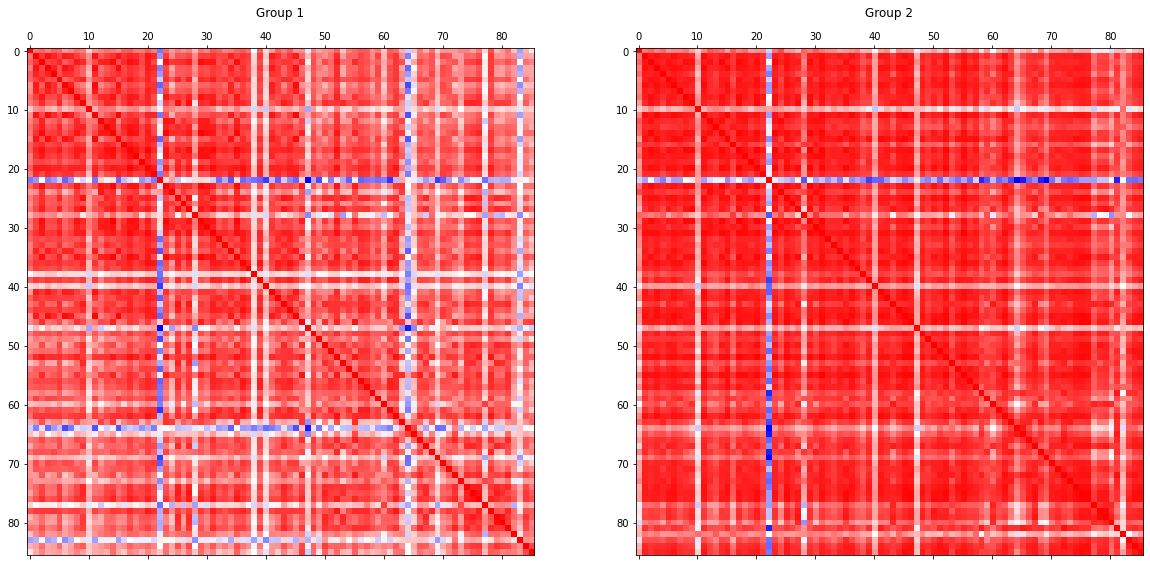

time: 454 ms (started: 2022-11-12 15:29:16 +00:00)


In [132]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
axes[0].matshow(matrix_process1, cmap="bwr")
axes[0].set_title("Group 1")
axes[1].matshow(matrix_process2, cmap="bwr")
axes[1].set_title("Group 2")
""" axes[1][0].matshow(matrix_process1, cmap="bwr")
axes[1][0].set_title("Group 1")
axes[1][1].matshow(matrix_process2, cmap="bwr")
axes[1][1].set_title("Group 2") """

""" plt.figure(1, figsize=(30, 30))
plt.matshow(matrix, cmap="bwr")#, vmin=-1, vmax=1)
# plt.xticks(range(len(sdf.columns)), sdf.columns, rotation=90)
# plt.yticks(range(len(sdf.columns)), sdf.columns) """

## Building graph

### With weight

In [265]:
threshold = 0.5

edges_process1 = build_graph_weight(matrix_process1, threshold)
edges_process2 = build_graph_weight(matrix_process2, threshold)

time: 378 ms (started: 2022-11-12 19:00:08 +00:00)


In [266]:
G1 = nx.Graph()
G1.add_weighted_edges_from(edges_process1)

G2 = nx.Graph()
G2.add_weighted_edges_from(edges_process2)

time: 26.2 ms (started: 2022-11-12 19:00:14 +00:00)


In [267]:
degree_G1 = np.array(list(G1.degree()))
max_degree_G1 = degree_G1[degree_G1[:, 1].argsort()[-1]][0]

degree_G2 = np.array(list(G2.degree()))
max_degree_G2 = degree_G2[degree_G2[:, 1].argsort()[-1]][0]

max_degree_G1, max_degree_G2

('259.0227', '109.0407')

time: 7 ms (started: 2022-11-12 19:00:16 +00:00)


In [268]:
# Change node id name for one graph
edges_process1_ = []
for edge in edges_process1:
  edges_process1_.append(["A" + edge[0], "A" + edge[1], edge[2]])

edges_process2_ = []
for edge in edges_process2:
  edges_process2_.append(["B" + edge[0], "B" + edge[1], edge[2]])

# Join
edges_process = edges_process1_ + edges_process2_
edges_process.append(["A" + max_degree_G1, "B" + max_degree_G2, 0.5])
edges_process[-5:]

[['B808.118', 'B664.117', 0.8824695112377612],
 ['B808.118', 'B665.2139', 0.6722035250779824],
 ['B808.118', 'B766.1076', 0.8937323011485346],
 ['B808.118', 'B784.1495', 0.9564508247585368],
 ['A259.0227', 'B109.0407', 0.5]]

time: 16.5 ms (started: 2022-11-12 19:00:20 +00:00)


In [269]:
G = nx.Graph()
G.add_weighted_edges_from(edges_process)

time: 26.4 ms (started: 2022-11-12 19:00:23 +00:00)


Text(0.5, 1.0, 'Group 1 + Group 2')

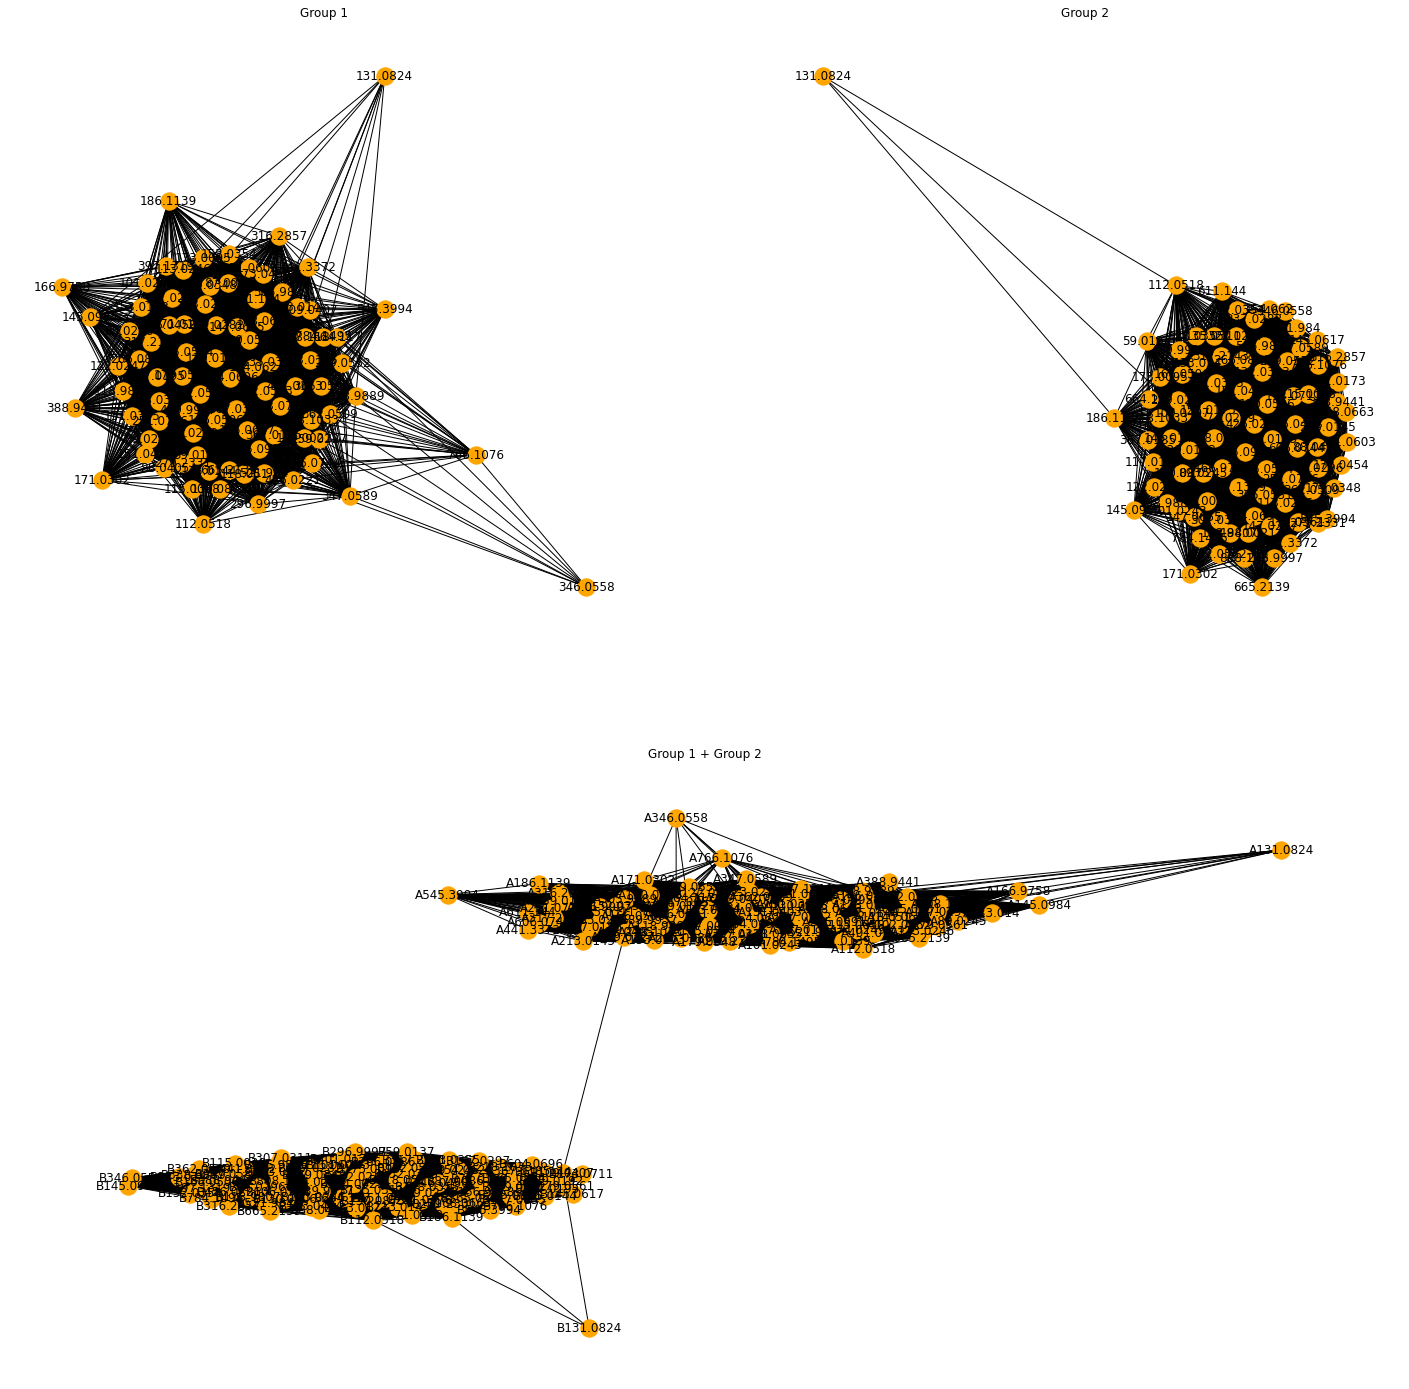

time: 2.85 s (started: 2022-11-12 19:00:44 +00:00)


In [270]:
# Plot graph
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 25))

gs = axes[1, 0].get_gridspec()
# create sub plots as grid
for ax in axes[1, :]:
    ax.remove()

pos = nx.spring_layout(G1)
nx.draw(G1, pos, with_labels=True, node_color="orange", ax=axes[0, 0])
axes[0, 0].set_title("Group 1")

pos = nx.spring_layout(G2)
nx.draw(G2, pos, with_labels=True, node_color="orange", ax=axes[0, 1])
axes[0, 1].set_title("Group 2")

pos = nx.spring_layout(G)
axsbig = fig.add_subplot(gs[1, :])
nx.draw(G, pos, with_labels=True, node_color="orange", ax=axsbig)
axsbig.set_title("Group 1 + Group 2")

#### Info graph

In [271]:
print(nx.info(G1))
print(nx.info(G2))
print(nx.info(G))

Graph with 86 nodes and 3276 edges
Graph with 86 nodes and 3535 edges
Graph with 172 nodes and 6812 edges
time: 5.94 ms (started: 2022-11-12 19:01:13 +00:00)


Graph with 86 nodes and 3276 edges
76.18604651162791


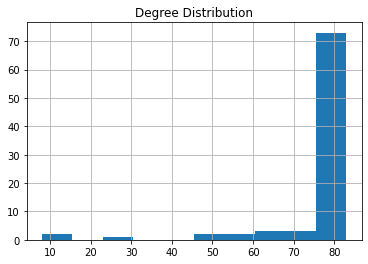

time: 134 ms (started: 2022-11-12 19:01:17 +00:00)


In [272]:
# info_graph(G1)
print(nx.info(G1))
print(np.mean(list(dict(G1.degree()).values())))

plt.clf()
plt.hist(list(dict(G1.degree()).values()))
plt.title("Degree Distribution")
plt.grid()
plt.show()

Graph with 86 nodes and 3535 edges
82.20930232558139


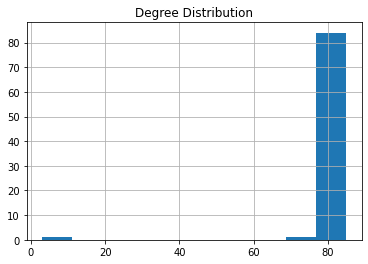

time: 128 ms (started: 2022-11-12 19:01:31 +00:00)


In [273]:
# info_graph(G2)

print(nx.info(G2))
print(np.mean(list(dict(G2.degree()).values())))

plt.clf()
plt.hist(list(dict(G2.degree()).values()))
plt.title("Degree Distribution")
plt.grid()
plt.show()

Graph with 172 nodes and 6812 edges
79.20930232558139


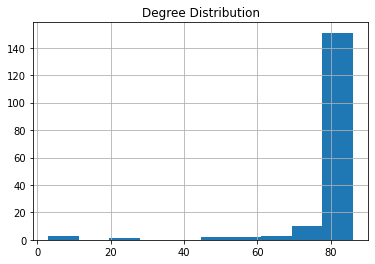

time: 349 ms (started: 2022-11-12 19:01:45 +00:00)


In [274]:
# info_graph(G)

print(nx.info(G))
print(np.mean(list(dict(G.degree()).values())))

plt.clf()
plt.hist(list(dict(G.degree()).values()))
plt.title("Degree Distribution")
plt.grid()
plt.show()

## Graph embedding, Stellar

#### Biased walks

In [ ]:
import random
from functools import partial
from typing import List, Callable

In [ ]:
from networkx.algorithms.shortest_paths import weighted
def _check_value(value, name):
    try:
        _ = 1 / value

    except ZeroDivisionError:
        raise ValueError(
            f"The value of {name} is too small " f"or zero to be used in 1/{name}."
        )


def _undirected(node, graph) -> List[tuple]:
    edges = graph.edges(node)

    return edges


def _directed(node, graph) -> List[tuple]:
    edges = graph.out_edges(node, data=True)

    return edges


def _get_edge_fn(graph) -> Callable:
    fn = _directed if nx.classes.function.is_directed(graph) else _undirected

    fn = partial(fn, graph=graph)
    return fn


def _unweighted(edges: List[tuple]) -> np.ndarray:
    return np.ones(len(edges))


def _weighted(edges: List[tuple]) -> np.ndarray:
    print(edges)
    weights = map(lambda edge: edge[-1]["weight"], edges)

    return np.array([*weights])


def _get_weight_fn(graph) -> Callable:
    fn = _weighted if nx.classes.function.is_weighted(graph) else _unweighted

    return fn


class BiasedRandomWalker:
    """
    Class to do biased second order random walks.
    Args:
        walk_length (int): Number of random walks.
        walk_number (int): Number of nodes in truncated walk.
        p (float): Return parameter (1/p transition probability) to move towards previous node.
        q (float): In-out parameter (1/q transition probability) to move away from previous node.
    """

    walks: list
    graph: nx.classes.graph.Graph
    edge_fn: Callable
    weight_fn: Callable

    def __init__(self, walk_length: int, walk_number: int, p: float, q: float):
        self.walk_length = walk_length
        self.walk_number = walk_number

        _check_value(p, "p")
        self.p = p

        _check_value(q, "q")
        self.q = q

    def do_walk(self, node: int) -> List[str]:
        """
        Doing a single truncated second order random walk from a source node.
        Arg types:
            * **node** *(int)* - The source node of the random walk.
        Return types:
            * **walk** *(list of strings)* - A single truncated random walk.
        """
        walk = [node]
        previous_node = None
        previous_node_neighbors = []
        for _ in range(self.walk_length - 1):
            current_node = walk[-1]
            edges = self.edge_fn(current_node)
            # print(edges)
            current_node_neighbors = np.array([edge[1] for edge in edges])

            weights = []
            for item in edges:
              weights.append(self.graph.get_edge_data(*item)["weight"])
            
            # weights = list(self.graph.edges(data=True)) # self.weight_fn(edges)

            # print("weights", weights)
            probability = np.piecewise(
                weights,
                [
                    current_node_neighbors == previous_node,
                    np.isin(current_node_neighbors, previous_node_neighbors),
                ],
                [lambda w: w / self.p, lambda w: w / 1, lambda w: w / self.q],
            )
            # print("probability", probability)
            probability = abs(probability)
            # print("probability", probability)
            # print("sum(probability)", sum(probability))
            norm_probability = probability / sum(probability)
            # print("norm_probability", norm_probability)
            # print("current_node_neighbors", current_node_neighbors)
            selected = np.random.choice(current_node_neighbors, 1, p=norm_probability)[0]
            # print("selected", selected)
            walk.append(selected)

            previous_node_neighbors = current_node_neighbors
            previous_node = current_node

        walk = [str(w) for w in walk]
        return walk

    def do_walks(self, graph):
        """
        Doing a fixed number of truncated random walk from every node in the graph.
        Arg types:
            * **graph** *(NetworkX graph)* - The graph to run the random walks on.
        """
        self.walks = []
        self.graph = graph

        self.edge_fn = _get_edge_fn(graph)
        self.weight_fn = _get_weight_fn(graph)

        for node in self.graph.nodes():
            for _ in range(self.walk_number):
                walk_from_node = self.do_walk(node)
                self.walks.append(walk_from_node)
        return self.walks

#### Deepwalk

In [ ]:
# Parameters
length = 16 # maximum length of a random walk
n = 16 # number of random walks per root node

In [ ]:
Gs1 = StellarGraph.from_networkx(G1)
rw = UniformRandomWalk(Gs1)

walk_paths1 = rw.run(
    nodes=list(Gs1.nodes()),  # root nodes
    length=length,  # maximum length of a random walk
    n=n,  # number of random walks per root node
    seed=42 #  random number generator seed; default is None
)
print("Number of random walks: {}".format(len(walk_paths1)))
# walk_paths1[:10]

In [ ]:
Gs2 = StellarGraph.from_networkx(G2)
rw = UniformRandomWalk(Gs2)

walk_paths2 = rw.run(
    nodes=list(Gs2.nodes()),  # root nodes
    length=length,  # maximum length of a random walk
    n=n,  # number of random walks per root node
    seed=42 #  random number generator seed; default is None
)
print("Number of random walks: {}".format(len(walk_paths2)))
# walk_paths2[:5]

In [ ]:
Gs3 = StellarGraph.from_networkx(G3)
rw = UniformRandomWalk(Gs3)

walk_paths3 = rw.run(
    nodes=list(Gs3.nodes()),  # root nodes
    length=length,  # maximum length of a random walk
    n=n,  # number of random walks per root node
    seed=42 #  random number generator seed; default is None
)
print("Number of random walks: {}".format(len(walk_paths3)))
# walk_paths3[:10]

In [ ]:
Gs4 = StellarGraph.from_networkx(G4)
rw = UniformRandomWalk(Gs4)

walk_paths4 = rw.run(
    nodes=list(Gs4.nodes()),  # root nodes
    length=length,  # maximum length of a random walk
    n=n,  # number of random walks per root node
    seed=42 #  random number generator seed; default is None
)
print("Number of random walks: {}".format(len(walk_paths4)))
# walk_paths4[:10]

#### Node2vec

In [ ]:
# Parameters
length = 32 # maximum length of a random walk
n = 32 # number of random walks per root node
p = 1.0 # 1.0 # 1.0 # 0.5 # Defines (unormalised) probability, 1/p, of returning to source node
q = 2.0 # 2.0 # 0.5 # 2.0 # Defines (unormalised) probability, 1/q, for moving away from source node

In [ ]:
Gs1 = StellarGraph.from_networkx(G1)
rw = BiasedRandomWalk(Gs1)

walk_paths1 = rw.run(
    nodes=Gs1.nodes(),  # root nodes
    length=length,  # maximum length of a random walk
    n=n,  # number of random walks per root node
    p=p,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=q,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42  #  random number generator seed; default is None
)
print("Number of random walks: {}".format(len(walk_paths1)))
# walk_paths1[:1]

In [ ]:
Gs2 = StellarGraph.from_networkx(G2)
rw = BiasedRandomWalk(Gs2)

walk_paths2 = rw.run(
    nodes=Gs2.nodes(),  # root nodes
    length=length,  # maximum length of a random walk
    n=n,  # number of random walks per root node
    p=p,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=q,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42  #  random number generator seed; default is None
)
print("Number of random walks: {}".format(len(walk_paths2)))
# walk_paths2[:10]

In [ ]:
""" Gs3 = StellarGraph.from_networkx(G3)
rw = BiasedRandomWalk(Gs3)

walk_paths3 = rw.run(
    nodes=Gs3.nodes(),  # root nodes
    length=length,  # maximum length of a random walk
    n=n,  # number of random walks per root node
    p=p,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=q,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42  #  random number generator seed; default is None
)
print("Number of random walks: {}".format(len(walk_paths3)))
# walk_paths3[:10] """

In [ ]:
""" Gs4 = StellarGraph.from_networkx(G4)
rw = BiasedRandomWalk(Gs4)

walk_paths4 = rw.run(
    nodes=Gs4.nodes(),  # root nodes
    length=length,  # maximum length of a random walk
    n=n,  # number of random walks per root node
    p=p,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=q,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42  #  random number generator seed; default is None
)
print("Number of random walks: {}".format(len(walk_paths4)))
# walk_paths4[:10] """

##### Random walks biased

In [ ]:
rw1 = BiasedRandomWalker(walk_length=length, walk_number=n, p=p, q=q)
walk_paths1 = rw1.do_walks(G1)

In [ ]:
rw2 = BiasedRandomWalker(walk_length=length, walk_number=n, p=p, q=q)
walk_paths2 = rw1.do_walks(G2)

In [ ]:
rw3 = BiasedRandomWalker(walk_length=length, walk_number=n, p=p, q=q)
walk_paths3 = rw1.do_walks(G3)

In [ ]:
rw4 = BiasedRandomWalker(walk_length=length, walk_number=n, p=p, q=q)
walk_paths4 = rw1.do_walks(G4)

#### Word2vec

In [ ]:
# Train
size = 32
walk_paths1 = [[str(n) for n in walk] for walk in walk_paths1]
model1 = Word2Vec(sentences=walk_paths1, vector_size=size, window=5, min_count=0,
                  seed=42, workers=2, sg=1, hs=0, epochs=20)
print(model1)

walk_paths2 = [[str(n) for n in walk] for walk in walk_paths2]
model2 = Word2Vec(sentences=walk_paths2, vector_size=size, window=5, min_count=0,
                  seed=42, workers=2, sg=1, hs=0, epochs=20)
print(model2)

""" walk_paths3 = [[str(n) for n in walk] for walk in walk_paths3]
model3 = Word2Vec(sentences=walk_paths3, vector_size=size, window=5, min_count=0,
                  seed=42, workers=2, sg=1, hs=0, epochs=20)
print(model3)

walk_paths4 = [[str(n) for n in walk] for walk in walk_paths4]
model4 = Word2Vec(sentences=walk_paths4, vector_size=size, window=5, min_count=0,
                  seed=42, workers=2, sg=1, hs=0, epochs=20)
print(model4) """

In [ ]:
# Get embedding
node_ids1 = model1.wv.index_to_key  # list of node IDs
node_embeddings1 = pd.DataFrame(model1.wv.vectors, index=node_ids1)
print(node_embeddings1.shape)
node_embeddings1.head()

In [ ]:
# Get embedding
node_ids2 = model2.wv.index_to_key  # list of node IDs
node_embeddings2 = pd.DataFrame(model2.wv.vectors, index=node_ids2)
print(node_embeddings2.shape)
node_embeddings2.head()

In [ ]:
""" # Get embedding
node_ids3 = model3.wv.index_to_key  # list of node IDs
node_embeddings3 = pd.DataFrame(model3.wv.vectors, index=node_ids3)
print(node_embeddings3.shape)
node_embeddings3.head() """

In [ ]:
""" # Get embedding
node_ids4 = model4.wv.index_to_key  # list of node IDs
node_embeddings4 = pd.DataFrame(model4.wv.vectors, index=node_ids4)
print(node_embeddings4.shape)
node_embeddings4.head() """



---

##### Test similarity

In [ ]:
# sims = model1.wv.most_similar('288', topn=10)  # get other similar words
# sims

In [ ]:
node_id = "259.0227"

In [ ]:
model4.wv.get_vector(node_id, norm=False)

In [ ]:
model4.wv.get_normed_vectors()

In [ ]:
model4.wv.get_vector(node_id, norm=True)

In [ ]:
model4.wv.key_to_index[node_id]

In [ ]:
x = model4.wv.get_vector("154.062", norm=False)
y = model4.wv.get_vector("128.0355", norm=False)

print(x.shape)
print(y.shape)

In [ ]:
x

In [ ]:
y

In [ ]:
# Get similarity
model4.wv.similarity("154.062", "128.0355")

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([x], [y])

In [ ]:
from sklearn.metrics.pairwise import pairwise_kernels

pairwise_kernels([x], [y], metric="cosine")

In [ ]:
# Save
node_embeddings1.to_csv("{}/Outputs/MatrixEmbedding/node_embeddings1_05.csv".format(dir), index=True)
node_embeddings2.to_csv("{}/Outputs/MatrixEmbedding/node_embeddings2_05.csv".format(dir), index=True)
node_embeddings3.to_csv("{}/Outputs/MatrixEmbedding/node_embeddings3_05.csv".format(dir), index=True)
node_embeddings4.to_csv("{}/Outputs/MatrixEmbedding/node_embeddings4_05.csv".format(dir), index=True)

In [ ]:
# Read
""" node_embeddings1 = pd.read_csv("{}/Outputs/MatrixEmbedding/node_embeddings1.csv".format(dir), index_col="Unnamed: 0")
node_embeddings2 = pd.read_csv("{}/Outputs/MatrixEmbedding/node_embeddings2.csv".format(dir), index_col="Unnamed: 0")
node_embeddings3 = pd.read_csv("{}/Outputs/MatrixEmbedding/node_embeddings3.csv".format(dir), index_col="Unnamed: 0")
node_embeddings4 = pd.read_csv("{}/Outputs/MatrixEmbedding/node_embeddings4.csv".format(dir), index_col="Unnamed: 0") """

##### Draw embeddings

In [ ]:
import plotly.express as px
df = px.data.tips()
fig = px.density_heatmap(node_embeddings1, title="No color bar on this density plot")

fig.update_layout(coloraxis_showscale=False)

fig.show()

In [ ]:
df = px.data.tips()
fig = px.density_heatmap(node_embeddings2, title="No color bar on this density plot")

fig.update_layout(coloraxis_showscale=False)

fig.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

fig = make_subplots(1, 2, horizontal_spacing=0.15)
fig.add_trace(go.Heatmap(z=node_embeddings1,
                         x=node_embeddings1.columns,
                         y=node_embeddings1.index,
                         coloraxis="coloraxis"), 1, 1)
fig.add_trace(go.Heatmap(z=node_embeddings2,
                         x=node_embeddings2.columns,
                         y=node_embeddings2.index,
                         coloraxis="coloraxis"), 1, 2)

fig.update_layout(width=1000, height=800, title_text="Embeddings Matrix",
                  showlegend=False, coloraxis={"colorscale": "Rainbow"})
fig.update_xaxes(side="top")
fig.show()

In [ ]:
# sns.heatmap(node_embeddings1, annot=True)

import plotly.express as px
fig = px.imshow(node_embeddings1.values,
                text_auto=False, 
                x=node_embeddings1.columns.values,
                y=node_embeddings1.index,
                color_continuous_scale="Rainbow")
fig.layout.height = 700
fig.layout.width = 700
fig.update_xaxes(side="top")
fig.show()

In [ ]:
fig = px.imshow(node_embeddings2.values,
                text_auto=False, 
                x=node_embeddings2.columns.values,
                y=node_embeddings2.index,
                color_continuous_scale="Rainbow")
fig.layout.height = 700
fig.layout.width = 700
fig.update_xaxes(side="top")
fig.show()

## Graph embedding, Shenweichen

In [275]:
import tensorflow as tf
print(tf.__version__)

1.14.0
time: 1.03 ms (started: 2022-11-12 19:03:04 +00:00)


In [276]:
import numpy
numpy.version.version

'1.21.6'

time: 3.48 ms (started: 2022-11-12 19:03:05 +00:00)


In [277]:
# Parameters
length = 32 # maximum length of a random walk
n = 32 # number of random walks per root node
p = 1.0 # 1.0 # 1.0 # 0.5 # Defines (unormalised) probability, 1/p, of returning to source node
q = 2.0 # 2.0 # 0.5 # 2.0 # Defines (unormalised) probability, 1/q, for moving away from source node
size = 32
epochs = 100

time: 1.09 ms (started: 2022-11-12 19:03:07 +00:00)


#### DeepWalk

In [ ]:
model1 = DeepWalk(G1, walk_length=length, num_walks=n, workers=1)
model1.train(embed_size=size, window_size=5, iter=epochs)
node_embeddings1 = model1.get_embeddings()
node_embeddings1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Learning embedding vectors...
Learning embedding vectors done!


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
135.0311,-0.146420,-0.054914,-0.054503,-0.013412,0.055946,0.104107,0.180217,0.259498,-0.103874,0.000929,...,0.189263,0.237890,-0.083084,0.032653,-0.107553,0.024162,-0.024683,-0.137341,-0.000747,0.142922
173.0711,-0.109981,-0.053183,0.184933,-0.022493,0.073011,-0.008277,0.147420,0.115088,-0.227009,0.102187,...,-0.013738,0.293330,0.183240,0.141473,-0.054713,0.046591,0.179880,-0.099947,-0.071552,0.026625
154.062,-0.315016,-0.277622,0.068644,0.073223,-0.070003,0.147556,0.149815,0.172095,-0.266643,0.088495,...,0.184283,0.123635,0.101641,0.001874,-0.140379,-0.213369,0.034534,-0.113997,-0.198544,0.024236
505.9889,-0.253110,-0.060392,0.048722,-0.089073,0.024017,0.055661,0.214078,0.017604,-0.156306,0.014258,...,0.243227,0.256761,-0.021669,0.004006,-0.236599,0.065904,0.045357,-0.026963,0.025552,0.173279
132.0303,-0.135921,-0.302824,0.164848,0.030849,0.013374,0.102765,-0.031866,0.288507,-0.102826,-0.082251,...,0.010315,0.246984,-0.034282,-0.052481,-0.192310,-0.110345,0.014385,-0.008117,-0.200227,0.141776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545.3994,-0.016961,0.011795,0.035740,0.092576,-0.045269,0.161786,0.080061,0.079012,-0.234756,0.170584,...,0.154047,0.065405,0.108135,-0.078854,0.005311,-0.148287,-0.025562,-0.093487,0.257553,0.290858
166.9758,-0.161404,-0.029137,0.250375,0.022753,0.175935,0.054399,0.175968,0.252101,0.017478,-0.001567,...,0.025208,0.046754,0.058183,0.205927,0.060098,-0.135596,0.159358,0.084324,-0.040396,-0.090246
766.1076,-0.055221,-0.280647,0.082264,-0.034871,-0.251667,-0.089075,-0.120415,0.011877,-0.387440,-0.014049,...,-0.200951,0.102073,0.246658,0.297495,-0.214608,0.230432,0.301542,-0.569576,0.296117,0.318002
131.0824,-0.402026,-0.025466,0.146894,-0.456354,0.132177,-0.050600,-0.113343,0.053205,-0.208273,0.230635,...,-0.233780,0.323681,-0.121073,-0.213318,0.339509,-0.615873,0.846932,-0.197334,0.198297,-0.261687


time: 5.69 s (started: 2022-11-08 18:53:13 +00:00)


In [ ]:
model2 = DeepWalk(G2, walk_length=length, num_walks=n, workers=1)
model2.train(embed_size=size, window_size=5, iter=epochs)
node_embeddings2 = model2.get_embeddings()
node_embeddings2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Learning embedding vectors...
Learning embedding vectors done!


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
113.0246,-0.146646,-0.020410,-0.016870,0.004637,0.021232,-0.218920,0.138293,0.122715,-0.029775,0.057123,...,0.138397,-0.060447,-0.199349,0.072979,-0.188454,-0.048555,-0.010854,-0.074452,-0.057748,0.203431
604.0696,-0.173414,-0.154125,-0.018251,0.088511,0.003073,0.023720,0.083800,0.236287,-0.158464,-0.081126,...,0.253251,-0.032719,0.049322,-0.111994,-0.086167,0.023657,0.099567,-0.059211,-0.130537,0.139653
441.3372,-0.024094,-0.006499,0.175709,0.061618,0.031999,-0.092571,0.007125,-0.012443,0.032772,-0.081685,...,0.237980,0.052401,0.038925,0.075152,-0.053616,0.096607,0.146497,-0.083949,-0.170597,0.110987
118.051,-0.074539,-0.276850,0.126049,0.055173,0.044025,-0.074333,0.126182,0.163086,-0.047820,0.072042,...,0.170008,-0.007513,-0.061620,-0.076177,-0.141606,0.018625,0.014411,-0.222777,-0.030762,0.138276
784.1495,-0.011439,-0.254102,0.008813,-0.146008,0.062759,0.026554,0.197973,0.015648,-0.147112,0.060646,...,0.211840,0.089949,-0.009796,-0.069646,-0.257688,0.083228,0.037429,-0.087930,0.046647,0.159771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218.1033,0.085972,-0.026072,0.166445,0.116953,0.031735,-0.051953,0.029683,0.141785,0.049228,-0.018201,...,0.368561,-0.034754,0.058541,0.053484,-0.090655,-0.026798,-0.051804,-0.134038,-0.050440,0.041641
112.0518,-0.234938,-0.161839,-0.005393,0.135369,-0.060316,-0.204938,0.473965,0.238714,-0.130683,0.163877,...,0.180970,0.086366,-0.039641,0.185021,-0.326965,-0.028240,-0.005882,-0.232078,-0.180100,0.184548
346.0558,0.066295,-0.087852,-0.008902,0.225113,0.160622,-0.199053,0.154896,0.160004,-0.083338,0.063435,...,0.000056,0.019531,0.137488,-0.045124,-0.289881,-0.061145,-0.008266,-0.266550,-0.146519,0.327470
145.0984,0.099841,0.019422,0.107820,0.268786,0.140502,-0.027360,0.146270,0.213556,-0.179799,0.032471,...,0.280396,-0.222472,0.036182,0.178447,-0.119986,-0.036877,0.105765,0.039598,0.044298,0.156541


time: 5.14 s (started: 2022-11-08 18:53:19 +00:00)


In [ ]:
model = DeepWalk(G, walk_length=length, num_walks=n, workers=1)
model.train(embed_size=size, window_size=5, iter=epochs)
node_embeddings = model.get_embeddings()
node_embeddings

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Learning embedding vectors...
Learning embedding vectors done!


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
A259.0227,0.467595,-0.198633,0.206822,-0.120296,0.280994,-0.307601,0.579352,0.211806,-0.519395,-0.067671,...,0.604978,-0.161608,0.374980,0.053314,-0.433186,0.138975,-0.083277,-0.384384,-0.094289,0.199505
A173.0454,0.283833,-0.050627,0.320102,0.004206,0.213313,-0.304769,0.478291,0.290792,-0.476360,0.124684,...,0.604805,-0.014807,0.369185,0.394029,-0.653452,0.127137,0.052058,-0.411285,0.001437,0.333232
A152.0354,0.505562,0.006986,0.307342,-0.100113,0.338077,-0.264633,0.558783,0.040658,-0.391049,0.112476,...,0.465609,0.074196,0.353510,0.371447,-0.561226,0.161826,0.031761,-0.353961,0.188265,0.255689
A604.0696,0.345890,-0.092589,0.100046,-0.129252,0.274515,-0.205268,0.531171,0.150331,-0.564928,-0.126393,...,0.496703,-0.197490,0.140471,0.236628,-0.787836,0.030676,0.109531,-0.498251,0.114143,0.402414
A365.0531,0.359423,-0.025166,0.260977,-0.263760,0.348631,-0.250341,0.520291,0.165484,-0.443374,0.040596,...,0.622219,-0.050958,-0.039106,0.321941,-0.765194,-0.045816,0.025381,-0.433959,0.253591,0.378270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A545.3994,0.511373,0.281628,0.455894,-0.095456,0.085013,-0.475304,0.381172,0.305206,-0.716523,0.338219,...,0.528865,0.280551,0.259803,0.256854,-0.892485,-0.142622,0.065119,-0.285785,0.200986,0.025796
A766.1076,1.095279,-0.319390,0.559328,-0.215232,0.300488,-0.428346,0.098286,0.701789,-0.691615,-0.154804,...,0.330188,0.189072,0.393072,-0.137778,-0.431310,-0.227461,-0.434368,-0.104200,0.276059,0.235122
A131.0824,0.404838,-0.939931,0.090138,0.901990,-0.005401,-0.773719,0.328486,-0.544919,-0.166846,-0.098204,...,0.749153,-0.185186,0.255520,0.328814,-0.665946,-0.387186,-0.669554,-0.526116,0.471832,0.953045
A346.0558,0.866347,0.104562,-0.234585,-0.301606,0.245479,-0.658468,0.429683,0.904982,0.502859,-0.287144,...,-0.039392,0.450282,0.114340,-0.273059,-1.145400,0.390155,-0.007396,-0.648829,0.134801,0.979658


time: 11 s (started: 2022-11-08 18:53:24 +00:00)


#### LINE

In [ ]:
model1 = LINE(G1, embedding_size=size, order="second") # init model,order can be ['first','second','all']
model1.train(batch_size=1024, epochs=epochs, verbose=0)
node_embeddings1 = model1.get_embeddings()
node_embeddings1

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
59.0137,0.193940,-0.184734,0.242717,0.220617,-0.219477,-0.223877,0.256849,-0.237269,0.241372,0.236809,...,-0.242489,-0.199458,0.243945,0.252169,-0.230011,-0.216191,0.247656,0.186458,0.250212,0.254574
71.0139,0.257739,-0.192060,0.177808,0.258165,-0.240190,-0.201369,0.260320,-0.192495,0.215474,0.248031,...,-0.191665,-0.208513,0.262082,0.229638,-0.205712,-0.204320,0.203992,0.230286,0.256675,0.260927
74.0249,0.237094,-0.231708,0.221094,0.235250,-0.235488,-0.233390,0.249641,-0.232131,0.256648,0.234679,...,-0.228256,-0.258997,0.201864,0.232874,-0.168501,-0.259025,0.193020,0.191698,0.240695,0.188987
85.0296,0.226524,-0.241395,0.270830,0.191593,-0.244473,-0.267906,0.237777,-0.194294,0.214518,0.188303,...,-0.266230,-0.191617,0.220612,0.205342,-0.192323,-0.223615,0.237260,0.211250,0.266620,0.176918
87.0086,0.247149,-0.199726,0.175906,0.265180,-0.206204,-0.247805,0.189276,-0.234746,0.269215,0.184931,...,-0.267547,-0.267556,0.225563,0.208267,-0.255132,-0.236796,0.249026,0.250407,0.276454,0.261568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186.1139,0.041477,0.039894,-0.022404,0.013145,-0.013888,0.013905,-0.003012,0.004105,-0.036246,0.030530,...,0.008260,-0.009106,0.011170,-0.034251,-0.037124,0.044011,-0.043113,-0.047739,0.033220,0.046712
808.118,0.268870,-0.233295,0.207649,0.287358,-0.287342,-0.235136,0.302624,-0.190042,0.278206,0.236449,...,-0.275154,-0.230260,0.317337,0.288098,-0.226455,-0.243080,0.250494,0.221756,0.216289,0.227958
766.1076,0.147994,-0.181669,0.229599,0.174460,-0.208637,-0.243636,0.180650,-0.215498,0.237137,0.222102,...,-0.215068,-0.193341,0.209744,0.136561,-0.218683,-0.131463,0.219144,0.142008,0.191822,0.158337
131.0824,-0.034968,0.045315,-0.026183,0.017335,0.036373,-0.005983,-0.029724,-0.021963,-0.027294,-0.043943,...,0.003484,0.033406,0.010111,-0.031617,0.038827,-0.032558,-0.026866,-0.036394,0.042541,0.036615


time: 2.12 s (started: 2022-11-11 13:51:17 +00:00)


In [ ]:
model2 = LINE(G2, embedding_size=size, order="second") # init model,order can be ['first','second','all']
model2.train(batch_size=1024, epochs=epochs, verbose=0)
node_embeddings2 = model2.get_embeddings()
node_embeddings2

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
59.0137,-0.171214,-0.208583,-0.204661,-0.226419,0.176741,0.189368,-0.180488,0.220515,-0.249295,-0.187785,...,-0.206207,0.181663,-0.209497,0.172339,-0.217914,0.171848,-0.260924,-0.235876,-0.165929,0.224220
71.0139,-0.236094,-0.212339,-0.195376,-0.203947,0.256726,0.271177,-0.249247,0.249045,-0.254327,-0.204203,...,-0.232126,0.181028,-0.247402,0.148331,-0.249274,0.216953,-0.247555,-0.257944,-0.198147,0.260788
74.0249,-0.189968,-0.209089,-0.253446,-0.277572,0.219644,0.268384,-0.165310,0.241152,-0.266829,-0.237660,...,-0.187937,0.206518,-0.244414,0.144219,-0.264324,0.215004,-0.198576,-0.228206,-0.228034,0.186273
85.0296,-0.178420,-0.246091,-0.182928,-0.264821,0.273955,0.192068,-0.259385,0.194407,-0.225273,-0.266296,...,-0.182730,0.177699,-0.256896,0.214612,-0.249284,0.209338,-0.202160,-0.269794,-0.159800,0.176809
87.0086,-0.261828,-0.220197,-0.210048,-0.221900,0.241557,0.228985,-0.242968,0.248468,-0.250263,-0.266630,...,-0.258216,0.240034,-0.236573,0.197628,-0.172721,0.234943,-0.210602,-0.245915,-0.216126,0.227717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186.1139,-0.257708,-0.315877,-0.331900,-0.310361,0.348512,0.302694,-0.302210,0.212290,-0.272383,-0.284586,...,-0.360230,0.216066,-0.297677,0.257248,-0.365430,0.288157,-0.352474,-0.358446,-0.300776,0.307703
316.2857,-0.286928,-0.251508,-0.232382,-0.295974,0.245064,0.234487,-0.293726,0.205120,-0.274224,-0.235754,...,-0.309034,0.181758,-0.265930,0.243531,-0.303955,0.214793,-0.282307,-0.282985,-0.188312,0.225525
545.3994,-0.190661,-0.188077,-0.217485,-0.201387,0.167193,0.218468,-0.165304,0.171319,-0.227593,-0.141426,...,-0.162777,0.202632,-0.237294,0.221253,-0.264417,0.170178,-0.222607,-0.199925,-0.159986,0.178091
611.144,0.015816,-0.037391,0.009745,0.002873,0.040010,0.042700,-0.042584,-0.038096,-0.011946,-0.024104,...,-0.048208,0.045978,-0.027968,-0.022217,0.031732,0.018144,0.003632,-0.041924,0.010433,-0.024008


time: 2.81 s (started: 2022-11-11 13:51:19 +00:00)


In [ ]:
model = LINE(G, embedding_size=size, order="second") # init model,order can be ['first','second','all']
model.train(batch_size=1024, epochs=epochs, verbose=0)
node_embeddings = model.get_embeddings()
node_embeddings

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
A59.0137,0.226223,0.260679,0.244062,0.275428,0.182768,0.209304,-0.137452,-0.120702,0.213611,0.307309,...,0.225031,-0.113723,-0.164943,0.207809,-0.208981,0.211690,-0.178703,0.273384,0.130347,-0.422235
A71.0139,0.193083,0.268827,0.267231,0.302717,0.168848,0.277528,-0.144174,-0.166488,0.253154,0.325015,...,0.196894,-0.110938,-0.181676,0.236776,-0.222299,0.265797,-0.193994,0.244608,0.122332,-0.398389
A74.0249,0.190891,0.234436,0.174194,0.305705,0.229049,0.268298,-0.102185,-0.151889,0.220321,0.319126,...,0.183821,-0.174764,-0.158833,0.250597,-0.265651,0.159828,-0.233806,0.200400,0.188457,-0.409102
A85.0296,0.206855,0.276745,0.209753,0.304861,0.237518,0.198761,-0.121839,-0.217533,0.236553,0.371632,...,0.197749,-0.111331,-0.144542,0.228289,-0.194539,0.184949,-0.237703,0.283191,0.185483,-0.422865
A87.0086,0.182162,0.265138,0.233932,0.271873,0.198955,0.207872,-0.151562,-0.196555,0.266377,0.354683,...,0.208650,-0.144639,-0.129482,0.242257,-0.256095,0.204001,-0.190909,0.250660,0.159767,-0.473804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B186.1139,0.310989,0.309105,0.378997,0.351245,0.373269,0.327662,-0.353652,-0.399579,0.328489,0.262397,...,0.374364,-0.415561,-0.397725,0.387209,-0.321759,0.336808,-0.407170,0.428849,0.319069,-0.288700
B316.2857,0.276936,0.308728,0.288172,0.270610,0.347822,0.327814,-0.295690,-0.374982,0.271980,0.271510,...,0.279599,-0.344390,-0.325973,0.311887,-0.334245,0.319942,-0.258908,0.296041,0.319575,-0.269011
B545.3994,0.208522,0.205461,0.235477,0.291027,0.283301,0.207686,-0.257044,-0.248028,0.223675,0.218223,...,0.296156,-0.260954,-0.243476,0.262949,-0.220932,0.200974,-0.284877,0.255684,0.232712,-0.201767
B611.144,-0.011227,0.029806,0.009682,0.028845,-0.003356,0.047068,0.004831,0.014902,0.003712,-0.044912,...,0.023179,-0.032116,-0.035753,-0.049364,-0.022620,0.025011,-0.031252,0.021011,0.024197,-0.041281


time: 4.2 s (started: 2022-11-11 13:51:22 +00:00)


#### Node2vec

In [ ]:
model1 = Node2Vec(G1, walk_length=length, num_walks=n, p=p, q=q, workers=1)
model1.train(embed_size=size, window_size=5, iter=epochs)
node_embeddings1 = model1.get_embeddings()
node_embeddings1

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Learning embedding vectors...
Learning embedding vectors done!


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
146.0458,0.091673,-0.111169,-0.106258,0.010172,0.191406,-0.095077,0.174481,-0.072616,-0.049313,0.025608,...,0.291086,0.007028,0.077862,0.145487,-0.121359,0.056403,0.139174,-0.084676,-0.070154,0.191814
130.0875,-0.118019,-0.258331,0.144857,0.061945,0.080243,-0.006337,0.229854,0.097626,0.073722,-0.099669,...,0.209287,0.089187,0.141533,0.183776,-0.128582,-0.031246,0.011707,-0.127235,0.008161,0.138524
128.0355,0.027681,-0.160671,0.161629,-0.036354,0.200769,0.109005,0.335584,0.138975,0.047633,0.070827,...,0.188684,0.097410,0.208783,0.011613,-0.100469,0.106315,0.113723,-0.132383,0.049053,0.048359
154.062,-0.069118,-0.227063,-0.106682,-0.058420,0.125797,0.132798,0.158137,-0.121426,-0.000257,0.080540,...,0.222190,0.100954,0.071976,0.125221,-0.069059,0.001577,0.124766,0.004981,-0.123238,0.060319
129.0192,-0.100579,-0.194032,0.281828,0.031816,0.227650,0.212634,0.221653,0.102449,-0.001222,0.075705,...,0.439705,0.087575,0.009113,0.068649,-0.061332,0.008488,0.096202,-0.274943,-0.059078,0.038666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545.3994,-0.095405,-0.252469,0.181975,0.240380,-0.003141,0.143947,0.281387,0.474913,-0.104404,0.030758,...,0.038776,0.062441,0.109658,-0.159239,0.113278,0.335969,0.277972,0.018210,0.092495,0.075548
166.9758,-0.117471,-0.436283,0.219359,0.053288,-0.036796,0.264391,0.165380,0.166724,0.105293,0.129089,...,0.175051,0.191150,0.352207,0.053478,0.058735,0.136613,0.144201,-0.224174,-0.193782,0.127029
766.1076,-0.468508,-0.094047,-0.288035,-0.006741,-0.143588,-0.225669,0.337551,0.137033,-0.702572,0.285937,...,-0.053684,0.273624,-0.060284,0.443753,-0.025308,0.409802,-0.159348,-0.524209,0.190599,-0.101647
131.0824,-0.072064,-0.571362,-0.215694,-0.579011,0.315663,-0.360504,-0.327287,0.318446,-0.122545,0.036759,...,0.872848,-0.299720,0.180348,-0.169679,-0.600554,-0.137286,0.174528,-0.204338,-0.167261,0.264729


time: 4.27 s (started: 2022-11-08 23:54:27 +00:00)


In [ ]:
model2 = Node2Vec(G2, walk_length=length, num_walks=n, p=p, q=q, workers=1)
model2.train(embed_size=size, window_size=5, iter=epochs)
node_embeddings2 = model2.get_embeddings()
node_embeddings2

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Learning embedding vectors...
Learning embedding vectors done!


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
179.0561,-0.126455,-0.228880,0.029525,-0.149569,-0.020007,0.151133,0.162525,0.246457,0.127317,0.038983,...,0.358093,0.246630,0.126336,0.016106,0.107772,-0.091996,-0.066190,-0.188034,0.067434,0.068705
132.0303,-0.074857,-0.199095,0.118515,0.033788,0.137131,0.080822,0.133775,0.047893,-0.080936,-0.019798,...,0.263768,0.051977,0.038834,0.035041,-0.244959,0.078689,-0.066913,-0.275111,-0.123242,0.050069
237.0282,-0.138777,-0.066441,-0.024595,-0.016578,-0.046188,0.168820,0.194013,0.157076,0.072615,0.119916,...,0.136633,0.047110,0.117393,0.057433,-0.261847,-0.097391,0.150340,-0.228248,-0.125908,0.145403
85.0296,0.014620,-0.224529,0.101228,0.028862,0.085341,0.158019,0.156065,0.144980,0.069286,-0.198636,...,0.213154,0.064643,0.175299,0.085604,-0.095496,-0.098665,0.163989,-0.143681,-0.275989,0.133576
88.0405,0.026739,-0.279388,0.182614,-0.053256,0.247689,0.062051,0.163931,0.047520,-0.006461,0.016521,...,0.199821,0.129318,0.108696,0.110249,0.006159,-0.006286,0.062881,-0.268323,0.005835,0.072105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665.2139,-0.193851,-0.223140,0.154377,-0.006851,0.147914,0.036620,0.027170,0.190723,-0.093714,0.033942,...,-0.024947,0.248362,0.047758,-0.007085,-0.261636,0.212531,0.003423,-0.252250,-0.090215,0.124622
171.0302,-0.273388,-0.207562,-0.087489,0.029298,0.028561,0.126253,0.320753,0.179304,0.015454,0.007520,...,0.265972,0.135502,0.226569,-0.094650,-0.036891,0.023935,-0.161702,-0.264434,0.015123,0.129617
112.0518,-0.190617,-0.129465,0.108757,-0.261322,-0.054078,-0.348042,-0.202100,0.129365,-0.359696,0.080130,...,0.066973,0.025148,0.256768,0.113003,-0.358473,0.000526,0.004467,-0.421908,0.023793,0.464730
186.1139,-0.006752,-0.099953,0.173560,-0.343112,0.077011,-0.334177,-0.353581,0.090078,-0.151538,-0.129844,...,0.302354,0.103937,0.181136,0.096357,-0.105851,-0.027269,-0.047320,-0.680412,-0.185551,0.253454


time: 4.53 s (started: 2022-11-08 23:54:31 +00:00)


In [ ]:
model = Node2Vec(G, walk_length=length, num_walks=n, p=p, q=q, workers=1)
model.train(embed_size=size, window_size=5, iter=epochs)
node_embeddings = model.get_embeddings()
node_embeddings

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


Learning embedding vectors...
Learning embedding vectors done!


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
A145.0617,-0.144160,-0.234891,0.279618,0.234671,0.029663,-0.187104,0.581378,-0.166816,-0.101836,-0.170053,...,0.597360,-0.147487,0.259250,0.348166,-0.493721,0.292134,0.013709,-0.075379,-0.094836,-0.343466
A323.0277,0.101457,-0.399077,0.305059,0.376618,0.077229,-0.063870,0.553435,-0.126270,-0.103646,-0.214050,...,0.509528,-0.295384,0.307749,0.297911,-0.505538,0.300237,-0.016838,-0.240440,-0.129079,-0.286128
A128.0355,-0.152714,-0.278197,0.183198,0.183642,0.057118,-0.323020,0.489340,-0.121157,-0.167656,-0.152790,...,0.567411,-0.173193,0.247184,0.387496,-0.439878,0.226367,0.141459,-0.280306,-0.096531,-0.334526
A604.0696,-0.020037,-0.294492,0.217068,0.189977,-0.064650,-0.221314,0.404170,-0.228223,-0.055467,-0.185800,...,0.664911,-0.288625,0.179459,0.394276,-0.300680,0.109131,0.092443,-0.230432,-0.110411,-0.345507
A168.0663,-0.131869,-0.282844,0.273935,0.186189,0.010538,-0.295873,0.390661,-0.227906,-0.109521,-0.173861,...,0.578372,-0.088965,0.409243,0.531307,-0.415026,0.229698,-0.059124,-0.264913,-0.041077,-0.300986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A166.9758,-0.129945,0.148367,-0.093792,0.117627,-0.013660,0.047291,0.478981,-0.041433,0.213941,0.069351,...,0.290311,-0.536309,0.251149,0.713337,-0.574698,0.534977,0.110307,-0.647941,0.171938,-0.457421
A766.1076,0.069299,0.141359,0.650755,0.187922,0.108962,0.012836,0.758201,0.193221,0.141595,0.056583,...,1.033611,0.182231,-0.110418,-0.115375,-0.374276,-0.095952,-0.705476,-0.507595,-0.399867,-0.126434
A131.0824,0.102011,0.092616,-0.021570,0.863821,0.785845,-0.314022,0.324601,0.359104,-0.413973,0.284757,...,1.096046,0.666497,0.166181,0.632522,0.006594,0.416489,-0.331152,-0.247783,-0.378241,0.435624
A346.0558,0.183970,-0.278156,0.338338,0.455539,0.606703,-0.299598,1.233246,0.361831,0.408842,-0.138682,...,0.399008,0.055620,0.323826,0.226737,-0.509422,0.411936,-0.972357,0.015675,-0.004226,0.314339


time: 11.2 s (started: 2022-11-08 23:54:36 +00:00)


#### **SDNE**

In [99]:
model1 = SDNE(G1, hidden_size=[256, size])
model1.train(batch_size=16, epochs=epochs, verbose=0)
node_embeddings1 = model1.get_embeddings()
node_embeddings1

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
59.0137,0.00000,0.006685,1.859734,0.187070,0.0,0.000000,2.337784,0.000000,3.592667,1.551712,...,0.000000,0.220932,0.000000,0.790500,0.000000,0.484509,1.606667,0.000000,0.000000,0.0
71.0139,0.00000,0.545224,2.294579,0.000000,0.0,0.000000,2.711961,0.000000,3.782544,1.195255,...,0.000000,0.000000,0.000000,0.940720,0.000000,0.762632,2.157645,0.000000,0.000000,0.0
74.0249,0.00000,0.311373,2.510208,0.247746,0.0,0.000000,2.335312,0.000000,3.793117,1.776509,...,0.000000,0.000000,0.000000,0.529027,0.000000,0.557151,2.226322,0.000000,0.000000,0.0
85.0296,0.00000,0.735843,2.200547,0.000000,0.0,0.000000,2.367218,0.000000,3.555309,1.315145,...,0.000000,0.013105,0.000000,0.734233,0.000000,0.895570,2.388067,0.000000,0.000000,0.0
87.0086,0.06169,0.660861,2.258721,0.000000,0.0,0.000000,2.223005,0.000000,3.539750,1.572894,...,0.000000,0.095290,0.000000,0.597980,0.000000,0.805858,2.283695,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186.1139,0.00000,0.017113,0.000000,0.168592,0.0,0.114957,0.000000,0.145820,0.000000,0.000000,...,0.129920,0.050019,0.135442,0.087579,0.109824,0.011723,0.000000,0.074887,0.000000,0.0
808.118,0.00000,0.000000,0.143888,0.738511,0.0,0.080301,0.000000,0.402641,0.000000,0.156165,...,0.553208,0.000000,0.179269,0.638292,0.009752,0.000000,0.000000,0.089228,0.081429,0.0
766.1076,0.00000,0.000000,0.000000,0.186241,0.0,0.706935,0.000000,0.221726,0.000000,0.000000,...,0.345118,0.431033,0.176156,0.000000,0.439911,0.021816,0.000000,0.050674,0.000000,0.0
131.0824,0.00000,0.017113,0.000000,0.168592,0.0,0.114957,0.000000,0.145820,0.000000,0.000000,...,0.129920,0.050019,0.135442,0.087579,0.109824,0.011723,0.000000,0.074887,0.000000,0.0


time: 3.09 s (started: 2022-11-12 13:53:41 +00:00)


In [100]:
model2 = SDNE(G2, hidden_size=[256, size]) # init model
model2.train(batch_size=16, epochs=epochs, verbose=0)
node_embeddings2 = model2.get_embeddings()
node_embeddings2

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
59.0137,0.707360,1.254143,1.897092,0.000000,2.009143,0.000000,0.000000,0.892685,0.000000,0.331152,...,1.371491,2.011519,1.044425,0.0,0.000000,0.0,0.624013,0.151370,0.000000,1.512993
71.0139,0.111561,1.417803,2.907436,0.000000,2.731610,0.000000,0.000000,0.983450,0.000000,0.823053,...,2.114003,2.702567,1.245882,0.0,0.000000,0.0,0.969438,0.414900,0.000000,2.263825
74.0249,0.000000,1.317571,2.826435,0.000000,2.543810,0.000000,0.000000,0.916476,0.000000,0.843859,...,2.098100,2.527681,1.144920,0.0,0.000000,0.0,1.099680,0.466742,0.000000,2.327686
85.0296,0.000000,1.293784,2.895741,0.000000,2.525415,0.000000,0.000000,0.808922,0.000000,0.908223,...,2.252288,2.543298,1.148086,0.0,0.000000,0.0,1.146415,0.595800,0.000000,2.337954
87.0086,0.000000,1.270525,2.751673,0.000000,2.471851,0.000000,0.000000,0.820153,0.000000,0.808583,...,2.297432,2.416686,1.034805,0.0,0.000000,0.0,1.172469,0.654744,0.000000,2.281739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186.1139,0.139277,0.000000,0.000000,0.211020,0.000000,0.437520,0.405952,0.931634,0.850927,0.000000,...,0.000000,0.359384,0.000000,0.0,0.931932,0.0,0.418869,0.000000,0.172966,0.000000
316.2857,0.579806,0.000000,0.000000,0.000000,0.117160,0.216653,0.457381,0.939796,0.816528,0.000000,...,0.000000,0.337935,0.000000,0.0,0.910777,0.0,0.129264,0.000000,0.000000,0.000000
545.3994,0.541528,0.000000,0.000000,0.048052,0.165970,0.090913,0.639148,0.865499,0.695529,0.000000,...,0.000000,0.230714,0.000000,0.0,0.712678,0.0,0.147652,0.035286,0.000000,0.000000
611.144,0.250008,0.000000,0.000000,0.076157,0.007554,0.104972,0.080285,0.211692,0.167728,0.000000,...,0.000000,0.064609,0.000000,0.0,0.105073,0.0,0.063504,0.000000,0.098439,0.000000


time: 3.31 s (started: 2022-11-12 13:53:44 +00:00)


In [101]:
model = SDNE(G, hidden_size=[256, size])
model.train(batch_size=16, epochs=epochs, verbose=0)
node_embeddings = model.get_embeddings()
node_embeddings

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
A59.0137,1.612383,0.0,1.518080,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,1.545767,0.904604,0.000000,0.858494,2.784326,0.000000,0.000000,0.0
A71.0139,1.752302,0.0,1.866402,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,1.717055,0.987524,0.000000,0.906417,3.153295,0.000000,0.000000,0.0
A74.0249,1.808114,0.0,2.045369,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,1.489390,1.068504,0.000000,1.049927,3.381706,0.000000,0.000000,0.0
A85.0296,1.672675,0.0,1.931665,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,1.626795,0.999919,0.000000,0.936894,3.104359,0.000000,0.000000,0.0
A87.0086,1.696959,0.0,2.008410,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,1.458641,1.027503,0.000000,0.957765,3.133991,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B186.1139,0.476000,0.0,0.000000,0.000000,0.239179,0.137183,0.000000,0.0,0.816243,0.000000,...,0.333139,0.427457,0.050479,0.314671,0.298158,0.000000,0.000000,0.584637,0.029917,0.0
B316.2857,0.588286,0.0,0.000000,0.018801,0.002674,0.000000,0.000000,0.0,0.710509,0.083230,...,0.097460,0.000000,0.000000,0.150125,0.276883,0.017995,0.000000,0.443898,0.000000,0.0
B545.3994,0.173911,0.0,0.000497,0.000000,0.265254,0.000000,0.000000,0.0,0.459279,0.046010,...,0.053083,0.095279,0.089469,0.174421,0.341702,0.000000,0.000000,0.000000,0.005057,0.0
B611.144,0.085491,0.0,0.028202,0.000000,0.137306,0.000000,0.031759,0.0,0.291831,0.025011,...,0.000000,0.051791,0.051779,0.134131,0.227867,0.000000,0.000000,0.033163,0.000000,0.0


time: 5.74 s (started: 2022-11-12 13:53:48 +00:00)


#### Struc2vec

In [ ]:
model1 = Struc2Vec(G1, walk_length=length, num_walks=n, workers=1, verbose=0)
model1.train(embed_size=size, window_size=5, workers=1, iter=epochs)
node_embeddings1 = model1.get_embeddings()
node_embeddings1

Learning representation...
Learning representation done!


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
71.0139,0.144119,-0.395926,0.348050,-0.185168,-0.085953,-0.327251,-0.077726,0.286827,-0.203218,0.665775,...,0.227879,-0.156896,-0.425420,-0.196647,-0.232457,0.020789,0.396791,0.051891,0.021447,0.513111
89.0245,0.138522,-0.408561,0.237415,-0.181966,-0.028408,-0.373034,0.030633,0.422988,-0.233783,0.644649,...,0.244085,-0.096130,-0.244798,-0.202477,-0.101577,0.063180,0.548441,0.067439,-0.030154,0.517982
101.0243,0.238208,-0.360594,0.321002,-0.263845,-0.115415,-0.399373,-0.077134,0.377723,-0.124187,0.616529,...,0.257490,0.047634,-0.409893,-0.154507,-0.255956,-0.023145,0.297857,0.183464,-0.035619,0.487756
74.0249,0.180506,-0.410193,0.314341,-0.120114,-0.042275,-0.468676,-0.091576,0.322441,-0.266305,0.610747,...,0.325328,-0.060753,-0.340529,-0.103873,-0.206299,0.038690,0.457997,0.139527,0.019069,0.505454
102.0562,0.146731,-0.509671,0.312747,-0.157244,0.020720,-0.328364,-0.121518,0.326200,-0.141116,0.671280,...,0.122066,-0.153803,-0.318600,-0.293908,-0.202728,0.012578,0.425478,0.115682,-0.128947,0.714466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338.9889,0.321000,-0.438031,-0.023539,0.476462,-0.302920,-0.029738,0.667758,0.405967,-0.398553,-0.066129,...,0.107972,0.744145,-0.871961,-0.407156,-0.513393,0.352250,-0.150139,-0.395153,0.132665,0.561886
347.0589,0.313665,-0.187779,0.096804,0.800872,-0.310792,0.161320,0.559721,0.851569,-0.197280,0.386630,...,-0.309706,0.409495,-1.299136,-0.137411,-0.819448,-0.022161,-0.088095,-0.164578,0.068843,0.514047
766.1076,0.595370,-0.153904,0.357658,0.417984,-0.075328,0.270059,0.695242,0.169816,-0.481755,0.749910,...,-0.354475,0.170182,-1.909228,-0.135800,-0.397931,0.415839,0.387816,-0.287753,-0.205223,0.214783
426.0221,0.066297,-0.571633,0.441024,0.136625,0.029978,-0.301557,-0.074345,0.287369,0.068868,0.681366,...,0.259926,-0.082844,-0.166291,-0.047729,-0.236788,0.099134,0.799909,0.128360,-0.267235,0.545744


time: 21.2 s (started: 2022-11-11 23:43:03 +00:00)


In [ ]:
model2 = Struc2Vec(G2, walk_length=length, num_walks=n, workers=1, verbose=0)
model2.train(embed_size=size, window_size=5, workers=1, iter=epochs)
node_embeddings2 = model2.get_embeddings()
node_embeddings2

Learning representation...
Learning representation done!


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
85.0296,0.039595,0.085628,0.032047,0.097716,-0.286005,-0.030448,0.211869,0.056996,-0.076127,0.157586,...,0.305649,0.373680,0.449813,0.104813,-0.246007,0.015851,0.203300,-0.037963,-0.271763,0.082714
71.0139,0.042958,0.051713,0.212934,0.010135,-0.277577,-0.130463,0.301595,0.175966,0.046985,0.263446,...,0.298379,0.286808,0.356541,0.013142,-0.154965,0.080096,0.114719,-0.037323,-0.289547,0.094348
88.0405,0.083618,0.140499,0.192635,0.081592,-0.223364,0.046800,0.150615,0.250353,-0.103850,0.152013,...,0.374487,0.296366,0.342251,0.137559,-0.224604,-0.056092,0.055527,-0.063340,-0.322928,0.163030
113.0246,0.104872,0.128735,0.148360,0.092594,-0.217592,-0.067728,0.218683,0.261948,-0.118992,0.261995,...,0.338160,0.346681,0.449480,0.065504,-0.149927,0.064047,0.098103,-0.076591,-0.223578,0.156122
74.0249,-0.010044,0.196642,0.179260,0.057766,-0.261900,-0.040723,0.113470,0.093612,-0.068636,0.226954,...,0.383676,0.349448,0.350335,0.104440,-0.127870,-0.031339,0.146344,0.043535,-0.212359,0.137225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521.984,0.014894,-0.211275,0.007254,-0.011356,-0.335848,-0.052843,0.147084,0.356744,-0.139944,0.036829,...,0.070111,0.267471,0.528117,0.281515,0.148541,-0.045190,0.040420,0.037177,-0.202497,-0.010579
179.0561,0.253985,-0.094950,-0.017177,-0.007522,-0.099666,0.061427,0.025754,0.115232,-0.295904,0.122388,...,0.222154,0.357476,0.588402,0.198634,-0.030535,-0.023379,0.074249,0.063956,-0.248940,0.194919
317.2143,-0.257374,-0.031939,0.051165,-0.007396,-0.321532,-0.048335,0.076067,0.365987,-0.277847,0.088351,...,0.304779,0.303735,0.299258,0.251038,0.007588,0.190541,-0.065237,0.017749,-0.288306,-0.223985
109.0407,0.179215,-0.201790,0.395078,-0.374040,-0.070775,-0.086191,0.282843,-0.043156,-0.096072,-0.081435,...,-0.033592,0.847543,0.062844,0.092504,-0.088164,0.248079,-0.216008,0.222774,-0.195998,0.168934


time: 23 s (started: 2022-11-11 23:42:40 +00:00)


In [ ]:
model = Struc2Vec(G, walk_length=length, num_walks=n, workers=1, verbose=0, opt3_num_layers=None)
model.train(embed_size=size, window_size=5, workers=1, iter=epochs)
node_embeddings = model.get_embeddings()
node_embeddings

Learning representation...
Learning representation done!


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
B74.0249,-0.216265,-0.425406,0.318909,-0.278580,-0.412448,-0.371670,0.362643,0.256000,0.159856,0.244122,...,0.086864,0.219542,0.544735,0.186072,-0.621552,0.072279,-0.331574,-0.101891,-0.090080,-0.052221
B87.0086,-0.171651,-0.489541,0.400008,-0.212071,-0.345625,-0.233799,0.270667,0.202815,0.086967,0.174235,...,0.195399,0.242770,0.556652,0.181875,-0.630937,0.003274,-0.274135,-0.194274,-0.052236,-0.146618
B85.0296,-0.201869,-0.459746,0.312788,-0.256917,-0.352047,-0.349980,0.360588,0.199530,0.107166,0.300054,...,0.130724,0.225458,0.562351,0.129067,-0.538311,0.119784,-0.361494,-0.198481,-0.034835,-0.185146
B71.0139,-0.218420,-0.462592,0.376500,-0.220643,-0.265198,-0.252317,0.361935,0.242444,0.120496,0.181630,...,0.056591,0.128744,0.550926,0.182443,-0.592484,0.112397,-0.420022,-0.132777,0.039630,-0.131797
B102.0562,0.017289,-0.479023,0.385307,-0.181402,-0.428163,-0.494264,0.182275,0.103256,-0.063003,0.401652,...,0.092834,0.194971,0.532138,0.340024,-0.591462,0.181816,-0.453061,-0.271239,0.020578,-0.021075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B109.0407,-0.019505,0.203752,0.957613,0.139263,-1.143281,-0.529994,0.442337,-0.788397,-0.606226,0.409772,...,-0.440815,0.140707,0.344745,0.038410,-0.732644,-0.031182,-0.400586,0.273133,0.352585,-0.005818
B545.3994,-0.686430,0.088864,0.603314,0.539863,0.460727,-0.734151,0.629414,-0.422417,-0.130871,-0.459527,...,0.384094,-0.596090,-0.874729,0.907986,-0.612182,0.223199,-0.173649,0.766185,-0.174353,-0.030111
B347.0589,-0.012148,0.857737,0.425348,0.102003,0.470982,0.386907,0.258605,0.506715,0.254002,-0.666383,...,0.082170,0.043546,-0.482329,0.349821,-0.009800,-0.516555,0.229932,-0.813793,0.626952,1.502427
B131.0824,1.502176,0.125259,1.165496,-0.757496,0.239264,-0.760953,-0.394712,0.137423,-1.818990,0.205014,...,0.548429,-0.464581,-2.005644,-0.094758,-0.558348,0.699791,0.480404,1.055103,-0.803688,0.622269


time: 1min 9s (started: 2022-11-11 23:54:30 +00:00)


In [ ]:
model.opt3_num_layers

512

time: 4.29 ms (started: 2022-11-11 23:55:48 +00:00)


### Embedding Visualization

In [215]:
#@title ...
import math

def vis1(list_embeddings_2d):
  cols = 2
  rows = math.ceil(len(list_embeddings_2d) / cols)
  
  fig = make_subplots(rows=rows, cols=cols,
                      subplot_titles=("Group 1", "Group 2", "Group 1 + Group 2"),
                      horizontal_spacing=0.05, vertical_spacing=0.05)

  for i, node_embedding_2d in enumerate(list_embeddings_2d):
    fig.add_trace(
        go.Scatter(
            x=node_embedding_2d.iloc[:, 0].values,
            y=node_embedding_2d.iloc[:, 1].values,
            mode="markers",
            name="markers",
            text=list(node_embedding_2d.index),
            textposition="bottom center",
            marker=dict(
              size=6,
              color=colors[0],
              opacity=0.9,
              # colorscale="Rainbow",
              line_width=1
            ),
        ),
        row=math.ceil((i + 1) / cols), col=(i % cols) + 1
    )
  fig.update_layout(height=500*rows, width=1000, 
                    title_text="Embeddings", showlegend=True)
  fig.show()

time: 2.81 ms (started: 2022-11-12 17:16:04 +00:00)


#### PCA

##### With Normalizer

In [ ]:
scaler = Normalizer()

node_embeddings1_scaler = scaler.fit_transform(node_embeddings1)
node_embeddings2_scaler = scaler.fit_transform(node_embeddings2)
node_embeddings_scaler = scaler.fit_transform(node_embeddings)

transform = PCA(n_components=2, random_state=42)

node_embeddings_2d1_transform = transform.fit_transform(node_embeddings1_scaler)
node_embeddings_2d2_transform = transform.fit_transform(node_embeddings2_scaler)
node_embeddings_2d_transform = transform.fit_transform(node_embeddings_scaler)

node_embeddings_2d1 = pd.DataFrame(node_embeddings_2d1_transform, node_embeddings1.index)
node_embeddings_2d2 = pd.DataFrame(node_embeddings_2d2_transform, node_embeddings2.index)
node_embeddings_2d = pd.DataFrame(node_embeddings_2d_transform, node_embeddings.index)

time: 20.4 ms (started: 2022-11-11 23:55:52 +00:00)


In [ ]:
vis1([node_embeddings_2d1, node_embeddings_2d2, node_embeddings_2d])

time: 57.3 ms (started: 2022-11-11 23:55:58 +00:00)


##### Without Normalizer

In [ ]:
transform = PCA(n_components=2, random_state=42)

node_embeddings_2d1_transform = transform.fit_transform(node_embeddings1)
node_embeddings_2d2_transform = transform.fit_transform(node_embeddings2)
node_embeddings_2d_transform = transform.fit_transform(node_embeddings)

node_embeddings_2d1 = pd.DataFrame(node_embeddings_2d1_transform, node_embeddings1.index)
node_embeddings_2d2 = pd.DataFrame(node_embeddings_2d2_transform, node_embeddings2.index)
node_embeddings_2d = pd.DataFrame(node_embeddings_2d_transform, node_embeddings.index)

time: 19.2 ms (started: 2022-11-11 17:13:38 +00:00)


In [ ]:
vis1([node_embeddings_2d1, node_embeddings_2d2, node_embeddings_2d])

#### Kernel PCA

##### With Normalizer

In [ ]:
scaler = Normalizer()

node_embeddings1_scaler = scaler.fit_transform(node_embeddings1)
node_embeddings2_scaler = scaler.fit_transform(node_embeddings2)
node_embeddings_scaler = scaler.fit_transform(node_embeddings)

transform = KernelPCA(n_components=2, kernel="poly", random_state=42, n_jobs=-1)

node_embeddings_2d1_transform = transform.fit_transform(node_embeddings1_scaler)
node_embeddings_2d2_transform = transform.fit_transform(node_embeddings2_scaler)
node_embeddings_2d_transform = transform.fit_transform(node_embeddings_scaler)

node_embeddings_2d1 = pd.DataFrame(node_embeddings_2d1_transform, node_embeddings1.index)
node_embeddings_2d2 = pd.DataFrame(node_embeddings_2d2_transform, node_embeddings2.index)
node_embeddings_2d = pd.DataFrame(node_embeddings_2d_transform, node_embeddings.index)

time: 404 ms (started: 2022-11-07 02:50:36 +00:00)


In [ ]:
vis1([node_embeddings_2d1, node_embeddings_2d2, node_embeddings_2d])

time: 211 ms (started: 2022-11-07 02:50:51 +00:00)


##### Without Normalizer

In [ ]:
transform = KernelPCA(n_components=2, kernel="poly", random_state=42, n_jobs=-1)

node_embeddings_2d1_transform = transform.fit_transform(node_embeddings1)
node_embeddings_2d2_transform = transform.fit_transform(node_embeddings2)
node_embeddings_2d_transform = transform.fit_transform(node_embeddings)

node_embeddings_2d1 = pd.DataFrame(node_embeddings_2d1_transform, node_embeddings1.index)
node_embeddings_2d2 = pd.DataFrame(node_embeddings_2d2_transform, node_embeddings2.index)
node_embeddings_2d = pd.DataFrame(node_embeddings_2d_transform, node_embeddings.index)

time: 378 ms (started: 2022-11-07 02:51:35 +00:00)


In [ ]:
vis1([node_embeddings_2d1, node_embeddings_2d2, node_embeddings_2d])

time: 117 ms (started: 2022-11-07 02:51:38 +00:00)


#### T-SNE

##### With Normalizer

In [ ]:
scaler = Normalizer()

node_embeddings1_scaler = scaler.fit_transform(node_embeddings1)
node_embeddings2_scaler = scaler.fit_transform(node_embeddings2)
node_embeddings_scaler = scaler.fit_transform(node_embeddings)

transform = TSNE(n_components=2, learning_rate="auto", metric="euclidean", init="random", random_state=42, n_jobs=-1, square_distances=True)
# transform = TSNE(n_components=2, perplexity=50, learning_rate="auto", init="random", random_state=42, square_distances=True)

node_embeddings_2d1_transform = transform.fit_transform(node_embeddings1_scaler)
node_embeddings_2d2_transform = transform.fit_transform(node_embeddings2_scaler)
node_embeddings_2d_transform = transform.fit_transform(node_embeddings_scaler)

node_embeddings_2d1 = pd.DataFrame(node_embeddings_2d1_transform, node_embeddings1.index)
node_embeddings_2d2 = pd.DataFrame(node_embeddings_2d2_transform, node_embeddings2.index)
node_embeddings_2d = pd.DataFrame(node_embeddings_2d_transform, node_embeddings.index)

time: 2.26 s (started: 2022-11-11 17:18:01 +00:00)


In [ ]:
vis1([node_embeddings_2d1, node_embeddings_2d2, node_embeddings_2d])

##### Without Normalizer

In [ ]:
transform = TSNE(n_components=2, learning_rate="auto", metric="euclidean", init="random", random_state=42, n_jobs=-1, square_distances=True)

node_embeddings_2d1_transform = transform.fit_transform(node_embeddings1)
node_embeddings_2d2_transform = transform.fit_transform(node_embeddings2)
node_embeddings_2d_transform = transform.fit_transform(node_embeddings)

node_embeddings_2d1 = pd.DataFrame(node_embeddings_2d1_transform, node_embeddings1.index)
node_embeddings_2d2 = pd.DataFrame(node_embeddings_2d2_transform, node_embeddings2.index)
node_embeddings_2d = pd.DataFrame(node_embeddings_2d_transform, node_embeddings.index)

time: 2.28 s (started: 2022-11-11 17:21:37 +00:00)


In [ ]:
vis1([node_embeddings_2d1, node_embeddings_2d2, node_embeddings_2d])

#### UMAP

##### With Normalizer

In [104]:
scaler = Normalizer()

node_embeddings1_scaler = scaler.fit_transform(node_embeddings1)
node_embeddings2_scaler = scaler.fit_transform(node_embeddings2)
node_embeddings_scaler = scaler.fit_transform(node_embeddings)

transform = UMAP(n_components=2, init="random", random_state=42)
# transform = UMAP(n_components=2, densmap=True, init="random", random_state=42)

node_embeddings_2d1_transform = transform.fit_transform(node_embeddings1_scaler)
node_embeddings_2d2_transform = transform.fit_transform(node_embeddings2_scaler)
node_embeddings_2d_transform = transform.fit_transform(node_embeddings_scaler)

node_embeddings_2d1 = pd.DataFrame(node_embeddings_2d1_transform, node_embeddings1.index)
node_embeddings_2d2 = pd.DataFrame(node_embeddings_2d2_transform, node_embeddings2.index)
node_embeddings_2d = pd.DataFrame(node_embeddings_2d_transform, node_embeddings.index)

time: 9.21 s (started: 2022-11-12 13:54:13 +00:00)


In [105]:
vis1([node_embeddings_2d1, node_embeddings_2d2, node_embeddings_2d])

time: 342 ms (started: 2022-11-12 13:54:36 +00:00)


##### Without Normalizer

In [ ]:
transform = UMAP(n_components=2, init="random", random_state=42)

node_embeddings_2d1_transform = transform.fit_transform(node_embeddings1)
node_embeddings_2d2_transform = transform.fit_transform(node_embeddings2)
node_embeddings_2d_transform = transform.fit_transform(node_embeddings)

node_embeddings_2d1 = pd.DataFrame(node_embeddings_2d1_transform, node_embeddings1.index)
node_embeddings_2d2 = pd.DataFrame(node_embeddings_2d2_transform, node_embeddings2.index)
node_embeddings_2d = pd.DataFrame(node_embeddings_2d_transform, node_embeddings.index)

time: 8.84 s (started: 2022-11-12 05:48:18 +00:00)


In [ ]:
vis1([node_embeddings_2d1, node_embeddings_2d2, node_embeddings_2d])

#### Other dimensionality reduction

In [ ]:
""" X1 = node_embeddings1
X2 = node_embeddings2
X3 = node_embeddings3
X4 = node_embeddings4 """

transform = PCA(n_components=2, random_state=42)
# transform = TSNE(n_components=4, learning_rate="auto", metric="cosine", init="random", random_state=42, method="exact") # No
# transform = TSNE(n_components=2, perplexity=5, learning_rate="auto", metric="cosine", init="random",
#                  random_state=42, square_distances=True)
# transform = SpectralEmbedding(n_components=2, random_state=42)
# transform = MDS(n_components=2, random_state=42)
# transform = Isomap(n_components=2, metric="cosine")
# transform = LocallyLinearEmbedding(n_neighbors=6, n_components=2, eigen_solver='dense', method="hessian", random_state=42)
# transform = LocallyLinearEmbedding(n_components=2, eigen_solver="dense", random_state=42)

node_embeddings_2d1 = transform.fit_transform(node_embeddings1)
node_embeddings_2d2 = transform.fit_transform(node_embeddings2)
node_embeddings_2d3 = transform.fit_transform(node_embeddings3)
node_embeddings_2d4 = transform.fit_transform(node_embeddings4)

time: 12.6 ms (started: 2022-11-03 01:02:01 +00:00)


In [ ]:
pca = PCA().fit(node_embeddings1)
pca.explained_variance_ratio_[:2].sum()

0.9057889

time: 29.8 ms (started: 2022-11-03 01:02:37 +00:00)


In [ ]:
print((node_embeddings1.shape), node_embeddings_2d1.shape)
print((node_embeddings2.shape), node_embeddings_2d2.shape)
print((node_embeddings3.shape), node_embeddings_2d3.shape)
print((node_embeddings4.shape), node_embeddings_2d4.shape)

(76, 16) (76, 2)
(84, 16) (84, 2)
(86, 16) (86, 2)
(83, 16) (83, 2)
time: 10 ms (started: 2022-11-03 01:02:37 +00:00)


### Clustering

#### **Split dataset**

In [106]:
# X_train, X_test = train_test_split(x_red, test_size=0.2, random_state=42)
X_train1 = node_embeddings_2d1.values
X_train1.shape

X_train2 = node_embeddings_2d2.values
X_train2.shape

X_train = node_embeddings_2d.values
X_train.shape

(172, 2)

time: 4.77 ms (started: 2022-11-12 13:54:46 +00:00)


#### Clustering analysis

##### Method "Codo"

In [ ]:
inertia1 = []
inertia2 = []
inertia3 = []
inertia4 = []

list_k = list(range(1, 25))
for k in list_k:
    algoritmo = KMeans(n_clusters=k, init="k-means++", max_iter=300)
    algoritmo.fit(X_train1)
    # Para cada K, se calcula la suma total del cuadrado dentro del clúster
    inertia1.append(algoritmo.inertia_)

    algoritmo = KMeans(n_clusters=k, init="k-means++", max_iter=300)
    algoritmo.fit(X_train2)
    # Para cada K, se calcula la suma total del cuadrado dentro del clúster
    inertia2.append(algoritmo.inertia_)

    try:
      algoritmo = KMeans(n_clusters=k, init="k-means++", max_iter=300)
      algoritmo.fit(X_train3)
      # Para cada K, se calcula la suma total del cuadrado dentro del clúster
      inertia3.append(algoritmo.inertia_)

      algoritmo = KMeans(n_clusters=k, init="k-means++", max_iter=300)
      algoritmo.fit(X_train4)
      # Para cada K, se calcula la suma total del cuadrado dentro del clúster
      inertia4.append(algoritmo.inertia_)
    except:
      inertia3.append(0)
      inertia4.append(0)

In [ ]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Row data: 111-125", "Raw data: 411-425", 
                                    "Process data: 111-125", "Process data: 411-425"),
                    horizontal_spacing=0.05, vertical_spacing=0.1)
fig.add_trace(
    go.Scatter(
        x=list_k,
        y=inertia1,
        mode="lines+markers",
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=list_k,
        y=inertia2,
        mode="lines+markers",
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=list_k,
        y=inertia3,
        mode="lines+markers",
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=list_k,
        y=inertia4,
        mode="lines+markers",
    ),
    row=2, col=2
)

fig.update_layout(height=700, width=1400, title_text="Clustering Embeddings",
                  showlegend=False)
fig.show()

##### Silhouette

For n_clusters = 2 The average silhouette_score is : 0.5403924
For n_clusters = 3 The average silhouette_score is : 0.5900862
For n_clusters = 4 The average silhouette_score is : 0.5780216
For n_clusters = 5 The average silhouette_score is : 0.55157685


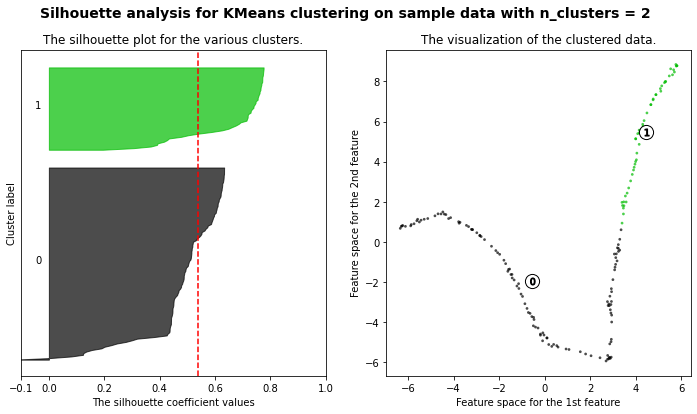

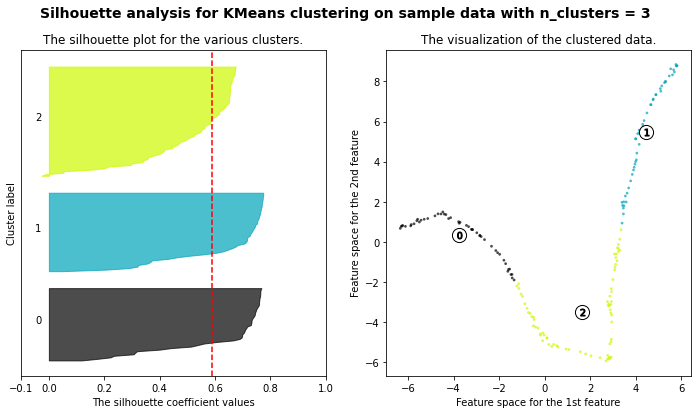

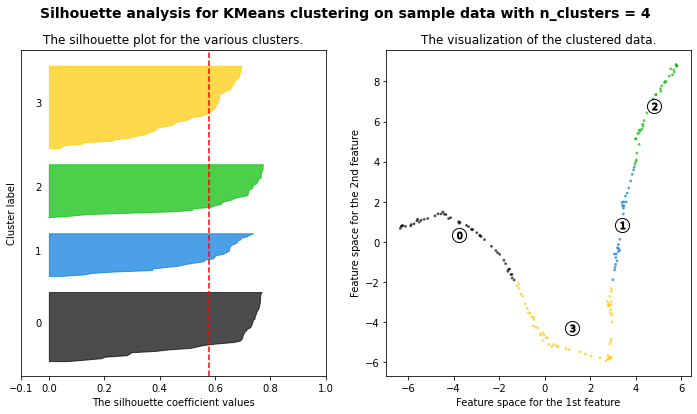

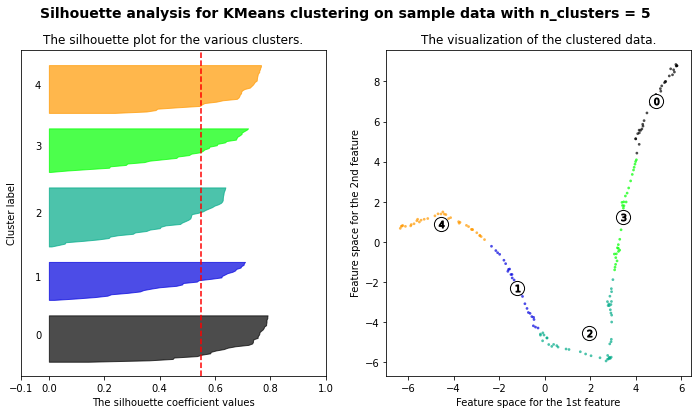

time: 1.69 s (started: 2022-11-12 05:45:04 +00:00)


In [ ]:
silhouette(X_train, 6)

In [ ]:
silhouette(X_train2, 10)

In [ ]:
silhouette(X_train3, 5)

In [ ]:
silhouette(X_train4, 5)

##### Get epsilon

In [ ]:
get_epsilon(X_train1)
get_epsilon(X_train2)
get_epsilon(X_train3)
get_epsilon(X_train4)

In [ ]:
from kneed import KneeLocator

from sklearn.neighbors import NearestNeighbors

X = X_train1
neighbor = 10

nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:, 10], axis=0)
#---
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.grid()

print(distances[knee.knee])

In [ ]:
def get_epsilon_samples(X, neighbor=5):
  # X = X_train1
  # neighbors = 10

  nearest_neighbors = NearestNeighbors(n_neighbors=neighbor + 1)
  neighbors = nearest_neighbors.fit(X)
  distances, indices = neighbors.kneighbors(X)
  distances = np.sort(distances[:, neighbor], axis=0)

  i = np.arange(len(distances))
  knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

  fig = plt.figure(figsize=(5, 5))
  knee.plot_knee()
  plt.xlabel("Points")
  plt.ylabel("Distance")
  plt.grid()

  print(distances[knee.knee])

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

X = X_train2
i = 1
range_ = np.arange(1, 0, -0.05)

fig = plt.figure(figsize=(15, 4*len(range_)))
fig.subplots_adjust(hspace=.15, wspace=.1)

for eps in range_:
    db = OPTICS(min_samples=10*X.shape[1], eps=eps, metric="euclidean").fit(X)
    labels = db.labels_
    
    # print(eps)
    ax = fig.add_subplot(len(range_)/2, 2, i)
    ax.set_title("eps = {}".format(round(eps, 3)), fontsize=14)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=["Cluster: {}".format(x) for x in labels])
    
    i += 1

##### Get epsilon and min samples

In [ ]:
# Get parameters
get_epsilon_samples(X_train1, neighbor=50)
get_epsilon_samples(X_train2, neighbor=50)
get_epsilon_samples(X_train3, neighbor=3)
get_epsilon_samples(X_train4, neighbor=3)

In [ ]:
X = X_train1
db = DBSCAN(eps=0.34, min_samples=50, metric="euclidean").fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels1 = db.labels_

In [ ]:
X = X_train1
db = OPTICS(min_samples=50, max_eps=0.5, xi=0.05, min_cluster_size=0.2, metric="euclidean").fit(X)
labels = db.labels_
print(labels)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=["Cluster: {}".format(x) for x in labels], s=50)



---



##### HDBSCAN

In [ ]:
#@title DBSCAN
X = X_train
i = 1
range_ = np.arange(2, 0, -0.01)

fig = plt.figure(figsize=(15, 3*len(range_)))
fig.subplots_adjust(hspace=.15, wspace=.1)

for eps in range_:
    db = DBSCAN(eps=eps, min_samples=20, metric="euclidean").fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # print(labels)

    if len(np.unique(labels)) >= 2:
      # print(eps)
      ax = fig.add_subplot(len(range_)/2, 2, i)
      ax.set_title("eps = {}".format(round(eps, 3)), fontsize=14)
      sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=["Cluster: {}".format(x) for x in labels], s=50)
      
      i += 1

In [ ]:
#@title HDBSCAN, euclidean
# Select
X = X_train
i = 1
range_ = np.arange(128, 0, -4)

fig = plt.figure(figsize=(15, 3*len(range_)))
fig.subplots_adjust(hspace=.15, wspace=.1)

for min_cluster in range_:
    cluster = HDBSCAN(min_cluster_size=min_cluster, min_samples=None, core_dist_n_jobs=-1, 
                      allow_single_cluster=True)
    labels = cluster.fit_predict(X)
    # print(labels)

    if len(np.unique(labels)) >= 1:
      # print(min_cluster)
      ax = fig.add_subplot(len(range_)/2, 2, i)
      ax.set_title("min_cluster = {}".format(round(min_cluster, 2)), fontsize=14)
      sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=["Cluster: {}".format(x) for x in labels], s=50)
      
      i += 1

In [ ]:
#@title HDBSCAN, cosine
X = X_train1
i = 1
range_ = np.arange(20, 0, -5)

fig = plt.figure(figsize=(15, 3*len(range_)))
fig.subplots_adjust(hspace=.15, wspace=.1)

for min_cluster in range_:
    pw_distance = pairwise_distances(X, metric="cosine", n_jobs=-1)
    # pw_distance = pairwise_kernels(X, metric="cosine", n_jobs=-1)
    # pw_distance = cosine_similarity(X)

    clusterer = HDBSCAN(min_cluster_size=min_cluster, metric='precomputed')
    clusterer.fit(pw_distance.astype('float64'))
    
    labels = clusterer.labels_

    if len(np.unique(labels)) >= 2:
      # print(eps)
      ax = fig.add_subplot(len(range_)/2, 2, i)
      ax.set_title("min_cluster = {}".format(round(min_cluster, 3)), fontsize=14)
      sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=["Cluster: {}".format(x) for x in labels], s=50)
      
      i += 1

##### **Training**

In [ ]:
#@title HDBSCAN
clustering = HDBSCAN(min_cluster_size=24, min_samples=1, core_dist_n_jobs=-1, allow_single_cluster=False)
clustering.fit(X_train1)
node_embeddings_2d1["labels"] = clustering.labels_

clustering = HDBSCAN(min_cluster_size=4, min_samples=1, core_dist_n_jobs=-1, allow_single_cluster=False)
clustering.fit(X_train2)
node_embeddings_2d2["labels"] = clustering.labels_

clustering = HDBSCAN(min_cluster_size=92, min_samples=None, core_dist_n_jobs=-1, allow_single_cluster=True)
clustering.fit(X_train)
node_embeddings_2d["labels"] = clustering.labels_

time: 21.3 ms (started: 2022-11-12 00:02:23 +00:00)


In [107]:
#@title K-means
clustering = KMeans(n_clusters=3, init="k-means++", max_iter=300, random_state=42)
clustering.fit(X_train)
node_embeddings_2d["labels"] = clustering.labels_

time: 32.7 ms (started: 2022-11-12 13:54:57 +00:00)


In [ ]:
#@title Others

# clustering = KMeans(n_clusters=4, init="k-means++", max_iter=300, random_state=42)
# clustering = SpectralClustering(n_clusters=3, assign_labels="discretize", random_state=42, n_jobs=-1)
# clustering = AgglomerativeClustering(n_clusters=3, affinity="cosine", linkage="average")
clustering = DBSCAN(eps=1.0, min_samples=50, metric="cosine")
# clustering = OPTICS(min_samples=12*X_train1.shape[1], max_eps=0.45, min_cluster_size=0.05, metric="euclidean")

# clustering = OPTICS(min_samples=0.09, eps=0.5, metric="cosine")
# clustering = OPTICS(min_samples=0.04)
# clustering = OPTICS(min_samples=40, xi=0.02, min_cluster_size=0.1)

clustering.fit(X_train1)

core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool) # Only for DBSCAN
core_samples_mask[clustering.core_sample_indices_] = True # Only for DBSCAN
labels1 = clustering.labels_

node_embeddings1["labels"] = labels1
print(np.unique(labels1))
# centers1 = clustering.cluster_centers_
print(labels1[:20])


# clustering = KMeans(n_clusters=4, init="k-means++", max_iter=300, random_state=42)
# clustering = SpectralClustering(n_clusters=4, assign_labels="discretize", random_state=42, n_jobs=-1)
# clustering = AgglomerativeClustering(n_clusters=4, affinity="cosine", linkage="average")
clustering = DBSCAN(eps=0.62, min_samples=50, metric="cosine")
# clustering = OPTICS(max_eps=0.2, min_samples=0.09, cluster_method="xi", metric="cosine")

# clustering = OPTICS(min_samples=0.07, eps=0.5, metric="cosine")
# clustering = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.02)
# clustering = OPTICS(min_samples=0.07)

clustering.fit(X_train2)

core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool) # Only for DBSCAN
core_samples_mask[clustering.core_sample_indices_] = True # Only for DBSCAN
labels2 = clustering.labels_

node_embeddings2["labels"] = labels2
print(np.unique(labels2))
# centers2 = clustering.cluster_centers_
print(labels2[:20])

# clustering = KMeans(n_clusters=3, init="k-means++", max_iter=300, random_state=42)
# clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=42, n_jobs=-1)
# clustering = AgglomerativeClustering(n_clusters=2, affinity="cosine", linkage="average")
clustering = DBSCAN(eps=0.66, min_samples=50, metric="cosine")
# clustering = OPTICS(max_eps=0.2, min_samples=0.09, cluster_method="xi", metric="cosine")

# clustering = OPTICS(min_samples=0.42, eps=0.5, metric="cosine")

clustering.fit(X_train3)

core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool) # Only for DBSCAN
core_samples_mask[clustering.core_sample_indices_] = True # Only for DBSCAN
labels3 = clustering.labels_

node_embeddings3["labels"] = labels3
print(np.unique(labels3))
# centers3 = clustering.cluster_centers_
print(labels3[:10])

# clustering = KMeans(n_clusters=3, init="k-means++", max_iter=300, random_state=42)
# clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=42, n_jobs=-1)
# clustering = AgglomerativeClustering(n_clusters=2, affinity="cosine", linkage="average")
clustering = DBSCAN(eps=0.95, min_samples=50, metric="cosine")
# clustering = OPTICS(min_samples=0.2, eps=0.5, metric="cosine")

# clustering = OPTICS(max_eps=0.02, min_samples=0.25, cluster_method="xi", metric="cosine")

clustering.fit(X_train4)

core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool) # Only for DBSCAN
core_samples_mask[clustering.core_sample_indices_] = True # Only for DBSCAN
labels4 = clustering.labels_

node_embeddings4["labels"] = labels4
print(np.unique(labels4))
# centers4 = clustering.cluster_centers_
print(labels4[:10])

In [ ]:
print(np.unique(node_embeddings_2d1["labels"]))
print(np.unique(node_embeddings_2d2["labels"]))
print(np.unique(node_embeddings_2d["labels"]))

[-1  0  1]
[-1  0  1  2  3  4  5  6  7  8  9 10]
[-1  0  1  2  3]
time: 11.6 ms (started: 2022-11-10 18:43:12 +00:00)


### Clustering Visualization

In [108]:
#@title ...
def visualization_embeddings(list_embeddings_2d):
  cols = 2
  rows = math.ceil(len(list_embeddings_2d) / cols)

  titles = []
  for k in range(len(list_embeddings_2d)):
    titles.append("Group {}".format(k + 1))
  
  fig = make_subplots(rows=rows, cols=cols,
                      subplot_titles=titles,
                      horizontal_spacing=0.05, vertical_spacing=0.05)

  for i, node_embeddings_2d in enumerate(list_embeddings_2d):
    fig.add_trace(
        go.Scatter(
            x=node_embeddings_2d.iloc[:, 0].values,
            y=node_embeddings_2d.iloc[:, 1].values,
            mode="markers",
            name="markers",
            text="Node id: " + node_embeddings_2d.index + "<br>Class: " + node_embeddings_2d["labels"].astype(str),
            textposition="bottom center",
            marker=dict(
              size=8,
              color=node_embeddings_2d["labels"].values,
              opacity=0.9,
              colorscale=list(np.array(colors)[np.unique(node_embeddings_2d["labels"])]), # "Rainbow",
              line_width=1
            ),
        ),
        row=math.ceil((i + 1) / cols), col=(i % cols) + 1
    )
  fig.update_layout(height=700*rows, width=1400, title_text="Embeddings", showlegend=True)
  fig.show()

time: 5.12 ms (started: 2022-11-12 13:55:00 +00:00)


In [109]:
# visualization_embeddings([node_embeddings_2d1, node_embeddings_2d2, node_embeddings_2d])
visualization_embeddings([node_embeddings_2d])

time: 31.2 ms (started: 2022-11-12 13:55:47 +00:00)


### Analysis: Filter and Matching

#### Matching

In [ ]:
#@title  matching
def matching(node_embeddings_2d1, node_embeddings_2d2, node_embeddings_2d):
  n_classes = np.unique(node_embeddings_2d1["labels"].values)
  if -1 in n_classes:
    len1 = len(n_classes) - 1
  else:
    len1 = len(n_classes)
  
  labels1_ = node_embeddings_2d1["labels"].values.copy()
  size1_ = [8] * len(node_embeddings_2d1.index)
  opacity1_ = [0.3] * len(node_embeddings_2d1.index)
  for k, node_id in enumerate(node_embeddings_2d2.index):
    if node_id in node_embeddings_2d1.index and node_embeddings_2d2["labels"][k] != -1:
      index = list(node_embeddings_2d1.index).index(node_id)
      labels1_[index] = node_embeddings_2d2["labels"][k] + len1
      # size1_[index] = 10
      opacity1_[index] = 0.9
  node_embeddings_2d1["labels_"] = labels1_
  
  # Plot
  fig = make_subplots(rows=2, cols=2,
                      subplot_titles=("Group 1", "Group 2", "Group 1 - Group 2", "Group 1 + Group 2"),
                      horizontal_spacing=0.05, vertical_spacing=0.05)

  fig.add_trace(
      go.Scatter(
        x=node_embeddings_2d1.iloc[:, 0].values,
        y=node_embeddings_2d1.iloc[:, 1].values,
        mode="markers",
        name="markers",
        text=node_embeddings_2d1.index,
        hovertemplate="Node id: " + node_embeddings_2d1.index + "<br>Class: " + node_embeddings_2d1["labels"].astype(str),
        textposition="bottom center",
        showlegend=True,
        marker=dict(
          size=8,
          color=node_embeddings_2d1["labels"].values,
          opacity=0.9,
          colorscale=list(np.array(colors)[np.unique(node_embeddings_2d1["labels"])]), # "Rainbow",
          line_width=1
        ),
      ),
      row=1, col=1
  )

  colorscale_ = np.unique(node_embeddings_2d2["labels"])
  for k in range(len(colorscale_)):
    if colorscale_[k] != -1:
      colorscale_[k] +=  len1

  fig.add_trace(
      go.Scatter(
          x=node_embeddings_2d2.iloc[:, 0].values,
          y=node_embeddings_2d2.iloc[:, 1].values,
          mode="markers",
          name="markers",
          text=node_embeddings_2d2.index,
          hovertemplate="Node id: " + node_embeddings_2d2.index + "<br>Class: " + node_embeddings_2d2["labels"].astype(str),
          textposition="bottom center",
          showlegend=True,
          marker=dict(
            size=8,
            color=node_embeddings_2d2["labels"].values,
            opacity=0.9,
            colorscale=list(np.array(colors)[colorscale_]), # "Rainbow",
            line_width=1
          ),
          textfont=dict(
              family="sans serif",
              size=10,
              color="black"
          ),
      ),
      row=1, col=2
  )

  fig.add_trace(
      go.Scatter(
          x=node_embeddings_2d1.iloc[:, 0].values,
          y=node_embeddings_2d1.iloc[:, 1].values,
          mode="markers",
          name="markers",
          text=node_embeddings_2d1.index,
          hovertemplate="Node id: " + node_embeddings_2d1.index + "<br>Class: " + node_embeddings_2d1["labels_"].astype(str),
          textposition="bottom center",
          showlegend=True,
          marker=dict(
            size=8,
            color=labels1_,
            opacity=opacity1_,
            colorscale=list(np.array(colors)[np.unique(labels1_)]), # "Rainbow",
            line_width=1
          ),
      ),
      row=2, col=1
  ),

  fig.add_trace(
      go.Scatter(
          x=node_embeddings_2d.iloc[:, 0].values,
          y=node_embeddings_2d.iloc[:, 1].values,
          mode="markers",
          name="markers",
          text="Node id: " + node_embeddings_2d.index + "<br>Class: " + node_embeddings_2d["labels"].astype(str),
          hovertemplate="Node id: " + node_embeddings_2d.index + "<br>Class: " + node_embeddings_2d["labels"].astype(str),
          textposition="bottom center",
          showlegend=True,
          marker=dict(
            size=8,
            color=node_embeddings_2d["labels"].values,
            opacity=0.9,
            colorscale=list(np.array(colors)[np.unique(node_embeddings_2d["labels"])]), # "Rainbow",
            line_width=1
          ),
      ),
      row=2, col=2
  )

  fig.update_layout(height=1000, width=1000, title_text="Clustering Embeddings") # ,legend_tracegroupgap=50, showlegend=False)
  fig.show()

time: 15.3 ms (started: 2022-11-09 21:37:12 +00:00)


In [ ]:
matching(node_embeddings_2d1, node_embeddings_2d2, node_embeddings_2d)

In [ ]:
#@title get_node_class
def get_node_class(node_embeddings_2d1, node_embeddings_2d2):
  nodes = []
  classes1 = []
  classes2 = []

  for k, node_id in enumerate(node_embeddings_2d2.index):
    nodes.append(node_id)
    classes1.append(node_embeddings_2d2["labels"][k])
    if node_id in node_embeddings_2d1.index:
      index = list(node_embeddings_2d1.index).index(node_id)
      classes2.append(node_embeddings_2d1["labels"][index])
    else:
      classes2.append("X")
  data = {"Node id": nodes, "Class G1": classes1, "Class G2": classes2}
  df_match1 = pd.DataFrame(data=data)
  return df_match1.sort_values(by="Class G1", ascending=True)

time: 1.93 ms (started: 2022-11-11 16:29:09 +00:00)


In [ ]:
# df_ = get_node_class(node_embeddings_2d1, node_embeddings_2d2)
# df_.head(20)

In [110]:
#@title Get commod nodes from global graph
node_embeddings_2d_filter = node_embeddings_2d.copy() # node_embeddings_2d[node_embeddings_2d["labels"] != -1]
node_embeddings_2d_filter

# Check nodes by clusters in embedding global
clusters_ = np.array(list(zip(node_embeddings_2d_filter.index, node_embeddings_2d_filter["labels"])))
clusters_[:10]

clusters = []
for i, item in enumerate(clusters_.tolist()):
  clusters.append([item[0][1:], item[0][0], item[1]])

clusters = np.array(clusters)
clusters = clusters[clusters[:, 0].argsort()]
clusters = clusters[clusters[:, 2].argsort(kind="mergesort")]
# clusters = clusters[clusters[:, 1].argsort(kind="mergesort")]
clusters[:10]

commond_nodes = []

a = clusters[0]
for item in clusters[1:]:
  b = item
  if a[0] == b[0]:
    commond_nodes.append([a[0]])
    commond_nodes.append([b[0]])
  a = b
commond_nodes[:10]

intersection_raw1_raw2_ = np.unique(np.array(commond_nodes)[:,0])
intersection_raw1_raw2_

array(['131.0824', '186.1139', '249.0552', '251.0776', '259.0227',
       '266.0886', '279.2331', '296.9997', '307.0311', '316.2857',
       '317.2143', '323.0277', '338.9889', '346.0558', '347.0589',
       '362.0509', '365.0531', '367.0185', '388.9441', '397.1319',
       '401.0173', '426.0221', '441.3372', '489.9937', '505.9889',
       '521.984', '545.3994', '604.0696', '606.0744', '611.144',
       '664.117', '665.2139', '766.1076', '784.1495', '808.118'],
      dtype='<U8')

time: 6.14 ms (started: 2022-11-12 13:55:59 +00:00)


In [111]:
#@title Aux script
# Get set for Raw data
set1_ = ['131.0824', '186.1139', '316.2857', '338.9889', '346.0558', '347.0589', '362.0509', '365.0531', '367.0185', '388.9441', '397.1319', '401.0173', '426.0221','441.3372','489.9937', '505.9889', '521.984', '545.3994', '604.0696', '606.0744','611.144', '664.117', '665.2139', '766.1076', '784.1495','808.118']
set2_ = intersection_raw1_raw2_

set1 = set(set1_)
set2 = set(set2_)

# Intersection Raw data
intersection = np.array(list(set1 & set2))
print(sorted(intersection))

# Difference Raw data
diff = np.array(list(set1 - set2))
print(sorted(diff))

# Difference Raw data
diff = np.array(list(set2 - set1))
print(sorted(diff))

['131.0824', '186.1139', '316.2857', '338.9889', '346.0558', '347.0589', '362.0509', '365.0531', '367.0185', '388.9441', '397.1319', '401.0173', '426.0221', '441.3372', '489.9937', '505.9889', '521.984', '545.3994', '604.0696', '606.0744', '611.144', '664.117', '665.2139', '766.1076', '784.1495', '808.118']
[]
['249.0552', '251.0776', '259.0227', '266.0886', '279.2331', '296.9997', '307.0311', '317.2143', '323.0277']
time: 2.97 ms (started: 2022-11-12 13:56:06 +00:00)


#### Graph visualization

In [ ]:
base = 100
weight = 100

node_size1 = []
for node_id in node_embeddings_2d1.index:
  node_size1.append(base + weight * G1.degree(node_id))

node_size2 = []
for node_id in node_embeddings_2d2.index:
  node_size2.append(base + weight * G2.degree(node_id))

node_size = []
for node_id in node_embeddings_2d.index:
  node_size.append(base + weight * G.degree(node_id))


time: 8.14 ms (started: 2022-11-09 00:20:48 +00:00)


Text(0.5, 1.0, 'Process data: 111-125')

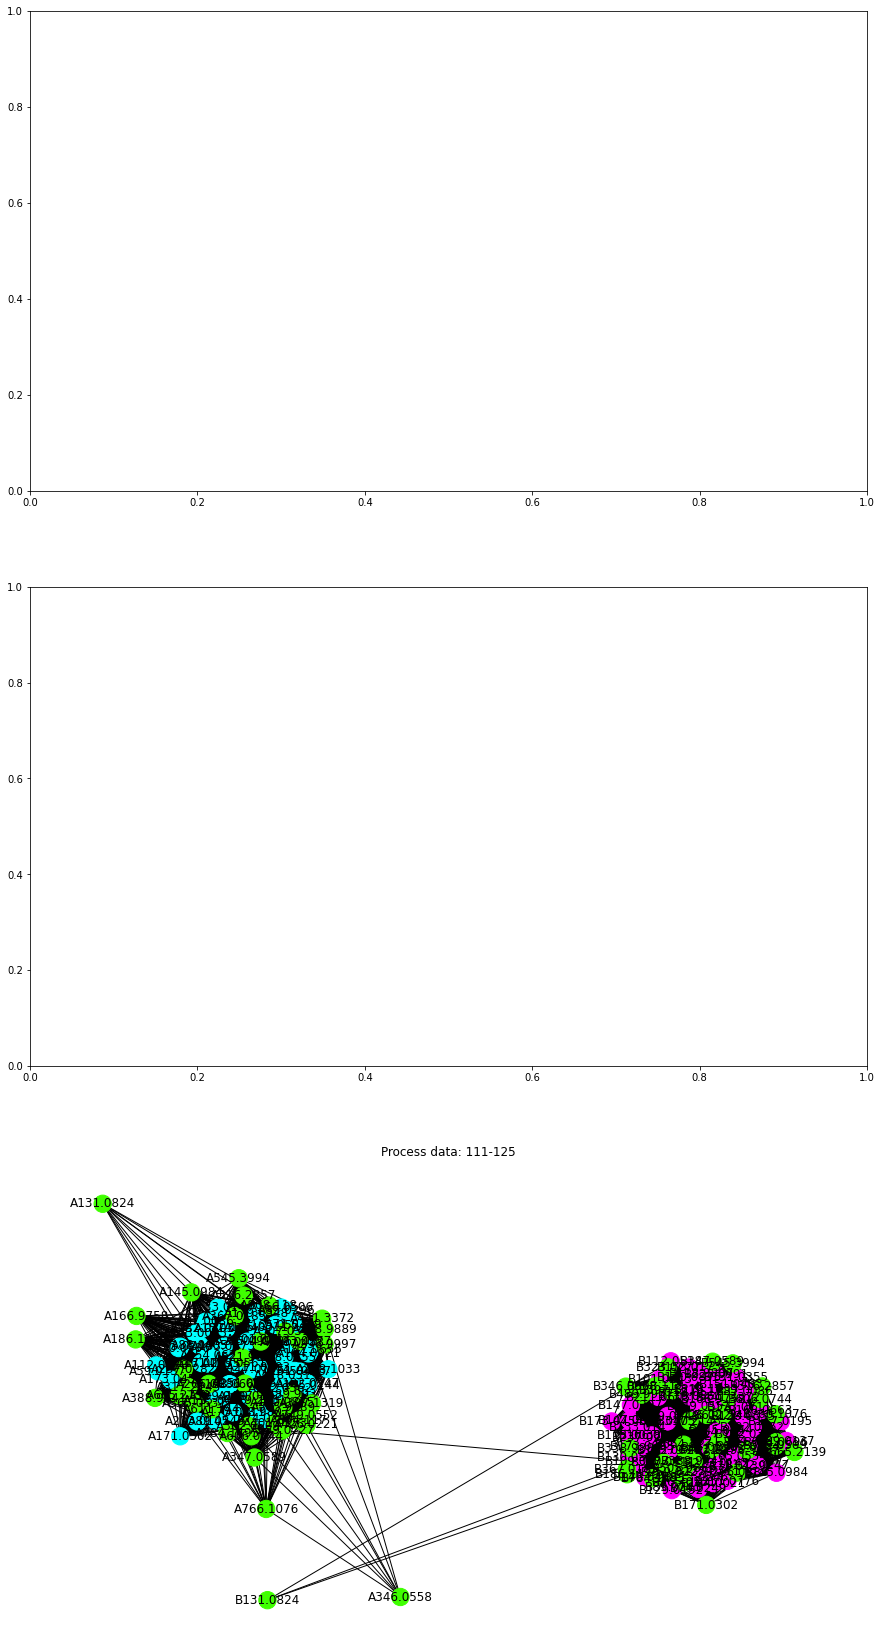

time: 4.83 s (started: 2022-11-12 06:07:06 +00:00)


In [ ]:
# cmap = plt.get_cmap("viridis")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 30))

""" cmap = ListedColormap(list(np.array(colors)[np.unique(node_embeddings_2d1["labels"])]))
nx.draw(G1, pos=nx.spring_layout(G1, k=0.10, seed=42), nodelist=list(map(str, node_embeddings_2d1.index)),
        edgecolors="black", font_size=8, with_labels=True, 
        node_color=node_embeddings_2d1["labels"], cmap=cmap, ax=axes[0])
axes[0].set_title("Raw data: 111-125")

cmap = ListedColormap(list(np.array(colors)[np.unique(node_embeddings_2d2["labels"])]))
nx.draw(G2, pos=nx.spring_layout(G2, k=0.10, seed=42), nodelist=list(map(str, node_embeddings_2d2.index)),
        edgecolors="black", font_size=8, with_labels=True, 
        node_color=node_embeddings_2d2["labels"], cmap=cmap, ax=axes[1])
axes[1].set_title("Raw data: 411-425") """

cmap = ListedColormap(list(np.array(colors)[np.unique(node_embeddings_2d["labels"])]))
nx.draw(G, pos=nx.spring_layout(G, iterations=15, seed=42), nodelist=list(map(str, node_embeddings_2d.index)),
        with_labels=True, node_color=node_embeddings_2d["labels"], cmap=cmap, ax=axes[2])
axes[2].set_title("Process data: 111-125")

#### Graph isomorphism

In [ ]:
print(nx.weisfeiler_lehman_graph_hash(G1))
print(nx.weisfeiler_lehman_graph_hash(G2))
print()
print(nx.weisfeiler_lehman_graph_hash(G3))
print(nx.weisfeiler_lehman_graph_hash(G4))

#### Similarity

Reference: https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa

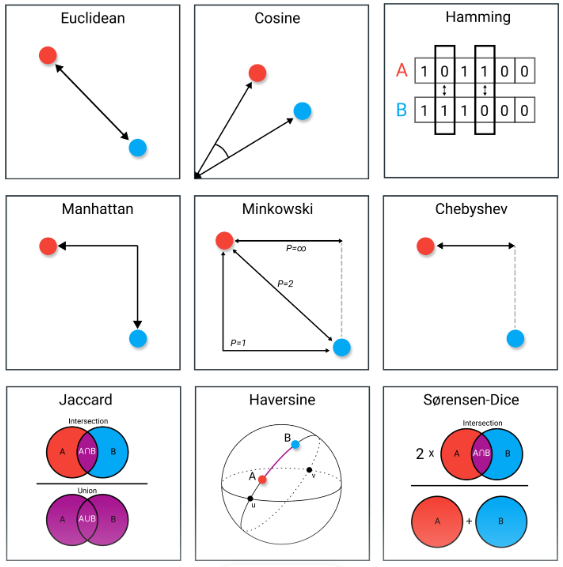

In [ ]:
""" model3.wv.most_similar("200", topn=10)
similarity = model1.wv.similarity('1', '173')
similarity """

##### Distance: euclidean

In [ ]:
metric = "euclidean"
topn = 5
df_similarity = most_similar2(node_embeddings1, node_embeddings2, topn, metric)
print(df_similarity.shape)
df_similarity

In [ ]:
df_similarity.describe()

In [ ]:
aux = df_similarity.loc[df_similarity[metric] <= 2.3]
print(aux.shape)
aux

In [ ]:
df_similarity.loc[df_similarity["u"] == 202]

##### Distance: cosine

In [ ]:
metric = "cosine"
topn = 5
df_similarity = most_similar2(node_embeddings1, node_embeddings2, topn, metric)
print(df_similarity.shape)
df_similarity

In [ ]:
df_similarity.describe()

In [ ]:
aux = df_similarity.loc[df_similarity[metric] <= 0.4]
print(aux.shape)
aux

In [ ]:
df_similarity.loc[df_similarity["u"] == 202]

#### **Filter Raw data**

In [ ]:
delete_class = list(np.unique(node_embeddings_2d1["labels"]))
# print(delete_class)

for k, node_id in enumerate(node_embeddings_2d2.index):
  if node_embeddings_2d2["labels"][k] != -1 and node_id in node_embeddings_2d1.index:
    index = list(node_embeddings_2d1.index).index(node_id)
    label = node_embeddings_2d1["labels"][index]
    if label != -1 and label in delete_class:
      delete_class.remove(label)
delete_class

#---

class_id = delete_class
print("Delete class: {}".format(class_id))

# G1_new = nx.Graph()
# G1_new.add_edges_from(G1.edges())
G1_new = G1.copy()

node_ids1_new = []
labels1_new = []

for k, class_ in enumerate(node_embeddings_2d1["labels"]):
  if class_ in class_id:
    node_id = node_embeddings_2d1.index[k]
    try:
      G1_new.remove_node(str(node_id))
    except:
      print("error!")
      pass
  else:
    node_ids1_new.append(node_embeddings_2d1.index[k])
    labels1_new.append(node_embeddings_2d1["labels"][k])

print(nx.info(G1))
print(nx.info(G1_new))

Delete class: [-1]
Graph with 86 nodes and 3276 edges
Graph with 48 nodes and 1095 edges
time: 25.1 ms (started: 2022-11-09 13:24:10 +00:00)


In [ ]:
delete_class = list(np.unique(node_embeddings_2d2["labels"]))
# print(delete_class)

for k, node_id in enumerate(node_embeddings_2d1.index):
  if node_embeddings_2d1["labels"][k] != -1 and node_id in node_embeddings_2d2.index:
    index = list(node_embeddings_2d2.index).index(node_id)
    label = node_embeddings_2d2["labels"][index]
    if label != -1 and label in delete_class:
      delete_class.remove(label)
delete_class

#---

class_id = delete_class
print("Delete class: {}".format(class_id))

# G1_new = nx.Graph()
# G1_new.add_edges_from(G1.edges())
G2_new = G2.copy()

node_ids2_new = []
labels2_new = []

for k, class_ in enumerate(node_embeddings_2d2["labels"]):
  if class_ in class_id:
    node_id = node_embeddings_2d2.index[k]
    try:
      G2_new.remove_node(str(node_id))
    except:
      print("error!")
      pass
  else:
    node_ids2_new.append(node_embeddings_2d2.index[k])
    labels2_new.append(node_embeddings_2d2["labels"][k])

print(nx.info(G2))
print(nx.info(G2_new))

Delete class: [-1]
Graph with 86 nodes and 3535 edges
Graph with 48 nodes and 1116 edges
time: 25.9 ms (started: 2022-11-09 13:24:13 +00:00)


In [ ]:
# cmap = plt.get_cmap("rainbow")

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 30))

cmap = ListedColormap(list(np.array(colors)[np.unique(node_embeddings_2d1["labels"])]))
nx.draw(G1, pos=nx.spring_layout(G1, k=0.10, seed=42), nodelist=list(map(str, node_embeddings_2d1.index)),
        edgecolors="black", font_size=12, with_labels=True, 
        node_color=node_embeddings_2d1["labels"], cmap=cmap, ax=axes[0])
axes[0].set_title("Before, Raw data: 111-125")

cmap = ListedColormap(list(np.array(colors)[np.unique(labels1_new)]))
nx.draw(G1_new, pos=nx.spring_layout(G1_new, iterations=15, seed=42), nodelist=list(map(str, node_ids1_new)),
        with_labels=True, node_color=labels1_new, cmap=cmap, ax=axes[1])
axes[1].set_title("After, Raw data: 111-125")

cmap = ListedColormap(list(np.array(colors)[np.unique(node_embeddings_2d2["labels"])]))
nx.draw(G2, pos=nx.spring_layout(G2, k=0.10, seed=42), nodelist=list(map(str, node_embeddings_2d2.index)),
        edgecolors="black", font_size=12, with_labels=True, 
        node_color=node_embeddings_2d2["labels"], cmap=cmap, ax=axes[2])
axes[2].set_title("Before, Raw data: 111-125")

cmap = ListedColormap(list(np.array(colors)[np.unique(labels2_new)]))
nx.draw(G2_new, pos=nx.spring_layout(G2_new, iterations=15, seed=42), nodelist=list(map(str, node_ids2_new)),
        with_labels=True, node_color=labels2_new, cmap=cmap, ax=axes[3])
axes[3].set_title("After, Raw data: 111-125")

In [ ]:
print("Before")
print(nx.info(G1))
print(nx.info(G2))
print("After")
print(nx.info(G1_new))
print(nx.info(G2_new))

Before
Graph with 86 nodes and 3276 edges
Graph with 86 nodes and 3535 edges
After
Graph with 32 nodes and 484 edges
Graph with 32 nodes and 494 edges
time: 8.27 ms (started: 2022-11-08 21:32:59 +00:00)


##### Changes detecting Raw data

In [ ]:
# G2_new.get_edge_data(1407 , 1051)["weight"] = -0.9786
# list(G1.edges.data("weight"))
# edges, weights = zip(*nx.get_edge_attributes(G1_, 'weight').items())
# sorted(nx.get_edge_attributes(G2_new, "weight").values())

In [ ]:
# g = list(set(node_ids2_new))
# "259" in g

In [ ]:
# Get set for Raw data

raw1 = set(node_ids1_new)
raw2 = set(node_ids2_new)

time: 948 µs (started: 2022-11-09 13:24:24 +00:00)


In [ ]:
# Intersection Raw data
intersection_raw1_raw2 = np.array(list(raw1 & raw2))

intersection_raw1_raw2 = intersection_raw1_raw2.astype(str)
intersection_raw1_raw2 = np.sort(intersection_raw1_raw2)
print(len(intersection_raw1_raw2))
intersection_raw1_raw2

36


array(['128.0355', '129.0192', '130.0875', '131.0355', '132.0303',
       '133.014', '135.0311', '145.0144', '145.0617', '146.0458',
       '147.0297', '147.0655', '151.0403', '152.0354', '153.0173',
       '154.062', '165.0554', '166.0506', '168.0663', '171.0302',
       '173.0095', '173.0454', '173.0711', '179.0348', '179.0561',
       '184.0021', '211.0603', '213.0145', '218.1033', '225.0991',
       '237.0282', '249.0552', '251.0776', '279.2331', '296.9997',
       '307.0311'], dtype='<U8')

time: 8.23 ms (started: 2022-11-09 13:24:26 +00:00)


In [ ]:
# Difference Raw data
diff_raw1_raw2 = np.array(list(raw1 - raw2))

diff_raw1_raw2 = diff_raw1_raw2.astype(str)
diff_raw1_raw2 = np.sort(diff_raw1_raw2)
print(len(diff_raw1_raw2))
diff_raw1_raw2

31


array(['102.0562', '109.0407', '117.0195', '122.0247', '154.062',
       '166.9758', '171.0302', '173.0454', '179.0561', '186.1139',
       '259.0227', '279.2331', '296.9997', '307.0311', '316.2857',
       '323.0277', '347.0589', '365.0531', '388.9441', '397.1319',
       '426.0221', '441.3372', '489.9937', '505.9889', '521.984',
       '545.3994', '604.0696', '606.0744', '664.117', '74.0249',
       '85.0296'], dtype='<U8')

time: 11.1 ms (started: 2022-11-07 05:43:40 +00:00)


In [ ]:
# Difference Raw data
diff_raw2_raw1 = np.array(list(raw2 - raw1))

diff_raw2_raw1 = diff_raw2_raw1.astype(str)
diff_raw2_raw1 = np.sort(diff_raw2_raw1)
print(len(diff_raw2_raw1))
diff_raw2_raw1

31


array(['101.0243', '113.0246', '115.0038', '128.0355', '130.0875',
       '131.0824', '132.0303', '133.014', '135.0311', '145.0984',
       '151.0403', '153.0173', '165.0554', '166.0506', '168.0663',
       '173.0095', '173.0711', '184.0021', '211.0603', '213.0145',
       '225.0991', '251.0776', '317.2143', '338.9889', '346.0558',
       '362.0509', '367.0185', '59.0137', '71.0139', '87.0086', '89.0245'],
      dtype='<U8')

time: 9.04 ms (started: 2022-11-07 05:43:45 +00:00)


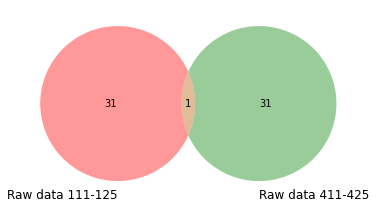

time: 87.4 ms (started: 2022-11-07 05:43:49 +00:00)


In [ ]:
from matplotlib_venn import venn2
venn2(subsets = (len(diff_raw1_raw2), len(diff_raw2_raw1), len(intersection_raw1_raw2)), 
      set_labels = ("Raw data 111-125", "Raw data 411-425"))
plt.show()

##### Visualization (common)

In [ ]:
edges, weights  = zip(*nx.get_edge_attributes(G1_new, "weight").items())
print(min(weights))

edges, weights  = zip(*nx.get_edge_attributes(G2_new, "weight").items())
print(min(weights))

0.5026479129812538
0.5261915726006827
time: 6.2 ms (started: 2022-11-07 05:43:54 +00:00)


In [ ]:
intersection_raw1_raw2_

array(['131.0824', '186.1139', '259.0227', '266.0886', '279.2331',
       '296.9997', '307.0311', '316.2857', '317.2143', '323.0277',
       '338.9889', '346.0558', '347.0589', '362.0509', '365.0531',
       '367.0185', '388.9441', '397.1319', '401.0173', '426.0221',
       '441.3372', '489.9937', '505.9889', '521.984', '545.3994',
       '604.0696', '606.0744', '611.144', '664.117', '665.2139',
       '766.1076', '784.1495', '808.118'], dtype='<U8')

time: 4.92 ms (started: 2022-11-12 06:23:15 +00:00)


In [ ]:
from platform import node
# Get changes by commond node
changes = []

v1 = []
v2 = []
w1 = []
w2 = []

for node_id_comm in intersection_raw1_raw2_:
  # print("Node id:", node_id_comm)

  e1 = []
  e2 = []

  node_id = "A" + node_id_comm
  neighbors1 = sorted(list(G.neighbors(str(node_id))))    
  for node_id_ in neighbors1:
    w = G.get_edge_data(str(node_id), str(node_id_))["weight"]
    e1.append([node_id, node_id_, round(w, 2)])
    
  node_id = "B" + node_id_comm
  neighbors2 = sorted(list(G.neighbors(str(node_id))))
  for node_id_ in neighbors2:
    w = G.get_edge_data(str(node_id), str(node_id_))["weight"]
    e2.append([node_id, node_id_, round(w, 2)])
  
  # Searching
  # print(e1)
  # print(e2)
  for item1 in e1:
    for item2 in e2:
      if item1[0][1:] == item2[0][1:] and item1[1][1:] == item2[1][1:]: # and item1[0] < item1[1]:
        changes.append([item1[0][1:], item2[1][1:], item1[2], item2[2]])
        break

df_changes = pd.DataFrame(changes, columns=["Node u", "Node v", "Weight1", "Weight2"])
df_changes["Difference"] = df_changes["Weight1"] - df_changes["Weight2"]
df_changes["Difference"] = df_changes["Difference"].abs()

time: 113 ms (started: 2022-11-12 06:23:16 +00:00)


In [ ]:
df_changes

,Node u,Node v,Weight1,Weight2,Difference
0,186.1139,101.0243,0.58,0.66,0.08
1,186.1139,109.0407,0.58,0.72,0.14
2,186.1139,113.0246,0.63,0.65,0.02
3,186.1139,118.9807,0.64,0.66,0.02
4,186.1139,122.0247,0.54,0.61,0.07
...,...,...,...,...,...
2324,808.118,784.1495,0.85,0.96,0.11
2325,808.118,85.0296,0.63,0.93,0.30
2326,808.118,87.0086,0.64,0.93,0.29
2327,808.118,88.0405,0.66,0.94,0.28


time: 15.5 ms (started: 2022-11-12 06:23:19 +00:00)


In [ ]:
#@title ...

# Get changes by commond node
changes1 = [] # [111-125, 411, 425]

v1 = []
v2 = []
w1 = []
w2 = []

for node_id in intersection_raw1_raw2:
  # print("Node id:", node_id)

  e1 = []
  e2 = []

  if str(node_id) in node_ids1_new:
    neighbors1 = sorted(list(G1_new.neighbors(str(node_id))))    
    for node_id_ in neighbors1:
      w = G1_new.get_edge_data(str(node_id), str(node_id_))["weight"]
      e1.append([node_id, node_id_, round(w, 2)])

  if str(node_id) in node_ids2_new:
    neighbors2 = sorted(list(G2_new.neighbors(str(node_id))))
    for node_id_ in neighbors2:
      w = G2_new.get_edge_data(str(node_id), str(node_id_))["weight"]
      e2.append([node_id, node_id_, round(w, 2)])
  
  # Searching
  # print(e1)
  # print(e2)
  for item1 in e1:
    for item2 in e2:
      if item1[0] == item2[0] and item1[1] == item2[1]: # and item1[0] < item1[1]:
        changes1.append([item1[0], item2[1], item1[2], item2[2]])
        break
        """ v1 = item1[0]
        v2 = item1[0]
        w1 = item1[2]
        w2 = item2[2] """

df_changes1 = pd.DataFrame(changes1, columns=["Node u", "Node v", "Weight1", "Weight2"])
df_changes1["Difference"] = df_changes1["Weight1"] - df_changes1["Weight2"]
df_changes1["Difference"] = df_changes1["Difference"].abs()

In [ ]:
# Save
df_changes1.to_csv("{}/Outputs/Changes/df_new_changes1_05_04.csv".format(dir), index=False)

time: 578 ms (started: 2022-10-25 22:56:43 +00:00)


In [ ]:
# Read
df_changes1 = pd.read_csv("{}/Outputs/Changes/df_new_changes1_05_04.csv".format(dir), index_col="Unnamed: 0")
df_changes1

In [ ]:
df_changes_filter = df_changes.loc[df_changes["Difference"] >= 0.3] # >= 0.5
df_changes_filter

,Node u,Node v,Weight1,Weight2,Difference
82,259.0227,166.9758,0.50,0.88,0.38
111,259.0227,388.9441,0.52,0.83,0.31
135,259.0227,109.0407,0.50,0.94,0.44
212,266.0886,808.118,0.61,0.94,0.33
347,296.9997,338.9889,0.57,0.87,0.30
...,...,...,...,...,...
2301,808.118,317.2143,0.54,0.91,0.37
2308,808.118,397.1319,0.55,0.94,0.39
2321,808.118,71.0139,0.63,0.93,0.30
2325,808.118,85.0296,0.63,0.93,0.30


time: 21 ms (started: 2022-11-12 06:23:24 +00:00)


In [ ]:
# For copy result in report (latex)
temp = df_changes1_filter[["Node u", "Node v"]].apply(lambda x : "({}, {})".format(x[0],x[1]), axis=1)
temp

In [ ]:
print(", ".join(temp))

(109.0407, 237.0282), (113.0246, 118.051), (113.0246, 128.0355), (113.0246, 132.0303), (113.0246, 146.0458), (113.0246, 237.0282), (113.0246, 74.0249), (115.0038, 59.0137), (118.051, 113.0246), (118.051, 179.0561), (118.051, 89.0245), (128.0355, 113.0246), (130.0875, 147.0297), (130.0875, 173.0095), (130.0875, 218.1033), (131.0355, 146.0458), (132.0303, 113.0246), (132.0303, 338.9889), (132.0303, 89.0245), (135.0311, 237.0282), (135.0311, 259.0227), (146.0458, 113.0246), (146.0458, 131.0355), (154.062, 147.0297), (179.0561, 118.051), (179.0561, 237.0282), (237.0282, 109.0407), (237.0282, 113.0246), (237.0282, 135.0311), (237.0282, 179.0561), (237.0282, 505.9889), (237.0282, 89.0245), (521.984, 338.9889), (74.0249, 113.0246), (89.0245, 118.051), (89.0245, 132.0303), (89.0245, 237.0282)
time: 2.6 ms (started: 2022-11-03 04:24:47 +00:00)


In [ ]:
# To latex table
# print(df_changes1.to_latex(index=False))  

In [ ]:
# Plot common node id

for node_id in intersection_raw1_raw2_:
  # print("Node id:", node_id)
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
  axes = axes.flatten()

  G1_ = nx.Graph()
  G2_ = nx.Graph()

  e1 = []
  c1 = []

  e2 = []
  c2 = []

  if str(node_id) in node_ids1_new:
    nei1 = sorted(list(G1_new.neighbors(str(node_id))))    
    for node_id_ in nei1:
      w = G1_new.get_edge_data(str(node_id), str(node_id_))["weight"]
      e1.append([node_id, node_id_, round(w, 2)])
      if w >= 0:
        c1.append("red")
      else:
        c1.append("blue")
    G1_.add_weighted_edges_from(e1)

  if str(node_id) in node_ids2_new:
    nei2 = sorted(list(G2_new.neighbors(str(node_id))))
    for node_id_ in nei2:
      w = G2_new.get_edge_data(str(node_id), str(node_id_))["weight"]
      e2.append([node_id, node_id_, round(w, 2)])
      if w >= 0:
        c2.append("red")
      else:
        c2.append("blue")
    G2_.add_weighted_edges_from(e2)
  
  # Searching
  # print(e1)
  # print(e2)
  for item1 in e1:
    for item2 in e2:
      if item1[0] == item2[0] and item1[1] == item2[1]:
        changes1.append([item1, item2])

  # Plot
  pos = nx.circular_layout(G1_)
  # pos = nx.spring_layout(G1_)
  nx.draw(G1_, pos, edge_color=c1, with_labels=True, node_color="orange", ax=axes[0])
  labels1=nx.get_edge_attributes(G1_, "weight")
  colors1={e: G1_.edges[e]['weight'] for e in G1_.edges}
  nx.draw_networkx_edge_labels(G1_, pos, edge_labels=labels1, ax=axes[0])
  axes[0].set_title("Raw data: 111-125")

  pos = nx.circular_layout(G2_)
  # pos = nx.kamada_kawai_layout(G2_)
  nx.draw(G2_, pos, edge_color=c2, with_labels=True, node_color="orange", ax=axes[1])
  labels2=nx.get_edge_attributes(G2_, "weight")
  nx.draw_networkx_edge_labels(G2_, pos, edge_labels=labels2, ax=axes[1])
  axes[1].set_title("Raw data: 411-425")

### Get metabolite name for common node

In [ ]:
# Read (df_changes1)
df_changes1 = pd.read_csv("{}/Outputs/Changes/df_new_changes1_05_04.csv".format(dir), index_col="Unnamed: 0")
df_changes1

In [ ]:
df_changes_filter = df_changes.loc[df_changes["Difference"] >= 0.3] # >= 0.4
df_changes_filter

,Node u,Node v,Weight1,Weight2,Difference
82,259.0227,166.9758,0.50,0.88,0.38
111,259.0227,388.9441,0.52,0.83,0.31
135,259.0227,109.0407,0.50,0.94,0.44
212,266.0886,808.118,0.61,0.94,0.33
347,296.9997,338.9889,0.57,0.87,0.30
...,...,...,...,...,...
2301,808.118,317.2143,0.54,0.91,0.37
2308,808.118,397.1319,0.55,0.94,0.39
2321,808.118,71.0139,0.63,0.93,0.30
2325,808.118,85.0296,0.63,0.93,0.30


time: 53.5 ms (started: 2022-11-12 06:23:41 +00:00)


In [ ]:
# Detect kind of change

df_kind_change = df_changes_filter.copy()
conditions = [
    ((df_kind_change["Weight1"] < 0) & (df_kind_change["Weight2"] > 0) & (df_kind_change["Weight1"] > -0.8) & (df_kind_change["Weight2"] < 0.8)),
    ((df_kind_change["Weight1"] < 0) & (df_kind_change["Weight2"] > 0) & (df_kind_change["Weight1"] > -0.8) & (df_kind_change["Weight2"] >= 0.8)),
    ((df_kind_change["Weight1"] < 0) & (df_kind_change["Weight2"] > 0) & (df_kind_change["Weight1"] <= -0.8) & (df_kind_change["Weight2"] < 0.8)),
    ((df_kind_change["Weight1"] < 0) & (df_kind_change["Weight2"] > 0) & (df_kind_change["Weight1"] <= -0.8) & (df_kind_change["Weight2"] >= 0.8)),

    ((df_kind_change["Weight1"] > 0) & (df_kind_change["Weight2"] < 0) & (df_kind_change["Weight1"] < 0.8) & (df_kind_change["Weight2"] > -0.8)),
    ((df_kind_change["Weight1"] > 0) & (df_kind_change["Weight2"] < 0) & (df_kind_change["Weight1"] >= 0.8) & (df_kind_change["Weight2"] > -0.8)),
    ((df_kind_change["Weight1"] > 0) & (df_kind_change["Weight2"] < 0) & (df_kind_change["Weight1"] < 0.8) & (df_kind_change["Weight2"] <= -0.8)),
    ((df_kind_change["Weight1"] > 0) & (df_kind_change["Weight2"] < 0) & (df_kind_change["Weight1"] >= 0.8) & (df_kind_change["Weight2"] <= -0.8)),

    
    ((df_kind_change["Weight1"] > 0) & (df_kind_change["Weight2"] > 0) & (df_kind_change["Weight1"] >= 0.8) & (df_kind_change["Weight2"] >= 0.8)),
    ((df_kind_change["Weight1"] > 0) & (df_kind_change["Weight2"] > 0) & (df_kind_change["Weight1"] < 0.8) & (df_kind_change["Weight2"] < 0.8)),
    ((df_kind_change["Weight1"] > 0) & (df_kind_change["Weight2"] > 0) & (df_kind_change["Weight1"] >= 0.8) & (df_kind_change["Weight2"] < 0.8)),
    ((df_kind_change["Weight1"] > 0) & (df_kind_change["Weight2"] > 0) & (df_kind_change["Weight1"] < 0.8) & (df_kind_change["Weight2"] >= 0.8)),

    ((df_kind_change["Weight1"] < 0) & (df_kind_change["Weight2"] < 0) & (df_kind_change["Weight1"] <= -0.8) & (df_kind_change["Weight2"] <= -0.8)),
    ((df_kind_change["Weight1"] < 0) & (df_kind_change["Weight2"] < 0) & (df_kind_change["Weight1"] > -0.8) & (df_kind_change["Weight2"] > -0.8)),
    ((df_kind_change["Weight1"] < 0) & (df_kind_change["Weight2"] < 0) & (df_kind_change["Weight1"] <= -0.8) & (df_kind_change["Weight2"] > -0.8)),
    ((df_kind_change["Weight1"] < 0) & (df_kind_change["Weight2"] < 0) & (df_kind_change["Weight1"] > -0.8) & (df_kind_change["Weight2"] <= -0.8)),
]
values = ["np", "nP", "Np", "NP", "pn", "Pn", "pN", "PN", "PP", "pp", "Pp", "pP", "NN", "nn", "Nn", "nN"]
df_kind_change["Kind change"] = np.select(conditions, values)
df_kind_change

,Node u,Node v,Weight1,Weight2,Difference,Kind change
82,259.0227,166.9758,0.50,0.88,0.38,pP
111,259.0227,388.9441,0.52,0.83,0.31,pP
135,259.0227,109.0407,0.50,0.94,0.44,pP
212,266.0886,808.118,0.61,0.94,0.33,pP
347,296.9997,338.9889,0.57,0.87,0.30,pP
...,...,...,...,...,...,...
2301,808.118,317.2143,0.54,0.91,0.37,pP
2308,808.118,397.1319,0.55,0.94,0.39,pP
2321,808.118,71.0139,0.63,0.93,0.30,pP
2325,808.118,85.0296,0.63,0.93,0.30,pP


time: 146 ms (started: 2022-11-12 06:24:04 +00:00)


In [ ]:
# Counting frequencies
df_temp1 = df_changes_filter["Node u"].value_counts(ascending=False, dropna=False)
df_temp1 = df_temp1.to_frame()
df_temp1.reset_index(drop=False, inplace=True)
df_temp1.columns = ["Node id", "Count"]
df_temp1

,Node id,Count
0,808.118,19
1,766.1076,13
2,441.3372,9
3,338.9889,6
4,397.1319,6
5,347.0589,5
6,426.0221,4
7,784.1495,3
8,545.3994,3
9,259.0227,3


time: 21.6 ms (started: 2022-11-12 06:24:39 +00:00)


In [ ]:
df_temp1[df_temp1["Count"] > 1]

,Node id,Count
0,808.118,19
1,766.1076,13
2,441.3372,9
3,338.9889,6
4,397.1319,6
5,347.0589,5
6,426.0221,4
7,784.1495,3
8,545.3994,3
9,259.0227,3


time: 15.4 ms (started: 2022-11-12 06:24:51 +00:00)


In [ ]:
# Counting frequencies
df_temp2 = df_changes_filter["Node v"].value_counts(ascending=False, dropna=False)
df_temp2 = df_temp2.to_frame()
df_temp2.reset_index(drop=False, inplace=True)
df_temp2.columns = ["Node id", "Count"]
df_temp2

,Node id,Count
0,166.9758,6
1,766.1076,6
2,397.1319,4
3,89.0245,4
4,179.0561,4
5,808.118,3
6,338.9889,3
7,225.0991,3
8,441.3372,3
9,113.0246,3


time: 53 ms (started: 2022-11-12 06:25:02 +00:00)


In [ ]:
df_temp2[df_temp2["Count"] > 1]

,Node id,Count
0,166.9758,6
1,766.1076,6
2,397.1319,4
3,89.0245,4
4,179.0561,4
5,808.118,3
6,338.9889,3
7,225.0991,3
8,441.3372,3
9,113.0246,3


time: 16.7 ms (started: 2022-11-12 06:25:23 +00:00)


In [ ]:
# Contat frequencies for Node u and Node v
df_concat = pd.concat([df_temp1, df_temp2])
df_concat.sort_values(by=["Count"], ascending=False, inplace=True)
df_concat

,Node id,Count
0,808.118,19
1,766.1076,13
2,441.3372,9
3,338.9889,6
4,397.1319,6
...,...,...
25,165.0554,1
26,166.0506,1
27,317.2143,1
23,296.9997,1


time: 17.1 ms (started: 2022-11-12 06:25:32 +00:00)


In [ ]:
# Get cores (central node id)
""" df_concat_ = df_concat.groupby(["Node id"]).sum()
df_concat_.sort_values(by=["Count"], ascending=False, inplace=True)
df_concat_.reset_index(drop=False, inplace=True)
df_concat_.columns = ["Node id", "Count"] """
df_concat_ = df_concat.drop_duplicates()
df_concat_

,Node id,Count
0,808.118,19
1,766.1076,13
2,441.3372,9
3,338.9889,6
4,397.1319,6
...,...,...
22,151.0403,1
23,168.0663,1
25,165.0554,1
26,166.0506,1


time: 16 ms (started: 2022-11-12 06:25:38 +00:00)


In [ ]:
# Save
# df_concat_.to_csv("{}/df_new_node_degree_05_04.csv".format(dir), index=True)

time: 504 µs (started: 2022-10-26 14:04:14 +00:00)


In [ ]:
# Get nodes list
list_nodes = df_changes_filter["Node u"].to_list() + df_changes_filter["Node v"].to_list()
list_nodes = np.unique(list_nodes)
print(len(list_nodes))
list_nodes

54


array(['109.0407', '113.0246', '115.0038', '118.9807', '129.0192',
       '130.0506', '135.0311', '145.0144', '145.0617', '147.0297',
       '151.0403', '153.0173', '154.062', '165.0554', '166.0506',
       '166.9758', '168.0663', '173.0095', '173.0454', '173.0711',
       '179.0348', '179.0561', '184.0021', '225.0991', '249.0552',
       '251.0776', '259.0227', '266.0886', '296.9997', '307.0311',
       '316.2857', '317.2143', '323.0277', '338.9889', '346.0558',
       '347.0589', '362.0509', '365.0531', '388.9441', '397.1319',
       '401.0173', '426.0221', '441.3372', '505.9889', '521.984',
       '545.3994', '604.0696', '664.117', '71.0139', '766.1076',
       '784.1495', '808.118', '85.0296', '89.0245'], dtype='<U8')

time: 35.5 ms (started: 2022-11-12 06:25:53 +00:00)


In [ ]:
df1_

In [ ]:
# Get metabolite name by node id
list_metabolite = df1_.loc[list_nodes, ["Metabolites - Approved by Nicola", "Chemical Formula (based on BioCyc)"]]
# list_metabolite["Alignment ID"] = list_metabolite.index.values
list_metabolite

KeyError: ignored

time: 43 ms (started: 2022-11-12 06:31:52 +00:00)


In [ ]:
# Save
list_metabolite.to_csv("{}/Outputs/Metabolites/df_new_names_05_04.csv".format(dir), index=True)

time: 1.11 s (started: 2022-10-26 14:04:14 +00:00)


In [ ]:
# list_metabolite = pd.read_csv("{}/Outputs/Metabolites/df_new_names_05_04.csv".format(dir), index_col="Alignment ID")
# list_metabolite

time: 634 µs (started: 2022-10-26 14:04:15 +00:00)


In [ ]:
list_metabolite_formula = list_metabolite.loc[pd.notnull(list_metabolite["Chemical Formula (based on BioCyc)"])]
list_metabolite_no_formula = list_metabolite.loc[~pd.notnull(list_metabolite["Chemical Formula (based on BioCyc)"])]

list_metabolite_formula

,Metabolites - Approved by Nicola,Chemical Formula (based on BioCyc)
Corrected (m/z),,
145.0617,C5H10N2O3,C5H10N2O3
154.062,Histidine,C6H9N3O2
166.9758,Phosphoenolpyruvic acid,C3H5O6P
259.0227,D-Glucose 6-Phosphate,C6H13O9P
323.0277,Uridine monophosphate,C9H13N2O9P
346.0558,Adenosine monophosphate,C10H14N5O7P
362.0509,Guanosine monophosphate,C10H14N5O8P
388.9441,Ribose Triphosphate,C5H13O14P3
401.0173,dTDP,C10H16N2O11P2


time: 14.5 ms (started: 2022-11-07 00:20:01 +00:00)


In [ ]:
# Search one node
list_metabolite.loc["766.1076"]

Metabolites - Approved by Nicola          Coenzyme A
Chemical Formula (based on BioCyc)    C21H36N7O16P3S
Name: 766.1076, dtype: object

time: 31.6 ms (started: 2022-11-07 00:20:22 +00:00)


In [ ]:
# temp = list_metabolite[["Alignment ID", "Metabolite name"]].apply(lambda x : "\.textbf#a{0}#b: {1}".format(x[0],x[1]), axis=1)
# temp

time: 634 µs (started: 2022-10-26 14:04:15 +00:00)


In [ ]:
""" temp = ", ".join(temp)
temp = temp.replace("_", "\_").replace("#a", "{").replace("#b", "}")

print(temp.replace("\.", "\\")) """

' temp = ", ".join(temp)\ntemp = temp.replace("_", "\\_").replace("#a", "{").replace("#b", "}")\n\nprint(temp.replace("\\.", "\\")) '

time: 6.65 ms (started: 2022-10-26 14:04:15 +00:00)


In [ ]:
# Get changes accorinng to most frequencies node
list_node_freq = df_concat_["Node id"]
list_node_freq

0    766.1076
0    545.3994
2    259.0227
3    323.0277
1     154.062
1    166.9758
2    545.3994
6    401.0173
5     154.062
4     664.117
3    388.9441
8    604.0696
7     521.984
6    362.0509
5    346.0558
4    145.0617
7    505.9889
Name: Node id, dtype: object

time: 7.93 ms (started: 2022-11-07 00:20:32 +00:00)


In [ ]:
list_node_freq.values

array(['766.1076', '545.3994', '259.0227', '323.0277', '154.062',
       '166.9758', '545.3994', '401.0173', '154.062', '664.117',
       '388.9441', '604.0696', '521.984', '362.0509', '346.0558',
       '145.0617', '505.9889'], dtype=object)

time: 4.19 ms (started: 2022-11-07 00:20:40 +00:00)


In [ ]:
# df_kind_change.loc[df_kind_change["Node u"].isin(list_node_freq.values)]
df_kind_change_filter = pd.DataFrame()
for node_id in list_node_freq.values:
  df_aux = df_kind_change[["Node u", "Node v", "Kind change"]].loc[df_kind_change["Node u"] == node_id]
  df_kind_change_filter = pd.concat([df_kind_change_filter, df_aux])
df_kind_change_filter

,Node u,Node v,Kind change
757,545.3994,154.062,pP
782,545.3994,401.0173,pP
786,545.3994,505.9889,pP
434,259.0227,166.9758,pP
463,259.0227,388.9441,pP
517,323.0277,166.9758,pP
563,323.0277,766.1076,pP
275,154.062,545.3994,pP
284,154.062,766.1076,pP
757,545.3994,154.062,pP


time: 27.5 ms (started: 2022-11-07 00:20:49 +00:00)


In [ ]:
# Save
# df_kind_change_filter.to_csv("{}/Outputs/Changes/df_new_kind_changes_filter_05_04.csv".format(dir), index=True)

time: 394 µs (started: 2022-10-26 14:04:16 +00:00)


### Plot graph

In [ ]:
df_changes1_filter

,Node u,Node v,Weight1,Weight2,Difference
147,145.0617,766.1076,0.54,0.87,0.33
275,154.062,545.3994,0.54,0.87,0.33
284,154.062,766.1076,0.53,0.92,0.39
434,259.0227,166.9758,0.50,0.88,0.38
463,259.0227,388.9441,0.52,0.83,0.31
517,323.0277,166.9758,0.57,0.87,0.30
563,323.0277,766.1076,0.51,0.87,0.36
576,346.0558,664.117,0.56,0.90,0.34
654,362.0509,766.1076,0.57,0.89,0.32
737,521.984,766.1076,0.63,0.94,0.31


time: 16.3 ms (started: 2022-11-07 00:21:05 +00:00)


In [ ]:
edges_ = df_changes1_filter[["Node u", "Node v"]].values

edges = np.ones((edges_.shape[0], edges_.shape[1] + 1))
edges[:,:-1] = edges_
edges

array([[145.0617, 766.1076,   1.    ],
       [154.062 , 545.3994,   1.    ],
       [154.062 , 766.1076,   1.    ],
       [259.0227, 166.9758,   1.    ],
       [259.0227, 388.9441,   1.    ],
       [323.0277, 166.9758,   1.    ],
       [323.0277, 766.1076,   1.    ],
       [346.0558, 664.117 ,   1.    ],
       [362.0509, 766.1076,   1.    ],
       [521.984 , 766.1076,   1.    ],
       [545.3994, 154.062 ,   1.    ],
       [545.3994, 401.0173,   1.    ],
       [545.3994, 505.9889,   1.    ],
       [604.0696, 766.1076,   1.    ]])

time: 7.45 ms (started: 2022-11-07 00:21:17 +00:00)


In [ ]:
edges_

array([['145.0617', '766.1076'],
       ['154.062', '545.3994'],
       ['154.062', '766.1076'],
       ['259.0227', '166.9758'],
       ['259.0227', '388.9441'],
       ['323.0277', '166.9758'],
       ['323.0277', '766.1076'],
       ['346.0558', '664.117'],
       ['362.0509', '766.1076'],
       ['521.984', '766.1076'],
       ['545.3994', '154.062'],
       ['545.3994', '401.0173'],
       ['545.3994', '505.9889'],
       ['604.0696', '766.1076']], dtype=object)

time: 3.89 ms (started: 2022-11-07 00:21:39 +00:00)


#### Plot one by one acording to grade

In [ ]:
list_ = df_concat_["Node id"].values

for k, node_id in enumerate(list_[50:100]):
  edges_by_node = df_changes1_[["Node u", "Node v"]].loc[(df_changes1_["Node u"] == node_id) | 
                                                         (df_changes1_["Node v"] == node_id)]
  G_ = nx.Graph()
  G_.add_edges_from(edges_by_node.values)

  plt.figure(1, figsize=(6, 6)) 

  """ # find node with largest degree
  node_and_degree = G_.degree()
  (largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]

  # Create ego graph of main hub
  hub_ego = nx.ego_graph(G, largest_hub)

  # Draw graph
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(hub_ego, seed=42)  # Seed layout for reproducibility
  nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)
  print(largest_hub)
  # Draw ego as large and red
  options = {"node_size": 300, "node_color": "r"}
  nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options) """

  nx.draw(G_, pos=nx.circular_layout(G_), node_color="b", node_size=10, with_labels=False)

  plt.title("Node id: {}, Degree: {}".format(node_id, G_.degree(node_id)))
  plt.show()

#### Plot with filter by degre

In [ ]:
list_node_freq.values

##### NetworkX

In [ ]:
# Plot using all nodes
G = nx.Graph()
G.add_edges_from(edges_)
pos = nx.spring_layout(G, k=0.5, seed=42)

fig, ax = plt.subplots(figsize=(30, 30))
nx.draw(G, pos, with_labels=True, node_color="orange", ax=ax)  # networkx draw()
# plt.draw()  # pyplot draw()
plt.axis("off")

print(nx.info(G))

In [ ]:
# Plot using all nodes with Formula
G = nx.Graph()
G.add_edges_from(edges_)

# remove null Formula nodes
G.remove_nodes_from(list_metabolite_no_formula.index.values)
pos = nx.spring_layout(G, k=0.5, seed=42)

fig, ax = plt.subplots(figsize=(30, 30))
nx.draw(G, pos, with_labels=True, node_color="orange", ax=ax)  # networkx draw()
# plt.draw()  # pyplot draw()
plt.axis("off")

print(nx.info(G))

In [ ]:
list_metabolite_formula.index.values

In [ ]:
# Get node id only the Formula exist
df_concat_.loc[df_concat_["Node id"].isin(list_metabolite_formula.index.values)]

In [ ]:
# Plot using all nodes with Formula and filter by degree
G = nx.Graph()
G.add_edges_from(edges_)
print(len(G.nodes()))

# remove null Formula nodes
G.remove_nodes_from(list_metabolite_no_formula.index.values)
print(len(G.nodes()))

# remove high degree nodes
high_degree = [n for n, d in G.degree() if d > 50]
G.remove_nodes_from(high_degree)
print(len(G.nodes()))

# remove low degree nodes
low_degree = [n for n, d in G.degree() if d == 0]
G.remove_nodes_from(low_degree)
print(len(G.nodes()))

# pos = nx.spring_layout(G, k=0.1, seed=42)
# pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

fig, ax = plt.subplots(figsize=(30, 30))
nx.draw(G, with_labels=True, node_color="orange", ax=ax)  # networkx draw()
# plt.draw()  # pyplot draw()
plt.axis("off")

print(nx.info(G))

In [ ]:
# Search one
node_id = 714
radius = 2
list_radius = []
list_radius_all = []
for k in range(radius):
  SG = nx.ego_graph(G, n=node_id, radius=k+1, center=True, undirected=False, distance=None)
  aux = list(SG.nodes())
  print(aux)
  # aux = list(set(aux) - set([node_id]))
  if len(list_radius) > 0:
    aux = list(set(aux) - set(list_radius_all))
  list_radius_all += aux
  list_radius.append(aux)

print()
for item in list_radius:
  print(item)

pos = nx.spring_layout(SG, k=0.5, seed=42)  # Seed layout for reproducibility

fig, ax = plt.subplots(figsize=(30, 30))
nx.draw(SG, pos, with_labels=True, node_color="orange", ax=ax)  # networkx draw()
# plt.draw()  # pyplot draw()

# Draw ego as large and red
# options = {"node_size": 300, "node_color": "#61ff33"}
colors = ["#FF0000", "#00FF00", "#00FFFF", "#FF00FF", "#FFFF00", "#C0C0C0"] # ["#FF00FF", "#3FFF00", "#00FFFF", "#FFF700", "#FF0000", "#0000FF", "#006600", "#FFFF00"]

for k in range(radius):
  nx.draw_networkx_nodes(SG, pos, nodelist=list_radius[k], node_color=colors[k])
nx.draw_networkx_nodes(SG, pos, nodelist=[node_id], node_color=colors[-1], node_size=1000)
plt.axis("off")

import matplotlib.patches as mpatches
patchs = []
patchs.append(mpatches.Patch(color=colors[-1], label="Center"))
for k, color in enumerate(colors[:-1]):
  patchs.append(mpatches.Patch(color=color, label="Radio: {}".format(k+1)))
ax.legend(handles=patchs)



---



##### iGraph

In [ ]:
df_concat_.loc[df_concat_["Count"] > 0]

,Node id,Count
0,766.1076,6
0,545.3994,3
2,259.0227,2
3,323.0277,2
1,154.062,2
1,166.9758,2
2,545.3994,1
6,401.0173,1
5,154.062,1
4,664.117,1


time: 17.3 ms (started: 2022-11-07 00:21:48 +00:00)


In [ ]:
df_changes1_filter

,Node u,Node v,Weight1,Weight2,Difference
147,145.0617,766.1076,0.54,0.87,0.33
275,154.062,545.3994,0.54,0.87,0.33
284,154.062,766.1076,0.53,0.92,0.39
434,259.0227,166.9758,0.50,0.88,0.38
463,259.0227,388.9441,0.52,0.83,0.31
517,323.0277,166.9758,0.57,0.87,0.30
563,323.0277,766.1076,0.51,0.87,0.36
576,346.0558,664.117,0.56,0.90,0.34
654,362.0509,766.1076,0.57,0.89,0.32
737,521.984,766.1076,0.63,0.94,0.31


time: 14.6 ms (started: 2022-11-07 00:21:52 +00:00)


In [ ]:
df_kind_change_filter

,Node u,Node v,Kind change
757,545.3994,154.062,pP
782,545.3994,401.0173,pP
786,545.3994,505.9889,pP
434,259.0227,166.9758,pP
463,259.0227,388.9441,pP
517,323.0277,166.9758,pP
563,323.0277,766.1076,pP
275,154.062,545.3994,pP
284,154.062,766.1076,pP
757,545.3994,154.062,pP


time: 10.9 ms (started: 2022-11-07 00:22:03 +00:00)


In [ ]:
list_metabolite

,Metabolites - Approved by Nicola,Chemical Formula (based on BioCyc)
Corrected (m/z),,
145.0617,C5H10N2O3,C5H10N2O3
154.062,Histidine,C6H9N3O2
166.9758,Phosphoenolpyruvic acid,C3H5O6P
259.0227,D-Glucose 6-Phosphate,C6H13O9P
323.0277,Uridine monophosphate,C9H13N2O9P
346.0558,Adenosine monophosphate,C10H14N5O7P
362.0509,Guanosine monophosphate,C10H14N5O8P
388.9441,Ribose Triphosphate,C5H13O14P3
401.0173,dTDP,C10H16N2O11P2


time: 12 ms (started: 2022-11-07 00:22:43 +00:00)


In [ ]:
edges_w = df_changes1_filter[["Node u", "Node v", "Weight1"]].values.tolist()
edges_w[:10]

[['145.0617', '766.1076', 0.54],
 ['154.062', '545.3994', 0.54],
 ['154.062', '766.1076', 0.53],
 ['259.0227', '166.9758', 0.5],
 ['259.0227', '388.9441', 0.52],
 ['323.0277', '166.9758', 0.57],
 ['323.0277', '766.1076', 0.51],
 ['346.0558', '664.117', 0.56],
 ['362.0509', '766.1076', 0.57],
 ['521.984', '766.1076', 0.63]]

time: 7.67 ms (started: 2022-11-07 00:22:49 +00:00)


In [ ]:
df_kind_change

,Node u,Node v,Weight1,Weight2,Difference,Kind change
147,145.0617,766.1076,0.54,0.87,0.33,pP
275,154.062,545.3994,0.54,0.87,0.33,pP
284,154.062,766.1076,0.53,0.92,0.39,pP
434,259.0227,166.9758,0.50,0.88,0.38,pP
463,259.0227,388.9441,0.52,0.83,0.31,pP
517,323.0277,166.9758,0.57,0.87,0.30,pP
563,323.0277,766.1076,0.51,0.87,0.36,pP
576,346.0558,664.117,0.56,0.90,0.34,pP
654,362.0509,766.1076,0.57,0.89,0.32,pP
737,521.984,766.1076,0.63,0.94,0.31,pP


time: 12.6 ms (started: 2022-11-07 00:22:57 +00:00)


15
15
15
IGRAPH UN-- 15 13 -- 
+ attr: name (v)


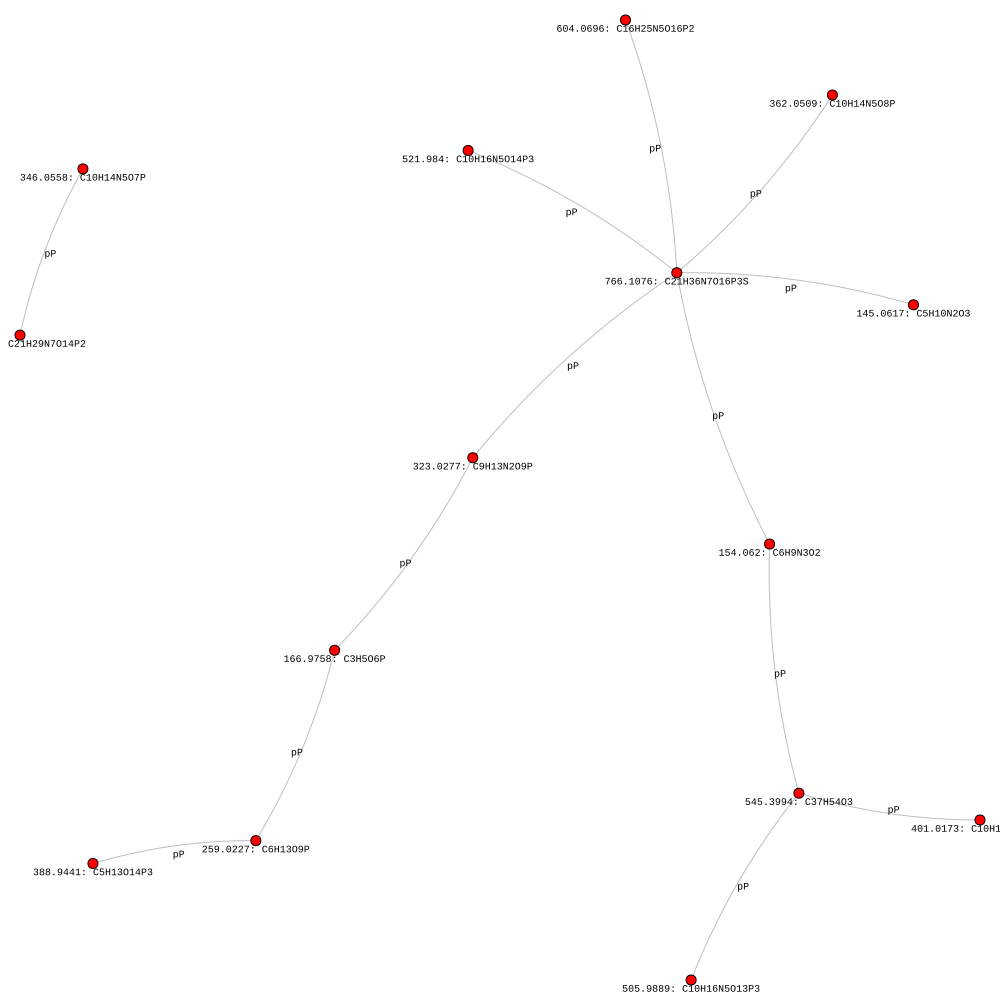

time: 117 ms (started: 2022-11-07 00:23:14 +00:00)


In [ ]:
# Plot using all nodes with Formula

edges_tuples = [(str(x[0]), str(x[1]), x[2]) for x in edges_w]
# print(edges_tuples)
g2 = ig.Graph.TupleList(edges_tuples, directed=False, weights=False)
print(len(g2.vs["name"]))
# print(g2.es["weight"])

g2 = g2.simplify()

# remove null Formula nodes
# delete_ids = [g2.vs["name"].index(node_id) for node_id in list_metabolite_no_formula.index.values if node_id in g2.vs["name"]]
delete_ids = np.where(np.isin(g2.vs["name"], list_metabolite_no_formula.index.values))[0]
g2.delete_vertices(delete_ids)
print(len(g2.vs["name"]))

# remove low degree nodes
delete_ids = [v.index for v in g2.vs if v.degree() == 0]
g2.delete_vertices(delete_ids)
print(len(g2.vs["name"]))
print(g2.summary())

formula = ["{}: {}".format(thing[0], thing[1]) for thing in zip(g2.vs["name"], list_metabolite_formula["Chemical Formula (based on BioCyc)"].loc[g2.vs["name"]].values)]
g2.vs["formula"] = formula
g2.es["weights"] = df_kind_change["Kind change"].values # df_kind_change["Kind change"].filter(items=g2.vs["name"], axis=0).values # label edges

layout = g2.layout_fruchterman_reingold()
# layout = g2.layout_davidson_harel()
# layout = g2.layout_lgl()

visual_style={}
visual_style["bbox"] = (1000, 1000)
visual_style["vertex_size"] = 10
# visual_style['vertex_size'] = [10 + w for w in g2.degree()]
visual_style["vertex_label"] = g2.vs["formula"]

visual_style["labels"] = g2.vs["name"]
# visual_style["vertex_label_color"] = "red"
visual_style["vertex_label_dist"] =1
visual_style["vertex_label_size"] = 10
visual_style["edge_label"] = g2.es["weights"]
visual_style["edge_color"] = "grey"
visual_style["edge_width"] = 1
visual_style["edge_label_size"] = 10
visual_style["edge_curved"] = 0.1
# visual_style["edge_curved"] = [False] * g2.ecount()

#visual_style["edge_label_color"] = "red"

""" fig, ax = plt.subplots(figsize=(30, 30))
ig.plot(g2, layout=layout, target=ax, **visual_style)
plt.axis("off") """

ig.plot(g2, layout=layout, **visual_style, target="graph_new_full.pdf")

Dendrogram, 15 elements, 13 merges
Clustering with 15 elements and 4 clusters
[5, 4, 4, 2]
IGRAPH UN-- 5 4 --
+ attr: formula (v), name (v), weights (e)
+ edges (vertex names):
145.0617--766.1076, 766.1076--362.0509, 766.1076--521.984, 766.1076--604.0696
[0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 0, 0, 1, 1, 0]


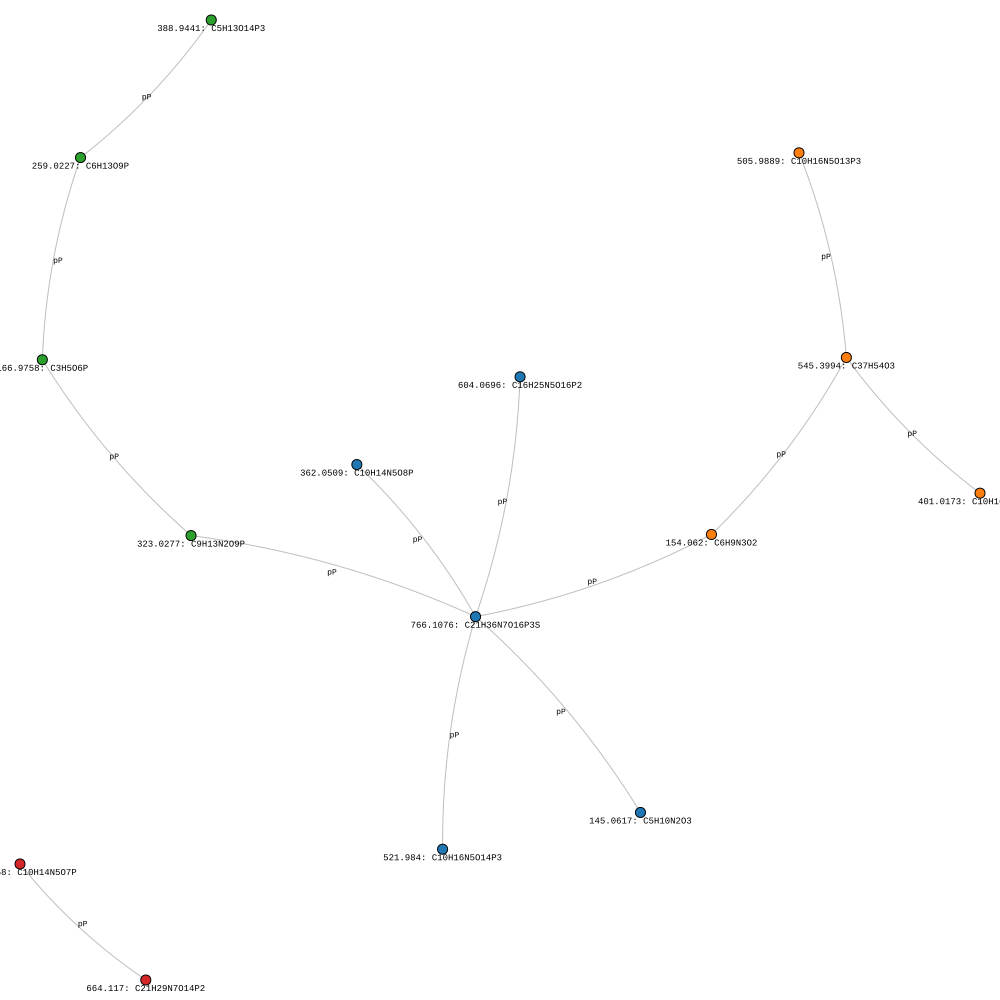

time: 43.1 ms (started: 2022-11-07 00:23:26 +00:00)


In [ ]:
# Plot clustering

dend_k = g2.community_fastgreedy()
clusters_k = dend_k.as_clustering()
nodes_membership = clusters_k.membership

print(dend_k.summary())
print(clusters_k.summary())
print(clusters_k.sizes())
print(clusters_k.giant())
print(nodes_membership)

palette = sns.color_palette("tab10", len(clusters_k.sizes()), 1)

layout = g2.layout_fruchterman_reingold()
# layout = g2.layout_davidson_harel()
# layout = g2.layout_lgl()
# layout = g2.layout_star()
# layout = g2.layout_graphopt()
# layout = g2.layout_reingold_tilford()
# layout = g2.layout_sugiyama()

visual_style={}
visual_style["bbox"] = (1000, 1000)
visual_style["vertex_size"] = 10
visual_style["vertex_color"] = [palette[m] for m in nodes_membership]

#visual_style["vertex_label"] = [p.get_pinyin(n, "",tone_marks='numbers') for n in g2.vs['name']]
visual_style["vertex_label"] = g2.vs["formula"]
visual_style["labels"] = g2.vs["name"]
visual_style["vertex_label_dist"] =1
visual_style["vertex_label_size"]= 9
#visual_style["vertex_label_size"] = [12 if vd>6 else 6 for vd in v_degree]
#visual_style["vertex_shape"] = "circle"
visual_style["edge_label"] = g2.es["weights"]
visual_style["edge_color"] = "grey"
visual_style["edge_width"] = 1
visual_style["edge_label_size"] = 8
visual_style["edge_curved"] = 0.1

""" fig, ax = plt.subplots(figsize=(30, 30))
ig.plot(g2, layout=layout, target=ax, **visual_style)
plt.axis("off") """

ig.plot(g2, layout=layout, **visual_style, target="graph_new_full_cluster.pdf")

In [ ]:
# Get formula by node id into clusters
df_cluster_formula = pd.DataFrame()
for k in range(len(clusters_k.sizes())):
  # before = df_raw1.loc[clusters_k.subgraph(k).vs["name"]].mean(axis=1).values
  # after = df_raw2.loc[clusters_k.subgraph(k).vs["name"]].mean(axis=1).values

  before = df_raw1[clusters_k.subgraph(k).vs["name"]].mean(axis=0).values
  after = df_raw2[clusters_k.subgraph(k).vs["name"]].mean(axis=0).values

  additional = pd.DataFrame({"Cluster {}: {}".format(k + 1, "Alignment"): clusters_k.subgraph(k).vs["name"],
                             # "Cluster {}: {}".format(k + 1, "INCHIKEY"): list_metabolite_formula["INCHIKEY"].loc[clusters_k.subgraph(k).vs["name"]].values,
                             # "Cluster {}: {}".format(k + 1, "Average Rt(min)"): list_metabolite_formula["Average Rt(min)"].loc[clusters_k.subgraph(k).vs["name"]].values,
                             "Cluster {}: {}".format(k + 1, "Formula"): list_metabolite_formula["Chemical Formula (based on BioCyc)"].loc[clusters_k.subgraph(k).vs["name"]].values,
                             # "Cluster {}: {}".format(k + 1, "Daltons"): list_metabolite_formula["Formula"].loc[clusters_k.subgraph(k).vs["name"]].apply(lambda formula: get_daltons(formula)),
                             "Cluster {}: {}".format(k + 1, "Before"): np.log10(before),
                             "Cluster {}: {}".format(k + 1, "After"): np.log10(after),
                             "Cluster {}: {}".format(k + 1, "Ratio"): np.log10(np.divide(after, before))
                             })
  df_cluster_formula = pd.concat([df_cluster_formula, additional], axis=1)
  
df_cluster_formula

,Cluster 1: Alignment,Cluster 1: Formula,Cluster 1: Before,Cluster 1: After,Cluster 1: Ratio,Cluster 2: Alignment,Cluster 2: Formula,Cluster 2: Before,Cluster 2: After,Cluster 2: Ratio,...,Cluster 4: Alignment,Cluster 4: Formula,Cluster 4: Before,Cluster 4: After,Cluster 4: Ratio,Cluster 5: Alignment,Cluster 5: Formula,Cluster 5: Before,Cluster 5: After,Cluster 5: Ratio
0,109.0407,C5H6N2O,3.690890,3.992306,0.301416,113.0246,C5H6O3,4.140207,3.890114,-0.250093,...,115.0038,C4H4O4,3.684800,3.775310,0.090510,130.0875,C6H13NO2,4.952801,5.079611,0.126810
1,237.0282,C6H11N2O6P,4.104786,4.190064,0.085278,128.0355,C5H7NO3,4.992283,5.133026,0.140743,...,59.0137,C2H4O2,4.919228,4.972764,0.053536,147.0297,C5H8O5,4.077917,4.021914,-0.056003
2,135.0311,C5H5N5,3.915120,3.984560,0.069441,146.0458,C5H9NO4,5.410995,5.597817,0.186822,...,NaN,NaN,NaN,NaN,NaN,173.0095,C6H6O6,3.840477,3.481354,-0.359123
3,259.0227,C6H13O9P,4.846487,4.786560,-0.059927,74.0249,C2H5NO2,3.883277,4.055386,0.172109,...,NaN,NaN,NaN,NaN,NaN,218.1033,C9H17NO5,3.786743,3.700588,-0.086156
4,505.9889,C10H16N5O13P3,5.310060,5.311936,0.001875,131.0355,C5H8O4,3.297624,3.341911,0.044287,...,NaN,NaN,NaN,NaN,NaN,154.062,C6H9N3O2,4.987653,4.987967,0.000314
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 55.7 ms (started: 2022-11-03 04:35:12 +00:00)


In [ ]:
# Save
df_cluster_formula.to_csv("{}/Outputs/Clusters/df_new_full_cluster_ratio_inchikey_formula_05_04.csv".format(dir), index=True)

time: 209 ms (started: 2022-10-26 03:43:23 +00:00)


##### Set molecular weight (Daltons)

In [ ]:
# =(E3*12)+(F3*1.00782503207)+(G3*14.0030740048)+(H3*15.99491461956)+
#(I3*30.97376163)+(J3*31.972071)+(L3*18.99840322)+(M3*34.96885268)+(N3*78.9183371)+(P3*13.0033548378)+(Q3*2.0141017778)+(R3*15.0001088982)+(S3*17.999161)+(K3*27.9769265325)+(O3*126.904473)

In [ ]:
#@title get daltons
def get_daltons(formula):
  d = {"C": 12, 
       "H": 1.00782503207, 
       "N": 14.0030740048,
       "O": 15.99491461956,
       "P": 30.97376163,
       "S": 31.972071,
       "Si": 27.9769265325,
       "F": 18.99840322,
       "Cl": 34.96885268,
       "Br": 78.9183371}

  f = ""
  n = ""
  daltons = 0
  try:
    for k in range(len(formula)):
      if formula[k].isnumeric():
        n += formula[k]
      else:
        if formula[k].isupper() and f != "":
          # print(f, n)
          if n == "":
            n = "1"
          daltons += d[f] * int(n)
          f = formula[k]
          n = ""
        else:
          f += formula[k]
    if n == "":
      n = "1"
    # print(f, n)
    daltons += d[f] * int(n)
  except:
    daltons = 0
  return daltons

time: 4.3 ms (started: 2022-11-07 00:24:45 +00:00)


In [ ]:
formula = "C11H12O12"
# formula = "C18H14F4N2O4S"
formula = "C17H12O5"
get_daltons(formula)

296.06847348264

time: 3.65 ms (started: 2022-11-07 00:24:48 +00:00)


##### Building format with daltons

In [ ]:
# Get formula by node id into clusters and save one by one
for k in range(len(clusters_k.sizes())):
  # before = df_raw1.loc[clusters_k.subgraph(k).vs["name"]].mean(axis=1).values
  # after = df_raw2.loc[clusters_k.subgraph(k).vs["name"]].mean(axis=1).values

  before = df_process1[clusters_k.subgraph(k).vs["name"]].mean(axis=0).values
  after = df_process2[clusters_k.subgraph(k).vs["name"]].mean(axis=0).values

  df_cluster_formula = pd.DataFrame({"Alignment": clusters_k.subgraph(k).vs["name"],
                                     # "INCHIKEY": list_metabolite_formula["INCHIKEY"].loc[clusters_k.subgraph(k).vs["name"]].values,
                                     "Formula": list_metabolite_formula["Chemical Formula (based on BioCyc)"].loc[clusters_k.subgraph(k).vs["name"]].values,
                                     "Before": np.log10(before),
                                     "After": np.log10(after),
                                     "Ratio": np.log10(np.divide(after, before))})
  
  df_cluster_formula["Daltons"] = df_cluster_formula["Formula"].apply(lambda formula: get_daltons(formula))
  # first_column = df_cluster_formula.pop("INCHIKEY") 
  # df_cluster_formula.insert(0, "INCHIKEY", first_column)
  # df_cluster_formula["INCHIKEY"] = "InChIKey=" + df_cluster_formula["INCHIKEY"].astype("str")
  
  # Save
  df_cluster_formula.to_csv("{}/Outputs/Clusters/df_new_biocyc_full_cluster{}_inchikey_formula_ratio_daltons_05_04_process.csv".format(dir, k + 1), index=None, sep="\t")

time: 386 ms (started: 2022-11-07 00:31:17 +00:00)


##### Building format with metabolities

In [ ]:
# Get formula by node id into clusters and save one by one
for k in range(len(clusters_k.sizes())):
  # before = df_raw1.loc[clusters_k.subgraph(k).vs["name"]].mean(axis=1).values
  # after = df_raw2.loc[clusters_k.subgraph(k).vs["name"]].mean(axis=1).values

  before = df_process1[clusters_k.subgraph(k).vs["name"]].mean(axis=0).values
  after = df_process2[clusters_k.subgraph(k).vs["name"]].mean(axis=0).values

  df_cluster_formula = pd.DataFrame({# "Alignment": clusters_k.subgraph(k).vs["name"],
                                     # "INCHIKEY": list_metabolite_formula["INCHIKEY"].loc[clusters_k.subgraph(k).vs["name"]].values,
                                     # "Formula": list_metabolite_formula["Chemical Formula (based on BioCyc)"].loc[clusters_k.subgraph(k).vs["name"]].values,
                                     "Metabolities": list_metabolite_formula["Metabolites - Approved by Nicola"].loc[clusters_k.subgraph(k).vs["name"]].values,
                                     "Before": np.log10(before),
                                     "After": np.log10(after),
                                     "Ratio": np.log10(np.divide(after, before))})
  
  # Save
  df_cluster_formula.to_csv("{}/Outputs/Clusters/df_new_biocyc_full_cluster{}_metabolities_ratio_05_04_process.csv".format(dir, k + 1), index=None, sep="\t")

time: 69.5 ms (started: 2022-11-07 00:35:35 +00:00)


##### Building format (No)

In [ ]:
df_cluster_formula.head()

In [ ]:
df_temp = df_cluster_formula.iloc[:, 1:6]
df_temp
# df_cluster_formula.to_csv( header=None, index=None, sep='\t', mode='a')

In [ ]:
# Save
df_temp.to_csv("{}/df_biocyc_full_cluster_ratio_inchikey_formula_05_04.txt".format(dir), index=None, sep="\t")

time: 246 ms (started: 2022-08-03 04:06:14 +00:00)



👽
---
---



In [ ]:
# Plot using all nodes with Formula and filter by degree

edges_tuples = [(int(x[0]), int(x[1]), x[2]) for x in edges_w]
# print(edges_tuples)
g2 = ig.Graph.TupleList(edges_tuples, directed=False, weights=False)
print(len(g2.vs["name"]))
# print(g2.es["weight"])

g2 = g2.simplify()

# remove null Formula nodes
# delete_ids = [g2.vs["name"].index(node_id) for node_id in list_metabolite_no_formula.index.values if node_id in g2.vs["name"]]
delete_ids = np.where(np.isin(g2.vs["name"], list_metabolite_no_formula.index.values))[0]
g2.delete_vertices(delete_ids)
print(len(g2.vs["name"]))

# remove high degree nodes
delete_ids = [v.index for v in g2.vs if v.degree() > 50]
g2.delete_vertices(delete_ids)
print(len(g2.vs["name"]))

# remove low degree nodes
delete_ids = [v.index for v in g2.vs if v.degree() == 0]
g2.delete_vertices(delete_ids)
print(len(g2.vs["name"]))
print(g2.summary())

formula = ["{}: {}".format(thing[0], thing[1]) for thing in zip(g2.vs["name"], list_metabolite_formula["Formula"].loc[g2.vs["name"]].values)]
g2.vs["formula"] = formula
g2.es["weights"] = df_kind_change["Kind change"].filter(items=g2.vs["name"], axis=0).values # label edges

layout = g2.layout_fruchterman_reingold()
# layout = g2.layout_davidson_harel()
# layout = g2.layout_lgl()

visual_style={}
visual_style["bbox"] = (2000, 2000)
visual_style["vertex_size"] = 10
# visual_style['vertex_size'] = [10 + w for w in g2.degree()]
visual_style["vertex_label"] = g2.vs["formula"]

visual_style["labels"] = g2.vs["name"]
# visual_style["vertex_label_color"] = "red"
visual_style["vertex_label_dist"] =1
visual_style["vertex_label_size"] = 10
visual_style["edge_label"] = g2.es["weights"]
visual_style["edge_color"] = "grey"
visual_style["edge_width"] = 1
visual_style["edge_label_size"] = 10
visual_style["edge_curved"] = 0.1
# visual_style["edge_curved"] = [False] * g2.ecount()

#visual_style["edge_label_color"] = "red"

""" fig, ax = plt.subplots(figsize=(30, 30))
ig.plot(g2, layout=layout, target=ax, **visual_style)
plt.axis("off") """

ig.plot(g2, layout=layout, **visual_style, target="graph_filter.pdf")

234
92
92
86
IGRAPH UN-- 86 132 -- 
+ attr: name (v)


ValueError: ignored

time: 37.1 ms (started: 2022-10-25 15:05:22 +00:00)


Dendrogram, 185 elements, 183 merges
Clustering with 185 elements and 10 clusters
[37, 23, 30, 18, 14, 21, 32, 2, 5, 3]
IGRAPH UN-- 37 54 --
+ attr: formula (v), name (v), weights (e)
+ edges (vertex names):
273--1479, 268--614, 268--1340, 585--1482, 268--1482, 273--1708, 268--1708,
273--542, 268--542, 268--744, 585--745, 268--745, 585--789, 268--789,
273--1321, 585--1321, 268--1321, 268--1399, 585--1494, 268--1494, 585--1506,
268--1506, 268--1713, 268--180, 273--775, 273--1365, 585--1365, 268--1365,
585--1379, 268--1379, 585--1384, 268--1384, 268--1387, 585--1389, 268--1389,
268--1597, 273--753, 585--753, 268--753, 1597--753, 268--759, 268--1348,
268--1391, 268--757, 268--1493, 268--1618, 273--1671, 585--1671, 268--1671,
273--736, 745--736, 273--751, 273--769, 585--799
[0, 1, 0, 2, 3, 1, 4, 5, 3, 6, 2, 3, 5, 5, 5, 3, 5, 5, 0, 3, 4, 4, 1, 1, 1, 7, 0, 2, 2, 8, 2, 1, 7, 5, 5, 0, 5, 6, 2, 1, 1, 1, 2, 3, 0, 1, 2, 2, 0, 3, 1, 1, 3, 2, 0, 4, 1, 5, 5, 4, 4, 1, 5, 1, 4, 6, 6, 3, 2, 0, 4, 1, 6,

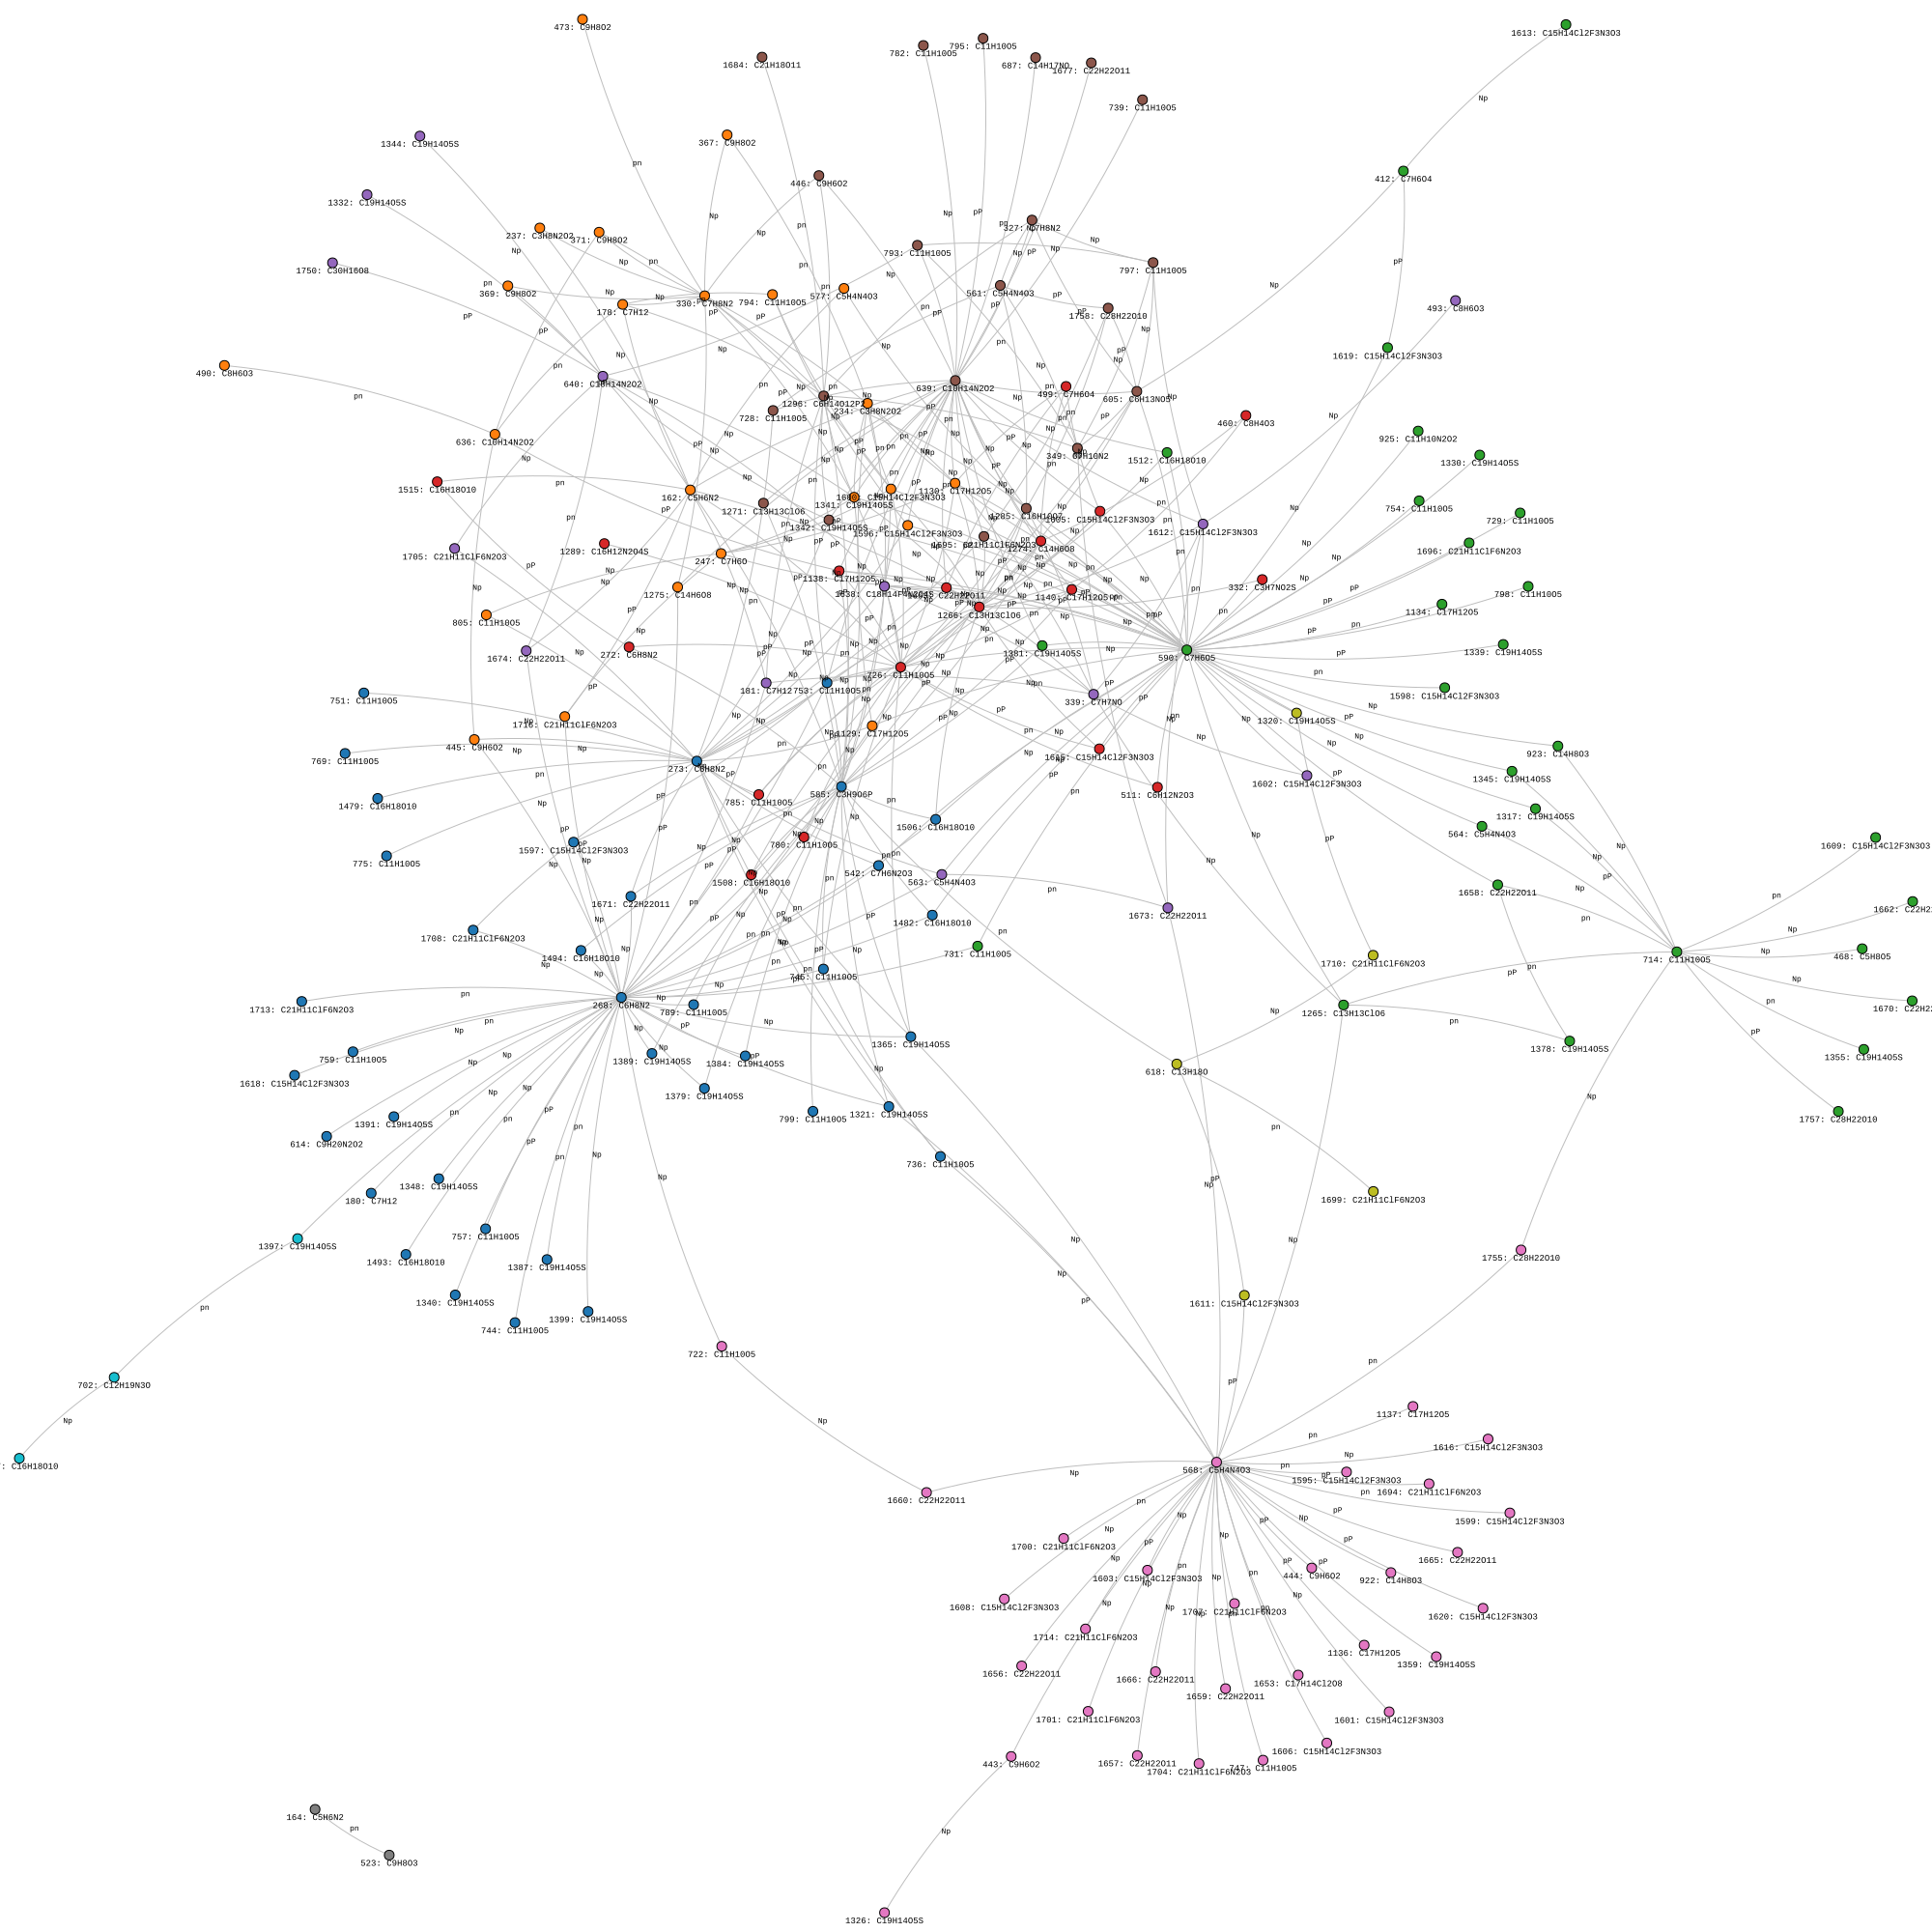

time: 325 ms (started: 2022-07-26 00:25:26 +00:00)


In [ ]:
# Plot clustering

dend_k = g2.community_fastgreedy()
clusters_k = dend_k.as_clustering()
nodes_membership = clusters_k.membership

print(dend_k.summary())
print(clusters_k.summary())
print(clusters_k.sizes())
print(clusters_k.giant())
print(nodes_membership)

palette = sns.color_palette("tab10", len(clusters_k.sizes()), 1)

layout = g2.layout_fruchterman_reingold()
# layout = g2.layout_davidson_harel()
# layout = g2.layout_lgl()
# layout = g2.layout_star()
# layout = g2.layout_graphopt()
# layout = g2.layout_reingold_tilford()
# layout = g2.layout_sugiyama()

visual_style={}
visual_style["bbox"] = (2000, 2000)
visual_style["vertex_size"] = 10
visual_style["vertex_color"] = [palette[m] for m in nodes_membership]

#visual_style["vertex_label"] = [p.get_pinyin(n, "",tone_marks='numbers') for n in g2.vs['name']]
visual_style["vertex_label"] = g2.vs["formula"]
visual_style["labels"] = g2.vs["name"]
visual_style["vertex_label_dist"] =1
visual_style["vertex_label_size"]= 9
#visual_style["vertex_label_size"] = [12 if vd>6 else 6 for vd in v_degree]
#visual_style["vertex_shape"] = "circle"
visual_style["edge_label"] = g2.es["weights"]
visual_style["edge_color"] = "grey"
visual_style["edge_width"] = 1
visual_style["edge_label_size"] = 8
visual_style["edge_curved"] = 0.1

""" fig, ax = plt.subplots(figsize=(30, 30))
ig.plot(g2, layout=layout, target=ax, **visual_style)
plt.axis("off") """

ig.plot(g2, layout=layout, **visual_style, target="graph_filter_cluster.pdf")

In [ ]:
# Get formula by node id into clusters
df_cluster_formula = pd.DataFrame()
for k in range(len(clusters_k.sizes())):
  additional = pd.DataFrame({"Cluster {}: {}".format(k + 1, "INCHIKEY"): list_metabolite_formula["INCHIKEY"].loc[clusters_k.subgraph(k).vs["name"]].values,
                             "Cluster {}: {}".format(k + 1, "Average Rt(min)"): list_metabolite_formula["Average Rt(min)"].loc[clusters_k.subgraph(k).vs["name"]].values,
                             "Cluster {}: {}".format(k + 1, "Formula"): list_metabolite_formula["Formula"].loc[clusters_k.subgraph(k).vs["name"]].values
                             })
  df_cluster_formula = pd.concat([df_cluster_formula, additional], axis=1) 
df_cluster_formula

,Cluster 1: INCHIKEY,Cluster 1: Average Rt(min),Cluster 1: Formula,Cluster 2: INCHIKEY,Cluster 2: Average Rt(min),Cluster 2: Formula,Cluster 3: INCHIKEY,Cluster 3: Average Rt(min),Cluster 3: Formula,Cluster 4: INCHIKEY,...,Cluster 7: Formula,Cluster 8: INCHIKEY,Cluster 8: Average Rt(min),Cluster 8: Formula,Cluster 9: INCHIKEY,Cluster 9: Average Rt(min),Cluster 9: Formula,Cluster 10: INCHIKEY,Cluster 10: Average Rt(min),Cluster 10: Formula
0,HKOOXMFOFWEVGF-UHFFFAOYSA-N,10.779,C6H8N2,LEHOTFFKMJEONL-UHFFFAOYSA-N,10.799,C5H4N4O3,LNTHITQWFMADLM-UHFFFAOYSA-N,10.818,C7H6O5,NaN,...,C5H4N4O3,ICSNLGPSRYBMBD-UHFFFAOYSA-N,5.641,C5H6N2,MLKCGVHIFJBRCD-UHFFFAOYNA-N,30.222,C15H14Cl2F3N3O3,BELBBZDIHDAJOR-UHFFFAOYSA-N,26.889,C19H14O5S
1,AWUCVROLDVIAJX-GSVOUGTGSA-N,10.770,C3H9O6P,NaN,14.940,C7H6O,NaN,18.505,C11H10O5,FJYFQXJJSFYJQV-UHFFFAOYNA-N,...,C11H10O5,NaN,21.535,C9H8O3,BELBBZDIHDAJOR-UHFFFAOYSA-N,16.424,C19H14O5S,CPTBDICYNRMXFX-UHFFFAOYSA-N,24.431,C12H19N3O
2,RVWWDDKOKZXKCJ-UHFFFAOYNA-N,34.681,C16H18O10,RYLHNOVXKPXDIP-UHFFFAOYSA-N,20.908,C21H11ClF6N2O3,LEHOTFFKMJEONL-UHFFFAOYSA-N,22.544,C5H4N4O3,NaN,...,C9H6O2,NaN,NaN,NaN,RYLHNOVXKPXDIP-UHFFFAOYSA-N,27.703,C21H11ClF6N2O3,RVWWDDKOKZXKCJ-UHFFFAOYNA-N,36.663,C16H18O10
3,HKOOXMFOFWEVGF-UHFFFAOYSA-N,10.866,C6H8N2,PECYZEOJVXMISF-UHFFFAOYNA-N,16.630,C3H8N2O2,BELBBZDIHDAJOR-UHFFFAOYSA-N,18.489,C19H14O5S,RSJIHDBGVSYSFI-UHFFFAOYNA-N,...,C9H6O2,NaN,NaN,NaN,NaN,22.442,C13H18O,NaN,NaN,NaN
4,MXNRLFUSFKVQSK-UHFFFAOYNA-N,21.787,C9H20N2O2,NaN,13.623,C11H10O5,WLSOGIGMSWCVID-UHFFFAOYNA-N,26.048,C22H22O11,MLKCGVHIFJBRCD-UHFFFAOYNA-N,...,C11H10O5,NaN,NaN,NaN,RYLHNOVXKPXDIP-UHFFFAOYSA-N,21.503,C21H11ClF6N2O3,NaN,NaN,NaN
5,BELBBZDIHDAJOR-UHFFFAOYSA-N,18.842,C19H14O5S,NaN,20.999,C9H8O2,NaN,28.231,C11H10O5,AFSDNFLWKVMVRB-UHFFFAOYSA-N,...,C17H12O5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,RVWWDDKOKZXKCJ-UHFFFAOYNA-N,33.612,C16H18O10,NaN,22.313,C11H10O5,RSJIHDBGVSYSFI-UHFFFAOYNA-N,13.563,C17H12O5,RVWWDDKOKZXKCJ-UHFFFAOYNA-N,...,C19H14O5S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,RYLHNOVXKPXDIP-UHFFFAOYSA-N,22.583,C21H11ClF6N2O3,RSJIHDBGVSYSFI-UHFFFAOYNA-N,24.415,C17H12O5,BELBBZDIHDAJOR-UHFFFAOYSA-N,27.747,C19H14O5S,WLSOGIGMSWCVID-UHFFFAOYNA-N,...,C15H14Cl2F3N3O3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,KLGQWSOYKYFBTR-UHFFFAOYSA-N,22.547,C7H6N2O3,RSJIHDBGVSYSFI-UHFFFAOYNA-N,26.052,C17H12O5,BELBBZDIHDAJOR-UHFFFAOYSA-N,18.889,C19H14O5S,LGRFSURHDFAFJT-UHFFFAOYSA-N,...,C15H14Cl2F3N3O3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,35.536,C11H10O5,BELBBZDIHDAJOR-UHFFFAOYSA-N,17.052,C19H14O5S,RYLHNOVXKPXDIP-UHFFFAOYSA-N,22.501,C21H11ClF6N2O3,RVWWDDKOKZXKCJ-UHFFFAOYNA-N,...,C15H14Cl2F3N3O3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 107 ms (started: 2022-07-26 00:25:26 +00:00)


In [ ]:
# Save
df_cluster_formula.to_csv("{}/df_filter_cluster_ratio_inchikey_formula_05_04.csv".format(dir), index=True)

time: 350 ms (started: 2022-07-26 00:25:27 +00:00)


##### Testing get sub graph by radius

In [ ]:
df_concat_

In [ ]:
G = nx.Graph()
# G.add_edges_from(edges_)
G.add_edges_from([[1, 2], [1, 3], [1, 4], [1, 5], [2, 6], [2, 7], [4, 7], [4, 8], [4, 9], [8, 10], [9, 10]])

nx.draw(G, with_labels=True, node_color="orange")  # networkx draw()
plt.draw()  # pyplot draw()

In [ ]:
node_id = 1
radius = 2
list_radius = []
for k in range(radius):
  SG = nx.ego_graph(G, n=node_id, radius=k+1, center=True, undirected=False, distance=None)
  aux = list(SG.nodes())
  #aux = set(aux) - set([node_id])
  if len(list_radius) > 0:
    aux = list(set(aux) - set(list_radius[k-1]))
  list_radius.append(aux)

print(list_radius)

pos = nx.spring_layout(SG, k=0.5, seed=42)  # Seed layout for reproducibility

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(SG, pos, with_labels=True, node_color="orange", ax=ax)  # networkx draw()
# plt.draw()  # pyplot draw()

# Draw ego as large and red
# options = {"node_size": 300, "node_color": "#61ff33"}
colors = ["#FF0000", "#00FF00", "#00FFFF"]
nx.draw_networkx_nodes(SG, pos, nodelist=[node_id], node_color=colors[0])
nx.draw_networkx_nodes(SG, pos, nodelist=list_radius[0], node_color=colors[1])
nx.draw_networkx_nodes(SG, pos, nodelist=list_radius[1], node_color=colors[2])
plt.axis("off")



---



##### Test plot Clustering

In [ ]:
g2 = g2.simplify()
g2_fg = g2.community_fastgreedy()

g2_fg.optimal_count
nodes_membership = g2_fg.as_clustering(n=8).membership
print(nodes_membership)

# # from seaborn import color_palette
# palette = plt.get_cmap("Set3")
# palette(11)[1]
plt.rcParams['font.sans-serif']=["PingFang HK"]
plt.rcParams['axes.unicode_minus']= False
import seaborn as sns

palette = sns.color_palette('tab10')

# WIDTH = 10
# HEIGHT = 8
# PIXEL_SCALE = 200

# surface = cairo.ImageSurface(cairo.FORMAT_RGB24,
#                              WIDTH*PIXEL_SCALE,
#                              HEIGHT*PIXEL_SCALE)
# ctx = cairo.Context(surface)
# ctx.scale(PIXEL_SCALE, PIXEL_SCALE)

# ctx.rectangle(0, 0, WIDTH, HEIGHT)
#ctx.set_source_rgb(0.8, 0.8, 1)
#ctx.fill()

# Drawing code
# ctx.set_source_rgb(1, 0, 0)
# ctx.set_font_size(0.25)
# ctx.select_font_face("sans",
#                      cairo.FONT_SLANT_NORMAL,
#                      cairo.FONT_WEIGHT_NORMAL)

layout = g2.layout_fruchterman_reingold()

visual_style={}
visual_style["vertex_size"] = 10
visual_style["vertex_color"] = [palette[m+2] for m in nodes_membership]

#visual_style["vertex_label"] = [p.get_pinyin(n, "",tone_marks='numbers') for n in g2.vs['name']]
visual_style["vertex_label"] = g2.vs['name']
visual_style["labels"] = g2.vs['name']
visual_style["vertex_label_dist"] =1
visual_style["vertex_label_size"]= 8
#visual_style["vertex_label_size"] = [12 if vd>6 else 6 for vd in v_degree]
#visual_style["vertex_shape"] = "circle"

visual_style["edge_color"] = "grey"
visual_style["edge_width"] = 1
#visual_style["edge_curved"] = 0.1

""" visual_style["layout"]=layout
visual_style["bbox"]=(500,800)
visual_style["margin"]=40 """

fig, ax = plt.subplots(figsize=(20, 20))
ig.plot(g2, target=ax, **visual_style)
plt.axis("off")

#### Plot all



In [ ]:
edges_ = []
for k, node_id in enumerate(list_):
  edges_by_node = df_changes1_[["Node u", "Node v"]].loc[(df_changes1_["Node u"] == node_id) | (df_changes1_["Node v"] == node_id)]
  edges_ += edges_by_node.to_numpy().tolist()
print(len(list_))

edges_tuples = [tuple(x) for x in edges_]
g2 = ig.Graph.TupleList(edges_tuples, directed=False)

g2 = g2.simplify()
layout = g2.layout_fruchterman_reingold()
# layout = g2.layout_davidson_harel()
# layout = g2.layout_lgl()

visual_style={}
visual_style["vertex_size"] = 10
visual_style["vertex_label"] = g2.vs['name']

visual_style["labels"] = g2.vs['name']
visual_style["vertex_label_dist"] =1
visual_style["vertex_label_size"]= 10
visual_style["edge_color"] = "grey"
visual_style["edge_width"] = 1

fig, ax = plt.subplots(figsize=(30, 30))
ig.plot(g2, layout=layout, target=ax, **visual_style)
plt.axis("off")

#### Test other Plot

In [ ]:
# Gold standard data of positive gene functional associations
# from https://www.inetbio.org/wormnet/downloadnetwork.php
# G = nx.read_edgelist("WormNet.v3.benchmark.txt")
# G = nx.Graph()
# G.add_edges_from(edges_)

# remove randomly selected nodes (to make example fast)
""" num_to_remove = int(len(G) / 1.5)
nodes = sample(list(G.nodes), num_to_remove)
G.remove_nodes_from(nodes) """

# remove low-degree nodes
""" low_degree = [n for n, d in G.degree() if d > 10]
G.remove_nodes_from(low_degree) """

# largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=1.5, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    # node_color=node_color,
    # node_size=node_size,
    edge_color="gainsboro",
    # alpha=0.4,
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 10}
ax.set_title("Gene functional association network (C. elegans)", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "node color = community structure",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size = betweeness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()



---



In [ ]:
from random import sample
import networkx as nx
import matplotlib.pyplot as plt

# Gold standard data of positive gene functional associations
# from https://www.inetbio.org/wormnet/downloadnetwork.php
# G = nx.read_edgelist("WormNet.v3.benchmark.txt")
G = nx.Graph()
G.add_edges_from(edges_)

# remove randomly selected nodes (to make example fast)
""" num_to_remove = int(len(G) / 1.5)
nodes = sample(list(G.nodes), num_to_remove)
G.remove_nodes_from(nodes) """

# remove low-degree nodes
low_degree = [n for n, d in G.degree() if d < 10]
G.remove_nodes_from(low_degree)

# largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(H, k=20, endpoints=True)

# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=1.5, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    #node_color=node_color,
    #node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("Gene functional association network (C. elegans)", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "node color = community structure",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size = betweeness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

In [ ]:
from operator import itemgetter

import matplotlib.pyplot as plt
import networkx as nx

# Create a BA model graph - use seed for reproducibility
n = 1000
m = 2
seed = 20532
# G = nx.barabasi_albert_graph(n, m, seed=seed)
G = nx.Graph()
G.add_edges_from(edges_)

# find node with largest degree
node_and_degree = G.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]

# Create ego graph of main hub
hub_ego = nx.ego_graph(G, largest_hub)

# Draw graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(hub_ego, seed=seed)  # Seed layout for reproducibility
nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)
print(largest_hub)
# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# G = nx.balanced_tree(3, 5)
G = nx.Graph()
G.add_edges_from(edges_)

# remove low-degree nodes
# low_degree = [n for n, d in G.degree() if d < 30]
# G.remove_nodes_from(low_degree)

pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
plt.figure(figsize=(20, 20))
nx.draw(G, pos, node_size=20, alpha=0.5, node_color="blue", with_labels=False)
plt.axis("equal")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# G = nx.krackhardt_kite_graph()
G = nx.Graph()
G.add_weighted_edges_from(edges)

print("Betweenness")
b = nx.betweenness_centrality(G)
for v in G.nodes():
    print(f"{v:2} {b[v]:.3f}")

print("Degree centrality")
d = nx.degree_centrality(G)
for v in G.nodes():
    print(f"{v:2} {d[v]:.3f}")

print("Closeness centrality")
c = nx.closeness_centrality(G)
for v in G.nodes():
    print(f"{v:2} {c[v]:.3f}")
    
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, seed=367)  # Seed layout for reproducibility
nx.draw(G, pos)
plt.show()

In [ ]:
# graphviz is installed already, but need lib too
!apt install libgraphviz-dev
!pip install pygraphviz

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import urllib.request

def lanl_graph():
    """Return the lanl internet view graph from lanl.edges"""
    try:
        fh = urllib.request.urlopen("https://raw.githubusercontent.com/networkx/networkx/main/examples/graphviz_layout/lanl_routes.edgelist")

    except OSError:
        print("lanl.edges not found")
        raise

    G = nx.Graph()

    time = {}
    time[0] = 0  # assign 0 to center node
    for line in fh.readlines():
        (head, tail, rtt) = line.split()
        G.add_edge(int(head), int(tail))
        time[int(head)] = float(rtt)

    # get largest component and assign ping times to G0time dictionary
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)[0]
    G0 = G.subgraph(Gcc)
    G0.rtt = {}
    for n in G0:
        G0.rtt[n] = time[n]

    return G0


G = lanl_graph()

print(G)
print(nx.number_connected_components(G), "connected components")

plt.figure(figsize=(8, 8))
# use graphviz to find radial layout
pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", root=0)
# draw nodes, coloring by rtt ping time
options = {"with_labels": False, "alpha": 0.5, "node_size": 15}
nx.draw(G, pos, node_color=[G.rtt[v] for v in G], **options)
# adjust the plot limits
xmax = 1.02 * max(xx for xx, yy in pos.values())
ymax = 1.02 * max(yy for xx, yy in pos.values())
plt.xlim(0, xmax)
plt.ylim(0, ymax)
plt.show()

In [ ]:
!pip install igraph
!pip install cairocffi
!pip install pycairo

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig

# G = nx.dense_gnm_random_graph(30, 40, seed=42)
G = nx.Graph()
G.add_edges_from(edges_)

# largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# convert to igraph
h = ig.Graph.from_networkx(H)


# Plot the same network with NetworkX and igraph
fig, (ax0) = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

# NetworkX draw
# ax0.set_title("Plot with NetworkX draw")
# nx.draw_kamada_kawai(H, node_size=50, ax=ax0)

# igraph draw
ax0.set_title("Plot with igraph plot")
layout = h.layout_kamada_kawai()
ig.plot(h, layout=layout, target=ax0)
plt.axis("off")
plt.show()

In [ ]:
g = ig.Graph(edges_)
layout = g.layout("kk")
fig, ax = plt.subplots(figsize=(20, 20))
ig.plot(g, layout=layout, target=ax)

In [ ]:
edges_tuples = [tuple(x) for x in edges_]
g = ig.Graph.TupleList(edges_tuples, directed=False)
g = g.simplify()
layout = g.layout_fruchterman_reingold()

fig, ax = plt.subplots(figsize=(30, 30))
ig.plot(g, layout=layout, target=ax)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(1, 5)
G.add_edge(2, 3)
G.add_edge(3, 4)
G.add_edge(4, 5)

# explicitly set positions
pos = {1: (0, 0), 2: (1, 1), 3: (2, 2), 4: (4, 4), 5: (50, 5)}

options = {
    "font_size": 36,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw_networkx(G, pos, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()